In [1]:
# !rm -rf '/content/object_foto_dataset'

# Подготовка среды

In [2]:
!git clone https://github.com/torpedonosec80/object_foto_dataset.git

Cloning into 'object_foto_dataset'...
remote: Enumerating objects: 23931, done.
remote: Counting objects: 100% (90/90), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 23931 (delta 46), reused 11 (delta 7), pack-reused 23841 (from 5)
Receiving objects: 100% (23931/23931), 420.22 MiB | 21.11 MiB/s, done.
Resolving deltas: 100% (15510/15510), done.
Updating files: 100% (6628/6628), done.


In [3]:
!pip install -q ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 95.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.0 MB/s eta 0:00:00


In [4]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageOps

## config

In [5]:
# config.py
CLASSES = {
    0: 'background',
    1: 'shta-9m',
    2: 'shta-ps',
    3: 'shta-7m',
    4: 'e2-6u',
    5: 'shta-9',
    6: 'shta-3',
    7: 'sv-5'
}
CLASS_NAME_TO_ID = {v: k for k, v in CLASSES.items()}
NUM_CLASSES = len(CLASSES)

# Пути по умолчанию
DEFAULT_DATA_DIR = "/content/object_foto_dataset/boxes_dataset"
DEFAULT_YOLO_DIR = "/content/yolo_dataset"
DEFAULT_SAVE_DIR = "saved_models"
AUGMENTED_SAVE_DIR = "saved_models_aug"

DEFAULT_METRIC_DIR = "metrics"
AUGMENTED_METRIC_DIR = "metrics_aug"

## data_preparation

In [6]:
# data_preparation.py
import os
import shutil
import xml.etree.ElementTree as ET
import cv2
import yaml
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import pandas as pd
from PIL import Image
from pathlib import Path
# from config import CLASS_NAME_TO_ID, CLASSES

def convert_annotations_to_yolo_format(data_dir, output_dir, subsets):
    os.makedirs(output_dir, exist_ok=True)
    for subset in subsets:
        os.makedirs(os.path.join(output_dir, subset, 'images'), exist_ok=True)
        os.makedirs(os.path.join(output_dir, subset, 'labels'), exist_ok=True)
    all_images = [f for f in os.listdir(data_dir) if f.endswith(('.jpeg', '.jpg', '.JPG', '.png'))]
    # Создаем dataset.yaml
    yaml_data = {
        'path': output_dir,
        'train': 'train/images',
        'val': 'val/images',
        'test': 'test/images',
        'names': {idx-1: name for idx, name in CLASSES.items() if idx != 0}
    }
    with open(os.path.join(output_dir, 'dataset.yaml'), 'w') as f:
        yaml.dump(yaml_data, f)

    def convert_single_annotation(img_name, subset):
        img_path = os.path.join(data_dir, img_name)
        xml_path = os.path.join(data_dir, os.path.splitext(img_name)[0] + '.xml')
        txt_path = os.path.join(output_dir, subset, 'labels', os.path.splitext(img_name)[0] + '.txt')
        shutil.copy(img_path, os.path.join(output_dir, subset, 'images', img_name))
        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not read image {img_path}. Skipping.")
            return
        height, width = img.shape[:2]
        if not os.path.exists(xml_path):
            print(f"Warning: XML annotation not found for {img_name}. Skipping.")
            return
        try:
            tree = ET.parse(xml_path)
            root = tree.getroot()
        except ET.ParseError:
            print(f"Error parsing XML for {img_name}. Skipping.")
            return
        with open(txt_path, 'w') as f_txt:
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                if class_name not in CLASS_NAME_TO_ID:
                    continue
                class_id = CLASS_NAME_TO_ID[class_name] - 1
                bndbox = obj.find('bndbox')
                try:
                    xmin = float(bndbox.find('xmin').text)
                    ymin = float(bndbox.find('ymin').text)
                    xmax = float(bndbox.find('xmax').text)
                    ymax = float(bndbox.find('ymax').text)
                except (AttributeError, ValueError):
                    print(f"Error reading bbox for {img_name}. Skipping object.")
                    continue
                x_center = (xmin + xmax) / (2.0 * width)
                y_center = (ymin + ymax) / (2.0 * height)
                bbox_width = (xmax - xmin) / width
                bbox_height = (ymax - ymin) / height
                if (0 <= x_center <= 1 and 0 <= y_center <= 1 and
                    0 < bbox_width <= 1 and 0 < bbox_height <= 1):
                    f_txt.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")
                else:
                    print(f"Invalid bbox coordinates in {img_name}: "
                          f"x_center={x_center}, y_center={y_center}, "
                          f"width={bbox_width}, height={bbox_height}")
    indices = list(range(len(all_images)))
    train_idx, test_idx = train_test_split(indices, test_size=0.15, random_state=42)
    train_idx, val_idx = train_test_split(train_idx, test_size=0.176, random_state=42)
    for i, img_name in enumerate(tqdm(all_images)):
        if i in train_idx:
            convert_single_annotation(img_name, 'train')
        elif i in val_idx:
            convert_single_annotation(img_name, 'val')
        elif i in test_idx:
            convert_single_annotation(img_name, 'test')

def load_annotations(data_dir):
    """
    Загружает XML аннотации в DataFrame
    """
    annotations = []
    for xml_file in Path(data_dir).glob("*.xml"):
        try:
            tree = ET.parse(xml_file)
            root = tree.getroot()
            filename = root.find('filename').text
            img_path = Path(data_dir) / filename
            if not img_path.exists():
                continue
            with Image.open(img_path) as img:
                width, height = img.size
            for obj in root.findall('object'):
                class_name = obj.find('name').text
                bbox = obj.find('bndbox')
                xmin = int(bbox.find('xmin').text)
                ymin = int(bbox.find('ymin').text)
                xmax = int(bbox.find('xmax').text)
                ymax = int(bbox.find('ymax').text)
                annotations.append({
                    'image': filename,
                    'class': class_name,
                    'img_w': width,
                    'img_h': height,
                    'xmin': xmin,
                    'ymin': ymin,
                    'xmax': xmax,
                    'ymax': ymax
                })
        except Exception as e:
            print(f"Error processing {xml_file}: {str(e)}")
    df = pd.DataFrame(annotations)
    if not df.empty:
        df['bbox_w'] = df['xmax'] - df['xmin']
        df['bbox_h'] = df['ymax'] - df['ymin']
        df['bbox_area'] = df['bbox_w'] * df['bbox_h']
    return df

## evaluation

In [7]:
# evaluation.py
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from pathlib import Path
from ultralytics import YOLO
# from config import CLASSES
import pandas as pd
from tqdm import tqdm

def evaluate_model(model, data_yaml, split='test'):
    results = model.val(
        data=data_yaml,
        split=split,
        name='yolo_test_evaluation'
    )
    print(f'\n=== YOLO Test Results ===')
    print(f'mAP50-95: {results.box.map:.4f}')
    print(f'mAP50: {results.box.map50:.4f}')
    print(f'mAP75: {results.box.map75:.4f}')
    return results

def visualize_predictions(model, dataset_dir, num_samples=5, conf=0.5, save_path='yolo_predictions.png'):
    test_images_dir = os.path.join(dataset_dir, 'test', 'images')
    image_files = [f for f in os.listdir(test_images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))][:num_samples]
    if num_samples == 1:
        fig, axs = plt.subplots(1, 1, figsize=(12, 6))
        axs = [axs]
    else:
        fig, axs = plt.subplots(num_samples, 1, figsize=(12, 6*num_samples))
    for i, img_file in enumerate(image_files):
        img_path = os.path.join(test_images_dir, img_file)
        results = model.predict(source=img_path, conf=conf, save=False, imgsz=640)
        result = results[0]
        img = cv2.cvtColor(result.orig_img, cv2.COLOR_BGR2RGB)
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f'Image: {img_file}')
        if result.boxes is not None and len(result.boxes) > 0:
            boxes = result.boxes.xyxy.cpu().numpy()
            clss = result.boxes.cls.cpu().numpy()
            confs = result.boxes.conf.cpu().numpy()
            for box, cls_id, conf_val in zip(boxes, clss, confs):
                x1, y1, x2, y2 = box[:4]
                rect = patches.Rectangle(
                    (x1, y1), x2-x1, y2-y1,
                    linewidth=1.5, edgecolor='r', facecolor='none'
                )
                axs[i].add_patch(rect)
                class_name = model.names[int(cls_id)]
                label = f"{class_name} {conf_val:.2f}"
                axs[i].text(
                    x1+2, y1+10, label,
                    color='white', fontsize=10,
                    bbox=dict(facecolor='red', alpha=0.8)
                )
            if result.masks is not None:
                masks = result.masks.xy
                for mask in masks:
                    if len(mask) > 0:
                        poly = patches.Polygon(
                            mask, closed=True,
                            edgecolor='lime', facecolor='none', linewidth=1.5
                        )
                        axs[i].add_patch(poly)
        else:
            axs[i].text(0.5, 0.5, 'No detections',
                        fontsize=12, color='red',
                        ha='center', va='center',
                        transform=axs[i].transAxes)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()
    return save_path

def run_detection_on_dataset(model, source_dir, conf_threshold=0.25):
    """
    Выполняет детекцию на всем датасете и возвращает результаты в DataFrame
    """
    image_extensions = ('.jpg', '.jpeg', '.png', '.JPG')
    image_files = [f for f in os.listdir(source_dir)
                 if f.lower().endswith(image_extensions)]
    results_list = []
    for img_file in tqdm(image_files, desc="Running detection"):
        img_path = os.path.join(source_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue
        height, width = img.shape[:2]
        # Выполняем предсказание
        predictions = model.predict(
            source=img_path,
            conf=conf_threshold,
            save=False,
            imgsz=640
        )
        result = predictions[0]
        if result.boxes is not None:
            boxes = result.boxes.xyxy.cpu().numpy()
            clss = result.boxes.cls.cpu().numpy()
            confs = result.boxes.conf.cpu().numpy()
            for box, cls_id, conf_val in zip(boxes, clss, confs):
                class_name = model.names[int(cls_id)]
                x1, y1, x2, y2 = box
                results_list.append({
                    'image_file': img_file,
                    'class_id': int(cls_id),
                    'class_name': class_name,
                    'confidence': conf_val,
                    'x1': x1, 'y1': y1, 'x2': x2, 'y2': y2,
                    'width': x2 - x1,
                    'height': y2 - y1,
                    'rel_x1': x1 / width,
                    'rel_y1': y1 / height,
                    'rel_x2': x2 / width,
                    'rel_y2': y2 / height,
                    'rel_width': (x2 - x1) / width,
                    'rel_height': (y2 - y1) / height
                })
        else:
            # Запись для изображений без детекций
            results_list.append({
                'image_file': img_file,
                'class_id': None,
                'class_name': None,
                'confidence': None,
                'x1': None, 'y1': None, 'x2': None, 'y2': None,
                'width': None, 'height': None,
                'rel_x1': None, 'rel_y1': None,
                'rel_x2': None, 'rel_y2': None,
                'rel_width': None, 'rel_height': None
            })

    return pd.DataFrame(results_list)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## model_training

In [8]:
# model_training.py
import os
import shutil
from pathlib import Path
from ultralytics import YOLO
import torch
# from config import DEFAULT_SAVE_DIR

def train_yolo_model(data_yaml, epochs=30, batch_size=8, model_size='n', device=None, data_augmentation=False):
    if device is None:
        device = '0' if torch.cuda.is_available() else 'cpu'

    model = YOLO(f'yolov8{model_size}.pt')

    if data_augmentation:
        train_params = {
            'data': data_yaml,
            'epochs': epochs,
            'batch': batch_size,
            'imgsz': 640,
            'device': device,
            'workers': 2,
            'name': 'yolo_object_detection',
            # параметры аугментации
            'augment': True,
            'hsv_h': 0.5,        # Сильное изменение оттенка
            'hsv_s': 0.8,        # Сильное изменение насыщенности
            'hsv_v': 0.8,        # Сильное изменение яркости
            'erasing': 0.9,      # Случайное стирание
        }
    else:
        train_params = {
            'data': data_yaml,
            'epochs': epochs,
            'batch': batch_size,
            'imgsz': 640,
            'device': device,
            'workers': 2,
            'name': 'yolo_object_detection'
        }

    results = model.train(**train_params)
    return model, results

def save_model(model, save_dir=DEFAULT_SAVE_DIR):
    os.makedirs(save_dir, exist_ok=True)
    best_model_path = os.path.join(save_dir, 'best_yolo_model.pt')
    # Экспорт и сохранение
    model.export(format="torchscript", imgsz=640)
    model.save(best_model_path)
    # Попытка найти лучшую модель через trainer
    if hasattr(model, 'trainer'):
        trainer = model.trainer
        trainer_best_path = Path(trainer.save_dir) / 'weights' / 'best.pt'
        if trainer_best_path.exists():
            shutil.copy(str(trainer_best_path), best_model_path)
            print(f'Best model copied to {best_model_path}')
        else:
            last_model_path = Path(trainer.save_dir) / 'weights' / 'last.pt'
            if last_model_path.exists():
                shutil.copy(str(last_model_path), best_model_path)
                print(f'Used last.pt as best model (best.pt not found)')
    return best_model_path

## metrics_analysis

In [9]:
# metrics_analysis.py
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import os
from pathlib import Path

def plot_training_metrics(experiment_name="yolo_object_detection"):
    experiment_dir = Path("runs/detect") / experiment_name
    if not experiment_dir.exists():
        all_experiments = sorted(Path("runs/detect").glob(f"{experiment_name}*"))
        if all_experiments:
            experiment_dir = all_experiments[-1]

    results_file = experiment_dir / "results.csv"

    if not results_file.exists():
        print(f"Results file not found: {results_file}")
        return None

    df = pd.read_csv(results_file)

    plt.figure(figsize=(12, 5))

    # Losses box
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['train/box_loss'], label='Train Box Loss')
    plt.plot(df['epoch'], df['val/box_loss'], label='Val Box Loss')
    plt.title('Training/Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Losses class
    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['train/cls_loss'], label='Train Class Loss')
    plt.plot(df['epoch'], df['val/cls_loss'], label='Val Class Loss')
    plt.title('Training/Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(12, 5))

    # Precision & Recall
    plt.subplot(1, 2, 1)
    plt.plot(df['epoch'], df['metrics/precision(B)'], label='Precision')
    plt.plot(df['epoch'], df['metrics/recall(B)'], label='Recall')
    plt.title('Precision & Recall')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    # mAP Metrics
    plt.subplot(1, 2, 2)
    plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP50')
    plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP50-95')
    plt.title('mAP Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('mAP')
    plt.legend()

    plt.tight_layout()
    save_path = 'training_metrics.png'
    plt.savefig(save_path)
    plt.show()
    return save_path

def analyze_detections(detections_df):
    # Анализ распределения детекций
    class_counts = detections_df['class_name'].value_counts()
    confidence_by_class = detections_df.groupby('class_name')['confidence'].mean()

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    class_counts.plot(kind='bar')
    plt.title('Detections per Class')
    plt.ylabel('Count')

    plt.subplot(1, 2, 2)
    confidence_by_class.sort_values().plot(kind='barh')
    plt.title('Average Confidence per Class')
    plt.xlabel('Confidence')

    plt.tight_layout()
    save_path = 'detection_analysis.png'
    plt.savefig(save_path)
    plt.show()

    # Возвращаем статистику
    return {
        'class_counts': class_counts.to_dict(),
        'confidence_by_class': confidence_by_class.to_dict()
    }

## error_analysis

In [48]:
# error_analysis.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from pathlib import Path
# from config import CLASS_NAME_TO_ID

def calculate_iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    interArea = max(0, xB - xA) * max(0, yB - yA)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])

    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

def compare_detections_with_gt(detections_df, annotations_df):
    comparison_results = []

    # Переименовываем колонки для удобства
    annotations_df = annotations_df.rename(columns={
        'image': 'image_file',
        'class': 'true_class',
        'xmin': 'true_xmin',
        'ymin': 'true_ymin',
        'xmax': 'true_xmax',
        'ymax': 'true_ymax'
    })

    detections_df = detections_df.rename(columns={
        'class_name': 'pred_class',
        'x1': 'pred_xmin',
        'y1': 'pred_ymin',
        'x2': 'pred_xmax',
        'y2': 'pred_ymax'
    })

    # Группируем по изображениям
    for img_file, img_annots in annotations_df.groupby('image_file'):
        img_detects = detections_df[detections_df['image_file'] == img_file]

        for _, annot_row in img_annots.iterrows():
            true_box = [
                annot_row['true_xmin'], annot_row['true_ymin'],
                annot_row['true_xmax'], annot_row['true_ymax']
            ]

            best_iou = 0
            best_match = None

            for _, detect_row in img_detects.iterrows():
                pred_box = [
                    detect_row['pred_xmin'], detect_row['pred_ymin'],
                    detect_row['pred_xmax'], detect_row['pred_ymax']
                ]

                iou = calculate_iou(true_box, pred_box)
                if iou > best_iou:
                    best_iou = iou
                    best_match = detect_row

            result = {
                'image_file': img_file,
                'true_class': annot_row['true_class'],
                'true_xmin': annot_row['true_xmin'],
                'true_ymin': annot_row['true_ymin'],
                'true_xmax': annot_row['true_xmax'],
                'true_ymax': annot_row['true_ymax'],
                'iou': best_iou,
                'matched': best_iou > 0.5
            }

            if best_match is not None:
                result.update({
                    'pred_class': best_match['pred_class'],
                    'confidence': best_match['confidence'],
                    'pred_xmin': best_match['pred_xmin'],
                    'pred_ymin': best_match['pred_ymin'],
                    'pred_xmax': best_match['pred_xmax'],
                    'pred_ymax': best_match['pred_ymax'],
                    'class_match': best_match['pred_class'] == annot_row['true_class']
                })
            else:
                result.update({
                    'pred_class': None,
                    'confidence': None,
                    'pred_xmin': None,
                    'pred_ymin': None,
                    'pred_xmax': None,
                    'pred_ymax': None,
                    'class_match': False
                })

            comparison_results.append(result)

    return pd.DataFrame(comparison_results)

def visualize_errors(comparison_df, source_dir, augmented=""):
    os.makedirs(f"false_positives{augmented}", exist_ok=True)
    os.makedirs(f"false_negatives{augmented}", exist_ok=True)

    # False Positives
    fp_images = {}
    for _, row in comparison_df.iterrows():
        if row['matched'] is False and row['pred_class'] is not None:
            img_file = row['image_file']
            if img_file not in fp_images:
                fp_images[img_file] = []
            fp_images[img_file].append({
                'box': [row['pred_xmin'], row['pred_ymin'], row['pred_xmax'], row['pred_ymax']],
                'class': row['pred_class'],
                'conf': row['confidence']
            })

    # False Negatives
    fn_images = {}
    for _, row in comparison_df.iterrows():
        if not row['matched']:
            img_file = row['image_file']
            if img_file not in fn_images:
                fn_images[img_file] = []
            fn_images[img_file].append({
                'box': [row['true_xmin'], row['true_ymin'], row['true_xmax'], row['true_ymax']],
                'class': row['true_class']
            })

    # Сохранение FP
    for img_file, detections in fp_images.items():
        img_path = os.path.join(source_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)

        for det in detections:
            x1, y1, x2, y2 = det['box']
            plt.gca().add_patch(plt.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                linewidth=2, edgecolor='r', facecolor='none'
            ))
            plt.text(x1, y1-10, f"FP: {det['class']} {det['conf']:.2f}",
                     color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

        save_path = f"false_positives{augmented}/{Path(img_file).stem}.png"
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()

    # Сохранение FN
    for img_file, annotations in fn_images.items():
        img_path = os.path.join(source_dir, img_file)
        img = cv2.imread(img_path)
        if img is None:
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 8))
        plt.imshow(img)

        for ann in annotations:
            x1, y1, x2, y2 = ann['box']
            plt.gca().add_patch(plt.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                linewidth=2, edgecolor='b', facecolor='none', linestyle='--'
            ))
            plt.text(x1, y1-10, f"FN: {ann['class']}",
                     color='blue', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

        save_path = f"false_negatives{augmented}/{Path(img_file).stem}.png"
        plt.savefig(save_path, bbox_inches='tight')
        plt.close()

    return fp_images, fn_images

def calculate_f1_score(comparison_df):
    """
    Расчет F1-Score для каждого класса и общих метрик

    Параметры:
    comparison_df (DataFrame): Результаты сравнения предсказаний с истиной

    Возвращает:
    df_class_report (DataFrame): Отчет по классам
    overall_metrics (dict): Общие метрики
    """
    # Уникальные классы
    classes = comparison_df['true_class'].unique().tolist()
    classes = [c for c in classes if c is not None]  # Удаляем None

    # Сбор статистики по классам
    class_report = []

    for cls in classes:
        # Фильтрация по классу
        cls_data = comparison_df[comparison_df['true_class'] == cls]

        # Расчет метрик
        TP = cls_data['matched'].sum()  # True Positives
        FN = len(cls_data) - TP         # False Negatives

        # False Positives для класса (предсказания этого класса, но с ошибкой)
        FP = len(comparison_df[
            (comparison_df['pred_class'] == cls) &
            (comparison_df['true_class'] != cls)
        ])

        # Рассчет Precision, Recall, F1
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

        class_report.append({
            'Class': cls,
            'TP': TP,
            'FP': FP,
            'FN': FN,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1
        })

    # Создание DataFrame с результатами по классам
    df_class_report = pd.DataFrame(class_report)

    # Общие метрики (микро-усреднение)
    total_TP = df_class_report['TP'].sum()
    total_FP = df_class_report['FP'].sum()
    total_FN = df_class_report['FN'].sum()

    micro_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    micro_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall) if (micro_precision + micro_recall) > 0 else 0

    # Макро-усреднение F1
    macro_f1 = df_class_report['F1-Score'].mean()

    # Общие метрики
    overall_metrics = {
        'Micro Precision': micro_precision,
        'Micro Recall': micro_recall,
        'Micro F1-Score': micro_f1,
        'Macro F1-Score': macro_f1
    }

    return df_class_report, overall_metrics

def visualize_f1_metrics(df_class_report, overall_metrics, save_dir=DEFAULT_METRIC_DIR):
    """
    Визуализация метрик F1-Score

    Параметры:
    df_class_report (DataFrame): Отчет по классам
    overall_metrics (dict): Общие метрики
    save_dir (str): Директория для сохранения графиков
    """
    os.makedirs(DEFAULT_METRIC_DIR, exist_ok=True)

    # График F1-Score по классам
    plt.figure(figsize=(12, 6))
    plt.bar(df_class_report['Class'], df_class_report['F1-Score'], color='skyblue')
    plt.axhline(y=overall_metrics['Macro F1-Score'], color='r', linestyle='--', label='Macro F1-Score')
    plt.title('F1-Score по классам')
    plt.xlabel('Класс')
    plt.ylabel('F1-Score')
    plt.ylim(0, 1)
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'f1_by_class.png'))
    plt.show()

    # Тепловая карта метрик
    plt.figure(figsize=(10, 8))
    sns.heatmap(df_class_report[['Precision', 'Recall', 'F1-Score']],
                annot=True, fmt=".2f", cmap="YlGnBu",
                xticklabels=['Precision', 'Recall', 'F1-Score'],
                yticklabels=df_class_report['Class'])
    plt.title('Метрики по классам')
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'metrics_heatmap.png'))
    plt.show()

    # Дополнительный график: Precision-Recall по классам (улучшенный)
    plt.figure(figsize=(10, 8))

    # Определяем динамические границы
    min_precision = df_class_report['Precision'].min()
    min_recall = df_class_report['Recall'].min()
    max_precision = df_class_report['Precision'].max()
    max_recall = df_class_report['Recall'].max()

    # Рассчитываем буфер (5% от диапазона или 5 единиц для процентов)
    buffer = 0.05
    buffer = max(0.01, buffer)

    # Устанавливаем границы осей с буфером
    x_min = max(0, min_recall - buffer)
    x_max = min(1.0, max_recall + buffer)
    y_min = max(0, min_precision - buffer)
    y_max = min(1.0, max_precision + buffer)

    # Для случаев, когда все значения близки к 100% (или 1.0)
    if x_min > (0.95) and y_min > (0.95):
        x_min = 0.95
        y_min = 0.95
        buffer = 0.01

    # Создаем scatter plot с адаптивными осями
    for i, row in df_class_report.iterrows():
        plt.scatter(row['Recall'], row['Precision'], s=120, edgecolors='black')
        plt.text(
            row['Recall'],
            row['Precision'] + ( 0.005),
            f"{row['Class']}\n({row['F1-Score']:.4f}{''})",
            fontsize=10,
            ha='center',
            va='bottom',
            bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3')
        )

    # Настройка осей и сетки
    plt.xlabel(f'Recall')
    plt.ylabel(f'Precision')
    plt.title('Precision-Recall по классам')
    plt.grid(True, linestyle='--', alpha=0.3)

    # Устанавливаем динамические границы
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    # Добавляем диагональ для визуальной оценки
    plt.plot([x_min, x_max], [y_min, y_max], 'k--', alpha=0.2)

    # Добавляем изолинии F1-Score
    for f1 in [0.85, 0.90, 0.95]:
        x = np.linspace(x_min, x_max, 100)
        y = f1 * x / (2 * x - f1)
        # Фильтруем недопустимые значения
        valid = (y >= y_min) & (y <= y_max) & (y > 0)
        if any(valid):
            plt.plot(x[valid], y[valid], 'r--', alpha=0.3, linewidth=0.8)
            # Подпись изолинии
            label_x = np.max(x[valid]) - (0.01 * (x_max - x_min))
            label_y = np.min(y[valid]) + (0.01 * (y_max - y_min))
            plt.text(label_x, label_y, f"F1={f1}{''}",
                        color='red', fontsize=8, ha='right')

    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, 'precision_recall.png'))
    plt.show()

    return {
        'f1_by_class': os.path.join(save_dir, 'f1_by_class.png'),
        'metrics_heatmap': os.path.join(save_dir, 'metrics_heatmap.png'),
        'precision_recall': os.path.join(save_dir, 'precision_recall.png')
    }

def calculate_iou_metrics(comparison_df):
    """
    Расчет метрик IoU для сопоставленных объектов

    Параметры:
    comparison_df (DataFrame): Результаты сравнения предсказаний с истиной

    Возвращает:
    iou_metrics (dict): Словарь с метриками IoU
    """
    # Фильтруем только сопоставленные объекты (matched)
    matched_df = comparison_df[comparison_df['matched']]

    if len(matched_df) == 0:
        return {
            'mean_iou': 0,
            'median_iou': 0,
            'min_iou': 0,
            'max_iou': 0,
            'iou_per_class': pd.DataFrame(),
            'iou_distribution': []
        }

    # Основные метрики
    iou_metrics = {
        'mean_iou': matched_df['iou'].mean(),
        'median_iou': matched_df['iou'].median(),
        'min_iou': matched_df['iou'].min(),
        'max_iou': matched_df['iou'].max(),
    }

    # IoU по классам
    iou_per_class = matched_df.groupby('true_class')['iou'].agg(
        ['mean', 'median', 'min', 'max']
    ).reset_index()
    iou_per_class.columns = ['Class', 'Mean IoU', 'Median IoU', 'Min IoU', 'Max IoU']

    iou_metrics['iou_per_class'] = iou_per_class

    # Распределение IoU для гистограммы
    iou_metrics['iou_distribution'] = matched_df['iou'].values

    return iou_metrics

def visualize_iou_metrics(iou_metrics, save_dir=DEFAULT_METRIC_DIR):
    """
    Визуализация метрик IoU

    Параметры:
    iou_metrics (dict): Результаты расчета метрик IoU
    save_dir (str): Директория для сохранения графиков
    """
    plots = {}

    # 1. Гистограмма распределения IoU
    plt.figure(figsize=(10, 6))
    plt.hist(iou_metrics['iou_distribution'], bins=20, range=(0, 1), alpha=0.7, color='skyblue', edgecolor='black')
    plt.title('Распределение IoU для сопоставленных объектов')
    plt.xlabel('IoU')
    plt.ylabel('Количество объектов')
    plt.grid(axis='y', alpha=0.3)

    # Добавляем линии для среднего и медианы
    plt.axvline(iou_metrics['mean_iou'], color='r', linestyle='dashed', linewidth=1, label=f'Среднее: {iou_metrics["mean_iou"]:.3f}')
    plt.axvline(iou_metrics['median_iou'], color='g', linestyle='dashed', linewidth=1, label=f'Медиана: {iou_metrics["median_iou"]:.3f}')
    plt.legend()

    hist_path = os.path.join(save_dir, 'iou_distribution.png')
    plt.savefig(hist_path)
    plt.show()
    plots['iou_distribution'] = hist_path

    # 2. Тепловая карта IoU по классам
    if not iou_metrics['iou_per_class'].empty:
        plt.figure(figsize=(10, 6))
        sns.heatmap(
            iou_metrics['iou_per_class'].set_index('Class'),
            annot=True, fmt=".3f", cmap="YlGnBu",
            vmin=0, vmax=1
        )
        plt.title('Средний IoU по классам')
        plt.tight_layout()

        heatmap_path = os.path.join(save_dir, 'iou_by_class.png')
        plt.savefig(heatmap_path)
        plt.show()
        plots['iou_by_class'] = heatmap_path

    return plots

## utils

In [11]:
# utils.py
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
import shutil
from datetime import datetime
from google.colab import drive

def save_results_to_drive(results_dir, drive_path="/content/drive/MyDrive"):
    current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    save_folder = f"{drive_path}/object_detection_results/yolo_{current_time}"
    os.makedirs(save_folder, exist_ok=True)

    # Копируем важные файлы
    if os.path.exists('/content/runs'):
        shutil.copytree('/content/runs', os.path.join(save_folder, "runs"))
    if os.path.exists('saved_models'):
        shutil.copytree('saved_models', os.path.join(save_folder, "saved_models"))

    # Копируем визуализации
    for file in ['yolo_predictions.png', 'training_metrics.png',
                 'detection_analysis.png', 'class_performance.png']:
        if os.path.exists(file):
            shutil.copy(file, save_folder)

    print(f"Results saved to: {save_folder}")
    return save_folder

def view_images_from_folder(folder_path, num_samples=5, max_cols=3,
                           image_size=(10, 8), title_prefix=""):
    image_files = [f for f in os.listdir(folder_path)
                  if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not image_files:
        print(f"No images found in {folder_path}")
        return

    num_samples = min(num_samples, len(image_files))
    sample_files = image_files[:num_samples]

    num_cols = min(max_cols, num_samples)
    num_rows = (num_samples + num_cols - 1) // num_cols

    fig_width = num_cols * image_size[0]
    fig_height = num_rows * image_size[1]

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(fig_width, fig_height))

    if num_samples == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    for i, img_file in enumerate(sample_files):
        ax = axes[i]
        img_path = os.path.join(folder_path, img_file)
        img = cv2.imread(img_path)

        if img is None:
            print(f"Could not read image: {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(f"{title_prefix}{img_file}", fontsize=12)
        ax.axis('off')

    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()
    print(f"Showing {num_samples}/{len(image_files)} images from {folder_path}")

def save_metrics_report(df_class_report, overall_metrics, file_path="metrics_report.txt"):
    """
    Сохраняет отчет о метриках в текстовый файл

    Параметры:
    df_class_report (DataFrame): Отчет по классам
    overall_metrics (dict): Общие метрики
    file_path (str): Путь для сохранения файла
    """
    with open(file_path, 'w') as f:
        f.write("=== Отчет по классам ===\n")
        f.write(df_class_report.to_string())

        f.write("\n\n=== Общие метрики ===\n")
        for metric, value in overall_metrics.items():
            f.write(f"{metric}: {value:.4f}\n")

    print(f"Отчет о метриках сохранен в {file_path}")
    return file_path

# Тестирование с параметрами "из коробки"

## подготовка

In [13]:
df_annotations = load_annotations(DEFAULT_DATA_DIR)

In [14]:
df_annotations.head(3)

,image,class,img_w,img_h,xmin,ymin,xmax,ymax,bbox_w,bbox_h,bbox_area
0,additional_shta_ps_18.JPG,shta-ps,3072,2304,273,102,2930,1698,2657,1596,4240572
1,additional_shta_9_64.jpg,shta-9,960,1280,36,425,806,1099,770,674,518980
2,additional_e2_6u_62.jpeg,e2-6u,1024,768,151,259,907,724,756,465,351540


In [15]:
# 1. Подготовка данных
convert_annotations_to_yolo_format(DEFAULT_DATA_DIR, DEFAULT_YOLO_DIR, ['train', 'val', 'test'])

100%|██████████| 935/935 [00:15<00:00, 61.91it/s]


## обучение

In [16]:
# 2. Обучение модели
model, results = train_yolo_model(
    data_yaml=os.path.join(DEFAULT_YOLO_DIR, 'dataset.yaml'),
    epochs=45,
    batch_size=8,
    model_size='n' # передаем параметр для определения какие веса модели загружать (n-nano / m-medium / l-large / xl-extra large)
)
model_path = save_model(model)

100%|██████████| 6.25M/6.25M [00:00<00:00, 103MB/s]


Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=45, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_object_detection, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pos

100%|██████████| 755k/755k [00:00<00:00, 22.5MB/s]

Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

Model summary: 129 layers, 3,012,213 parameters, 3,012,197 gradients, 8.2 GFLOPs

Transferred 319/355 items from pretrained weights
Freezing layer 'model.22.dfl.conv.weight'
AMP: running Automatic Mixed Precision (AMP) checks...


100%|██████████| 5.35M/5.35M [00:00<00:00, 114MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2255.0±1560.2 MB/s, size: 129.4 KB)


train: Scanning /content/yolo_dataset/train/labels... 654 images, 0 backgrounds, 0 corrupt: 100%|██████████| 654/654 [00:00<00:00, 2108.84it/s]

train: New cache created: /content/yolo_dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 417.4±192.3 MB/s, size: 123.0 KB)


val: Scanning /content/yolo_dataset/val/labels... 140 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<00:00, 1840.35it/s]

val: New cache created: /content/yolo_dataset/val/labels.cache


Plotting labels to runs/detect/yolo_object_detection/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo_object_detection
Starting training for 45 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/45      1.08G     0.6569      3.109      1.147         16        640: 100%|██████████| 82/82 [00:21<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.32it/s]

                   all        140        157      0.621      0.357      0.483      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/45      1.35G     0.6418      2.183      1.116         11        640: 100%|██████████| 82/82 [00:19<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]

                   all        140        157      0.565      0.697      0.651      0.518



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/45      1.37G     0.6579       1.84      1.108         16        640: 100%|██████████| 82/82 [00:20<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.82it/s]

                   all        140        157      0.777      0.662      0.776      0.603



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/45      1.38G     0.6488      1.763      1.094         16        640: 100%|██████████| 82/82 [00:18<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]

                   all        140        157      0.707      0.666      0.758      0.613



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/45       1.4G     0.6239      1.609      1.083         17        640: 100%|██████████| 82/82 [00:18<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]

                   all        140        157      0.649      0.708      0.776      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/45      1.42G     0.5985      1.469      1.066         19        640: 100%|██████████| 82/82 [00:19<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.57it/s]

                   all        140        157      0.771      0.771      0.846        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/45      1.44G     0.5839       1.36      1.046         15        640: 100%|██████████| 82/82 [00:18<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all        140        157      0.823      0.821      0.881      0.751



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/45      1.45G     0.5715      1.327      1.044         20        640: 100%|██████████| 82/82 [00:18<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.80it/s]

                   all        140        157      0.624      0.827      0.824      0.674



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/45      1.47G     0.5873      1.264      1.053         12        640: 100%|██████████| 82/82 [00:19<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

                   all        140        157      0.816      0.741      0.859       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/45      1.49G     0.5393      1.189      1.024         18        640: 100%|██████████| 82/82 [00:19<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]

                   all        140        157      0.784      0.774      0.872      0.752



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/45       1.5G     0.5142      1.096      1.004         26        640: 100%|██████████| 82/82 [00:18<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.22it/s]

                   all        140        157      0.688       0.86      0.882       0.75



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/45      1.52G     0.5343      1.076      1.025         15        640: 100%|██████████| 82/82 [00:19<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.67it/s]

                   all        140        157      0.791      0.846       0.87      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/45      1.54G     0.5241      1.031      1.016         22        640: 100%|██████████| 82/82 [00:19<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.10it/s]

                   all        140        157      0.845      0.761      0.867      0.761



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/45      1.55G     0.5194      1.037      1.011         18        640: 100%|██████████| 82/82 [00:19<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.44it/s]

                   all        140        157      0.776      0.818      0.869      0.748



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/45      1.57G     0.5027     0.9298     0.9969         17        640: 100%|██████████| 82/82 [00:18<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.21it/s]

                   all        140        157      0.822      0.856      0.901      0.789



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/45      1.59G     0.4985     0.9445     0.9952         18        640: 100%|██████████| 82/82 [00:19<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.48it/s]

                   all        140        157      0.836      0.805      0.878       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/45       1.6G     0.4856      0.883     0.9859         19        640: 100%|██████████| 82/82 [00:19<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.19it/s]

                   all        140        157      0.855      0.794      0.888      0.786



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/45      1.62G     0.4689     0.8317     0.9748         21        640: 100%|██████████| 82/82 [00:18<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.83it/s]

                   all        140        157      0.869       0.86      0.921      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/45      1.64G     0.4711     0.8429     0.9725         19        640: 100%|██████████| 82/82 [00:18<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.00it/s]

                   all        140        157      0.908      0.863      0.914       0.82



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/45      1.66G     0.4682     0.7946     0.9792         19        640: 100%|██████████| 82/82 [00:20<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

                   all        140        157      0.887      0.857      0.924      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/45      1.67G     0.4665     0.7725      0.973         18        640: 100%|██████████| 82/82 [00:18<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.57it/s]


                   all        140        157      0.873      0.846      0.912       0.81

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/45      1.69G      0.447     0.7418       0.96         18        640: 100%|██████████| 82/82 [00:18<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]

                   all        140        157      0.926       0.88      0.949      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/45      1.71G     0.4428     0.7406     0.9685         17        640: 100%|██████████| 82/82 [00:19<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]

                   all        140        157      0.886       0.86      0.924      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/45      1.72G     0.4476     0.7126      0.972         15        640: 100%|██████████| 82/82 [00:19<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.08it/s]

                   all        140        157      0.861      0.866      0.931      0.833



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/45      1.74G     0.4155     0.6771     0.9529         20        640: 100%|██████████| 82/82 [00:18<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.05it/s]

                   all        140        157      0.872      0.832      0.926      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/45      1.76G     0.4359     0.6937     0.9668         20        640: 100%|██████████| 82/82 [00:18<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]

                   all        140        157      0.814      0.893      0.925      0.832



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/45      1.78G     0.4151      0.646      0.954         17        640: 100%|██████████| 82/82 [00:19<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.97it/s]

                   all        140        157      0.879       0.88      0.921      0.831



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/45      1.79G     0.4038      0.647     0.9457         19        640: 100%|██████████| 82/82 [00:18<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.99it/s]

                   all        140        157      0.867      0.866      0.914      0.821



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/45      1.81G     0.3971     0.6125     0.9476         14        640: 100%|██████████| 82/82 [00:19<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        140        157      0.813      0.925      0.935      0.836



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/45      1.83G     0.4054     0.5889     0.9412         11        640: 100%|██████████| 82/82 [00:18<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.02it/s]

                   all        140        157       0.84      0.939      0.944      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/45      1.84G     0.3859     0.5738     0.9416         17        640: 100%|██████████| 82/82 [00:19<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.05it/s]

                   all        140        157       0.87      0.887      0.927      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/45      1.86G     0.3784     0.5505     0.9331          9        640: 100%|██████████| 82/82 [00:18<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]

                   all        140        157       0.88       0.92      0.939      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/45      1.88G     0.3913     0.5565      0.939         11        640: 100%|██████████| 82/82 [00:18<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]

                   all        140        157      0.883      0.904      0.937      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/45      1.89G     0.3848     0.5716     0.9381         17        640: 100%|██████████| 82/82 [00:19<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]


                   all        140        157      0.884      0.892      0.941      0.863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/45      1.91G     0.3652      0.539     0.9279         13        640: 100%|██████████| 82/82 [00:18<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.48it/s]

                   all        140        157      0.926      0.871      0.943      0.853


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/45      1.93G     0.3371     0.5052     0.8991          8        640: 100%|██████████| 82/82 [00:19<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]

                   all        140        157      0.885      0.926      0.934      0.848



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/45      1.95G     0.3233     0.4342     0.8874          6        640: 100%|██████████| 82/82 [00:19<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.93it/s]

                   all        140        157      0.889      0.906      0.939      0.853



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/45      1.96G     0.3115     0.4321     0.8786          8        640: 100%|██████████| 82/82 [00:19<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.77it/s]

                   all        140        157      0.876      0.919      0.934      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/45      1.98G     0.3054     0.4278     0.8709          6        640: 100%|██████████| 82/82 [00:17<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.70it/s]

                   all        140        157      0.868      0.891      0.935      0.847



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/45         2G     0.2964     0.3816     0.8673          7        640: 100%|██████████| 82/82 [00:18<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.91it/s]

                   all        140        157      0.923      0.919      0.954      0.866



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/45      2.02G     0.2885     0.3751     0.8621          6        640: 100%|██████████| 82/82 [00:19<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.53it/s]

                   all        140        157      0.903      0.881      0.945      0.858



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/45      2.03G     0.2875     0.3564     0.8616          6        640: 100%|██████████| 82/82 [00:19<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

                   all        140        157      0.888      0.919      0.948      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/45      2.05G     0.2743     0.3371     0.8547          6        640: 100%|██████████| 82/82 [00:18<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

                   all        140        157      0.849      0.937      0.943      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/45      2.07G     0.2752     0.3393     0.8651          6        640: 100%|██████████| 82/82 [00:18<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]

                   all        140        157      0.904      0.879       0.94      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/45      2.08G     0.2632     0.3316     0.8528          7        640: 100%|██████████| 82/82 [00:19<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.39it/s]

                   all        140        157      0.847      0.924      0.944      0.871



45 epochs completed in 0.279 hours.
Optimizer stripped from runs/detect/yolo_object_detection/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolo_object_detection/weights/best.pt, 6.2MB

Validating runs/detect/yolo_object_detection/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.00it/s]


                   all        140        157      0.849      0.937      0.943      0.872
               shta-9m         16         16       0.78      0.938      0.962      0.929
               shta-ps         24         25      0.959       0.88      0.918      0.819
               shta-7m         24         24      0.852      0.958      0.955      0.889
                 e2-6u         25         25      0.976          1      0.995      0.918
                shta-9         19         20      0.814      0.876      0.886      0.831
                shta-3         22         22      0.635      0.909        0.9      0.849
                  sv-5         25         25      0.928          1      0.981       0.87
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/yolo_object_detection
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware.

## оценка test / val

In [17]:
# 3.1 Оценка модели. датасет test
test_results = evaluate_model(model, os.path.join(DEFAULT_YOLO_DIR, 'dataset.yaml'), 'test')

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1811.7±912.1 MB/s, size: 194.3 KB)


val: Scanning /content/yolo_dataset/test/labels... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<00:00, 2339.65it/s]

val: New cache created: /content/yolo_dataset/test/labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  4.72it/s]


                   all        141        155      0.947      0.939      0.979      0.925
               shta-9m         23         23      0.925       0.87      0.978        0.9
               shta-ps         13         13      0.929          1      0.995      0.935
               shta-7m         26         26      0.962      0.979      0.992      0.947
                 e2-6u         21         22          1       0.94      0.995      0.958
                shta-9         29         29      0.926          1      0.993       0.96
                shta-3         22         24       0.95      0.786      0.908      0.835
                  sv-5         18         18      0.939          1      0.995      0.941
Speed: 0.4ms preprocess, 9.5ms inference, 0.0ms loss, 2.7ms postprocess per image
Results saved to runs/detect/yolo_test_evaluation

=== YOLO Test Results ===
mAP50-95: 0.9252
mAP50: 0.9795
mAP75: 0.9779


In [18]:
# 3.2 Оценка модели. датасет val
val_results = evaluate_model(model, os.path.join(DEFAULT_YOLO_DIR, 'dataset.yaml'), 'val')

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2138.9±595.3 MB/s, size: 203.1 KB)


val: Scanning /content/yolo_dataset/val/labels.cache... 140 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:03<00:00,  5.48it/s]


                   all        140        157      0.849      0.937      0.942      0.871
               shta-9m         16         16      0.781      0.938      0.961      0.927
               shta-ps         24         25      0.959       0.88      0.919      0.815
               shta-7m         24         24      0.852      0.958      0.955      0.887
                 e2-6u         25         25      0.977          1      0.995      0.908
                shta-9         19         20      0.814      0.877      0.884      0.841
                shta-3         22         22      0.634      0.909      0.902      0.848
                  sv-5         25         25      0.928          1       0.98      0.867
Speed: 0.8ms preprocess, 5.7ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/yolo_test_evaluation2

=== YOLO Test Results ===
mAP50-95: 0.8705
mAP50: 0.9422
mAP75: 0.9304


## train metrics

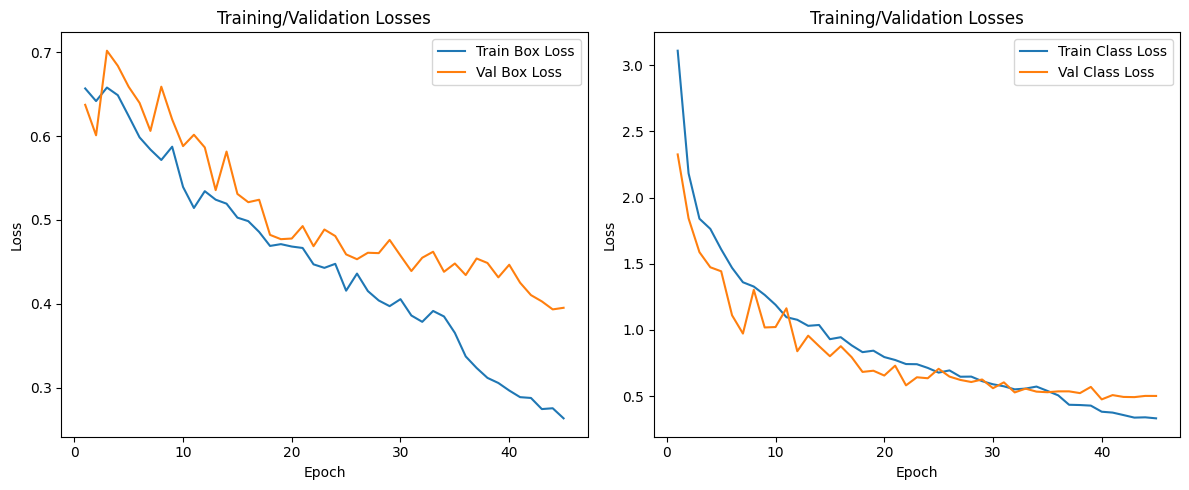

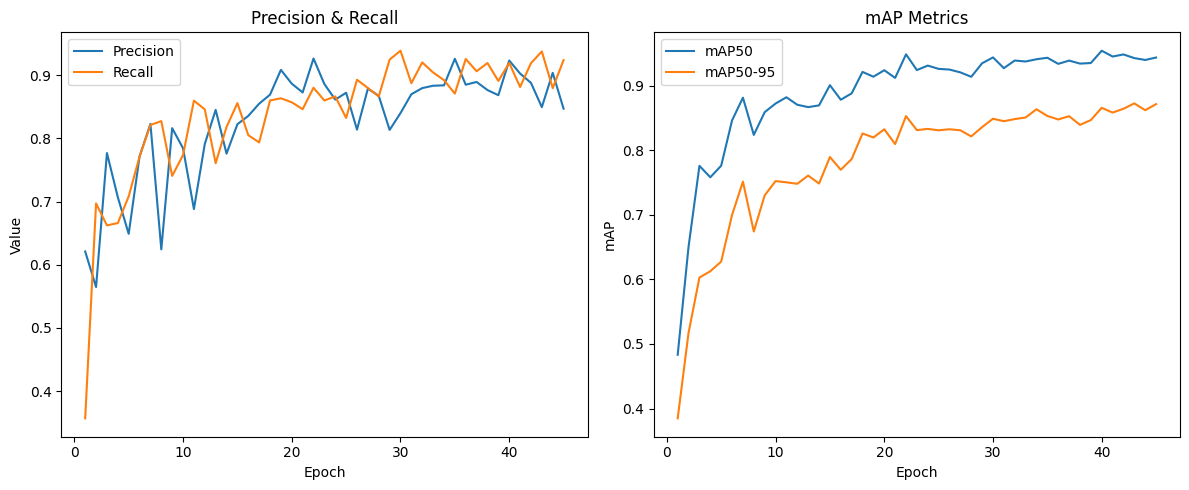

In [19]:
# 4. Анализ метрик
metrics_img_path = plot_training_metrics()

## image detection

In [20]:
pred_img_path = visualize_predictions(model, DEFAULT_YOLO_DIR, num_samples=5)

Output hidden; open in https://colab.research.google.com to view.

## full detection to df

In [21]:
detections_df = run_detection_on_dataset(model, DEFAULT_DATA_DIR)

Running detection:   0%|          | 0/935 [00:00<?, ?it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_58.jpg: 640x384 1 sv-5, 35.5ms
Speed: 1.8ms preprocess, 35.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_7.jpg: 640x480 1 shta-9, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0016.jpeg: 480x640 1 shta-7m, 1 e2-6u, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   0%|          | 3/935 [00:00<00:36, 25.43it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0070.jpg: 480x640 1 shta-3, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_28.jpeg: 480x640 1 e2-6u, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_49.jpeg: 480x640 1 e2-6u, 6.3ms
Speed: 2.3ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0113.jpg: 640x480 1 shta-9m, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   1%|          | 7/935 [00:00<00:28, 32.43it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_24.jpg: 640x384 1 sv-5, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0108.jpg: 640x480 1 shta-9m, 7.5ms
Speed: 3.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_21.jpeg: 640x480 1 sv-5, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0032.jpg: 640x480 1 sv-5, 9.5ms
Speed: 2.6ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   1%|          | 11/935 [00:00<00:52, 17.74it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0201.jpg: 384x640 1 shta-3, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0027.jpeg: 576x640 1 e2-6u, 37.3ms
Speed: 2.9ms preprocess, 37.3ms inference, 1.5ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0233.jpg: 384x640 1 shta-3, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:   1%|▏         | 14/935 [00:00<00:44, 20.59it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_78.jpg: 640x480 1 sv-5, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_29.jpg: 640x384 1 sv-5, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_37.jpeg: 480x640 1 e2-6u, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   2%|▏         | 17/935 [00:00<00:42, 21.54it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0120.jpg: 480x640 1 shta-3, 10.3ms
Speed: 2.0ms preprocess, 10.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_67.jpg: 640x480 1 sv-5, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0172.jpg: 640x480 1 shta-3, 6.3ms
Speed: 2.3ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0005.jpeg: 384x640 1 e2-6u, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:   2%|▏         | 21/935 [00:00<00:36, 25.14it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_43.jpeg: 640x480 1 e2-6u, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0030.jpg: 640x480 1 sv-5, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_97.JPG: 480x640 1 shta-7m, 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   3%|▎         | 24/935 [00:01<00:38, 23.71it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_29.JPG: 480x640 1 shta-ps, 6.2ms
Speed: 2.6ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_63.jpg: 320x640 1 shta-7m, 36.7ms
Speed: 2.2ms preprocess, 36.7ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_26.jpg: 640x384 1 sv-5, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


Running detection:   3%|▎         | 27/935 [00:01<00:46, 19.69it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0005.jpg: 512x640 1 shta-ps, 37.5ms
Speed: 3.4ms preprocess, 37.5ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0167.jpg: 480x640 1 shta-3, 6.9ms
Speed: 2.5ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0005.jpg: 480x640 1 shta-3, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   3%|▎         | 30/935 [00:01<01:21, 11.10it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0192.jpg: 640x480 1 shta-9, 8.2ms
Speed: 3.9ms preprocess, 8.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_3.jpg: 640x480 1 shta-9, 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   3%|▎         | 32/935 [00:01<01:13, 12.23it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_37.jpeg: 640x480 1 shta-9m, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_56.jpg: 320x640 1 shta-7m, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_15.jpg: 640x480 1 shta-7m, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0032.jpg: 512x640 1 shta-9m, 1 shta-ps, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


Running detection:   4%|▍         | 36/935 [00:02<00:56, 15.98it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0157.jpg: 640x480 1 shta-3, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0194.jpg: 480x640 1 shta-3, 7.5ms
Speed: 3.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_41.jpeg: 480x640 1 shta-7m, 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   4%|▍         | 39/935 [00:02<00:58, 15.29it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_21.jpg: 480x640 1 shta-7m, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0122.jpg: 640x480 1 shta-9, 1 shta-3, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0045.jpg: 640x480 1 shta-7m, 6.0ms
Speed: 2.0ms preprocess, 6.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0295.jpg: 640x448 1 shta-3, 36.6ms
Speed: 2.9ms preprocess, 36.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


Running detection:   5%|▍         | 43/935 [00:02<00:51, 17.23it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_6.jpeg: 384x640 1 e2-6u, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0030.jpg: 288x640 1 shta-ps, 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0023.jpg: 480x640 2 shta-9s, 1 shta-3, 7.7ms
Speed: 2.4ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   5%|▍         | 46/935 [00:02<00:45, 19.48it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0023.jpg: 640x480 1 sv-5, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0252.jpg: 384x640 1 shta-7m, 8.6ms
Speed: 2.0ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_50.jpg: 640x480 1 shta-9, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   5%|▌         | 49/935 [00:02<00:41, 21.31it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0183.jpg: 512x640 1 shta-9m, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0264.jpg: 640x480 1 shta-3, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_11.jpg: 640x480 1 shta-9, 6.1ms
Speed: 2.6ms preprocess, 6.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_8.jpeg: 480x640 1 e2-6u, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   6%|▌         | 53/935 [00:02<00:35, 24.89it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_96.jpg: 640x384 1 shta-7m, 6.9ms
Speed: 1.6ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0222.jpg: 480x640 1 shta-3, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_10.jpg: 640x480 1 shta-7m, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_12.jpeg: 480x640 1 e2-6u, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   6%|▌         | 57/935 [00:02<00:31, 27.72it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_41.jpg: 640x480 1 shta-9, 8.5ms
Speed: 4.0ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0128.jpg: 640x384 (no detections), 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_23.JPG: 480x640 1 shta-ps, 7.2ms
Speed: 3.1ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0160.jpg: 384x640 1 shta-9m, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:   7%|▋         | 61/935 [00:03<00:33, 26.34it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_51.jpeg: 480x640 1 shta-7m, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_64.jpg: 320x640 1 shta-7m, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0011.jpeg: 480x640 1 e2-6u, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_56.jpg: 640x480 1 shta-9, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   7%|▋         | 65/935 [00:03<00:29, 29.02it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0213.jpg: 640x480 1 shta-3, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0226.jpg: 640x480 1 shta-3, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0006.jpeg: 384x640 1 e2-6u, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0271.jpg: 384x640 1 shta-3, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0260.jpg: 480x640 1 shta-3, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   7%|▋         | 70/935 [00:03<00:26, 32.89it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0027.jpg: 640x288 1 shta-9, 35.4ms
Speed: 1.7ms preprocess, 35.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_32.jpg: 640x480 1 shta-9, 1 shta-3, 7.1ms
Speed: 3.8ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0131.jpg: 640x480 1 shta-7m, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_70.jpg: 480x640 1 e2-6u, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   8%|▊         | 74/935 [00:03<00:29, 29.42it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0071.jpg: 480x640 1 shta-3, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_37.jpg: 384x640 1 shta-ps, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_32.jpg: 640x384 1 sv-5, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_27.jpg: 640x480 1 shta-9m, 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   8%|▊         | 78/935 [00:03<00:31, 27.17it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0016.jpg: 480x640 2 shta-9s, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0242.jpg: 640x480 1 shta-9m, 7.5ms
Speed: 3.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0019.jpeg: 640x480 1 sv-5, 6.3ms
Speed: 2.3ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   9%|▊         | 81/935 [00:03<00:38, 22.08it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_35.jpeg: 640x480 1 shta-9m, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_57.jpeg: 480x640 1 e2-6u, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_49.jpg: 640x384 1 sv-5, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:   9%|▉         | 84/935 [00:03<00:38, 22.37it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_33.jpeg: 640x480 1 shta-9m, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0134.jpg: 480x640 1 shta-7m, 7.6ms
Speed: 3.0ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_32.jpeg: 640x480 1 shta-9m, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   9%|▉         | 87/935 [00:04<00:39, 21.38it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_95.jpg: 480x640 1 shta-7m, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0147.jpg: 640x640 1 shta-3, 8.0ms
Speed: 3.7ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_52.jpg: 640x480 1 shta-9, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_12.jpg: 640x480 1 shta-7m, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  10%|▉         | 91/935 [00:04<00:35, 23.70it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_27.jpg: 640x384 1 sv-5, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0012.jpg: 480x640 1 shta-7m, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0257.jpg: 640x480 1 shta-9m, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  10%|█         | 94/935 [00:04<00:43, 19.45it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_36.jpeg: 480x640 1 e2-6u, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0126.jpg: 640x480 2 shta-9ms, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_49.jpeg: 480x640 1 shta-7m, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  10%|█         | 97/935 [00:04<00:40, 20.55it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0105.jpg: 480x640 1 shta-3, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_3.jpg: 480x640 1 shta-ps, 6.3ms
Speed: 2.4ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_9.JPG: 640x480 1 shta-9m, 7.7ms
Speed: 4.3ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0231.jpg: 384x640 1 shta-3, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  11%|█         | 101/935 [00:04<00:34, 24.12it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_5.jpg: 640x480 1 shta-9, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0054.jpg: 640x480 1 shta-3, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_68.jpg: 480x640 1 shta-ps, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  11%|█         | 104/935 [00:04<00:33, 24.76it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0041.jpg: 640x480 1 shta-3, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_4.jpeg: 640x480 1 sv-5, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0022.jpg: 288x640 1 shta-ps, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_41.jpeg: 640x480 1 shta-9m, 1 sv-5, 14.4ms
Speed: 2.8ms preprocess, 14.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  12%|█▏        | 108/935 [00:04<00:32, 25.46it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_24.jpeg: 480x640 1 e2-6u, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_14.jpg: 480x640 1 shta-9m, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_10.jpeg: 640x480 1 sv-5, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0116.jpg: 480x640 1 shta-9m, 2 shta-7ms, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  12%|█▏        | 112/935 [00:05<00:28, 28.57it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_44.jpg: 480x640 1 shta-ps, 2 shta-3s, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0195.jpg: 384x640 1 shta-9, 1 shta-3, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0026.jpg: 640x640 1 sv-5, 8.1ms
Speed: 3.3ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_5.jpeg: 480x640 1 e2-6u, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  12%|█▏        | 116/935 [00:05<00:26, 30.36it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_71.jpeg: 640x480 1 shta-7m, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0181.jpg: 640x384 1 shta-9, 1 shta-3, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_17.jpeg: 480x640 1 e2-6u, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0243.jpg: 640x480 1 shta-9m, 7.6ms
Speed: 3.2ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  13%|█▎        | 120/935 [00:05<00:30, 26.52it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_7.jpeg: 640x480 1 sv-5, 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0300.jpg: 480x640 1 shta-3, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0016.jpg: 640x640 1 shta-3, 8.1ms
Speed: 3.1ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Running detection:  13%|█▎        | 123/935 [00:05<00:30, 26.75it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_49.jpeg: 640x480 1 shta-9m, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0276.jpg: 640x480 1 shta-9m, 10.7ms
Speed: 4.2ms preprocess, 10.7ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_24.jpg: 640x480 1 shta-9m, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  13%|█▎        | 126/935 [00:05<00:34, 23.26it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_65.jpg: 384x640 1 shta-ps, 11.6ms
Speed: 1.7ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_41.jpg: 480x640 2 shta-9ms, 1 shta-ps, 1 shta-7m, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0037.jpg: 448x640 1 shta-ps, 34.8ms
Speed: 2.2ms preprocess, 34.8ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)


Running detection:  14%|█▍        | 129/935 [00:05<00:34, 23.42it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_53.jpeg: 640x480 1 shta-7m, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0004.jpg: 480x640 1 shta-3, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_85.jpg: 480x640 1 shta-9, 10.1ms
Speed: 5.7ms preprocess, 10.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  14%|█▍        | 132/935 [00:06<00:43, 18.54it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0256.jpg: 480x640 1 e2-6u, 9.5ms
Speed: 3.5ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_47.jpeg: 640x480 1 shta-9m, 12.3ms
Speed: 2.5ms preprocess, 12.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_91.jpg: 480x640 1 shta-7m, 13.5ms
Speed: 2.7ms preprocess, 13.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  14%|█▍        | 135/935 [00:06<00:41, 19.47it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_34.jpeg: 640x480 1 shta-9m, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_46.JPG: 640x480 1 shta-9m, 9.4ms
Speed: 2.5ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_20.jpg: 640x480 1 shta-9m, 7.7ms
Speed: 2.6ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  15%|█▍        | 138/935 [00:06<00:36, 21.68it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0138.jpg: 640x384 1 shta-7m, 9.6ms
Speed: 2.5ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_7.jpg: 640x480 1 shta-7m, 14.7ms
Speed: 2.7ms preprocess, 14.7ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0065.jpg: 480x640 1 shta-3, 15.0ms
Speed: 2.8ms preprocess, 15.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  15%|█▌        | 141/935 [00:06<00:36, 21.60it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0031.jpg: 640x480 1 shta-ps, 1 shta-9, 9.7ms
Speed: 2.7ms preprocess, 9.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0003.jpg: 640x384 1 shta-ps, 1 shta-9, 11.5ms
Speed: 2.7ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_27.jpeg: 480x640 1 e2-6u, 9.3ms
Speed: 3.8ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  15%|█▌        | 144/935 [00:06<00:36, 21.41it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0039.jpg: 288x640 1 shta-ps, 9.4ms
Speed: 2.5ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0064.jpg: 640x480 1 shta-3, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0280.jpg: 640x480 1 shta-9m, 8.7ms
Speed: 4.5ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  16%|█▌        | 147/935 [00:06<00:42, 18.35it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0282.jpg: 640x480 1 shta-9m, 12.1ms
Speed: 7.5ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_51.jpg: 640x480 1 shta-9, 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  16%|█▌        | 149/935 [00:07<01:02, 12.59it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_13.JPG: 480x640 1 shta-9m, 8.5ms
Speed: 3.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0179.jpg: 640x512 1 shta-9m, 1 shta-9, 53.3ms
Speed: 3.0ms preprocess, 53.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


Running detection:  16%|█▌        | 151/935 [00:07<01:00, 13.06it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0010.jpeg: 480x640 1 sv-5, 8.6ms
Speed: 3.7ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_77.jpg: 640x480 1 shta-9, 1 shta-3, 8.8ms
Speed: 2.6ms preprocess, 8.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0008.jpg: 640x480 1 sv-5, 7.9ms
Speed: 2.6ms preprocess, 7.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  16%|█▋        | 154/935 [00:07<00:52, 14.90it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_66.jpg: 640x480 1 shta-9, 8.0ms
Speed: 2.6ms preprocess, 8.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_38.jpg: 640x384 1 sv-5, 13.2ms
Speed: 3.4ms preprocess, 13.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  17%|█▋        | 156/935 [00:07<00:54, 14.41it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_32.JPG: 480x640 1 shta-7m, 9.4ms
Speed: 4.5ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0178.jpg: 320x640 1 shta-3, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)


Running detection:  17%|█▋        | 158/935 [00:07<01:01, 12.55it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_67.jpg: 640x480 1 shta-ps, 14.2ms
Speed: 4.2ms preprocess, 14.2ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0196.jpg: 480x640 1 shta-3, 11.5ms
Speed: 4.7ms preprocess, 11.5ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  17%|█▋        | 160/935 [00:08<01:13, 10.56it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0299.jpg: 640x512 1 shta-3, 16.1ms
Speed: 7.2ms preprocess, 16.1ms inference, 8.2ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0142.jpg: 640x480 1 shta-9m, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  17%|█▋        | 162/935 [00:08<01:20,  9.56it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0082.jpg: 512x640 1 shta-3, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_13.jpeg: 480x640 1 shta-9m, 1 e2-6u, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_47.jpeg: 480x640 1 shta-7m, 6.2ms
Speed: 2.1ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0124.jpg: 640x384 1 shta-9, 1 shta-3, 7.6ms
Speed: 2.5ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  18%|█▊        | 166/935 [00:08<01:00, 12.77it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0118.jpg: 640x384 1 shta-3, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_16.jpg: 640x480 1 shta-9, 7.8ms
Speed: 2.7ms preprocess, 7.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  18%|█▊        | 168/935 [00:08<00:57, 13.40it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0036.jpg: 384x640 1 shta-9, 1 shta-3, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_17.jpg: 640x480 1 shta-9, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_59.jpeg: 480x640 1 e2-6u, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_42.jpg: 640x384 1 sv-5, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  18%|█▊        | 172/935 [00:08<00:46, 16.44it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0002.jpg: 480x640 1 shta-9, 7.5ms
Speed: 3.3ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_2.jpg: 640x384 1 sv-5, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  19%|█▊        | 174/935 [00:09<01:10, 10.83it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_68.jpg: 640x480 1 sv-5, 9.0ms
Speed: 2.7ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0265.jpg: 640x384 1 shta-9m, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_84.jpg: 640x480 1 sv-5, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  19%|█▉        | 177/935 [00:09<00:56, 13.38it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0089.jpg: 480x640 1 shta-3, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0007.jpeg: 640x480 1 sv-5, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0145.jpg: 640x480 1 shta-9m, 7.0ms
Speed: 3.2ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  19%|█▉        | 180/935 [00:09<01:03, 11.95it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_54.jpg: 640x480 1 shta-9, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0058.jpg: 384x640 1 shta-7m, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_39.jpg: 640x480 1 shta-9, 1 shta-3, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0072.jpg: 480x640 1 shta-3, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  20%|█▉        | 184/935 [00:09<00:48, 15.64it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0169.jpg: 480x640 1 shta-3, 6.3ms
Speed: 2.5ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_73.jpg: 640x480 1 sv-5, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0127.jpg: 544x640 1 shta-3, 36.6ms
Speed: 3.1ms preprocess, 36.6ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)


Running detection:  20%|██        | 187/935 [00:09<00:46, 16.25it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0006.jpg: 480x640 1 shta-3, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0024.jpg: 480x640 1 shta-3, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_29.jpeg: 480x640 1 e2-6u, 6.3ms
Speed: 2.5ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  20%|██        | 190/935 [00:09<00:40, 18.35it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_33.jpg: 640x480 1 shta-ps, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0294.jpg: 480x640 1 shta-9m, 6.9ms
Speed: 2.7ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0254.jpg: 512x640 1 sv-5, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  21%|██        | 193/935 [00:10<00:38, 19.32it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_40.jpg: 640x384 1 sv-5, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_8.JPG: 480x640 1 shta-9m, 14.2ms
Speed: 2.6ms preprocess, 14.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0287.jpg: 480x640 1 shta-3, 11.1ms
Speed: 2.9ms preprocess, 11.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  21%|██        | 196/935 [00:10<00:35, 20.75it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_90.jpg: 480x640 1 shta-7m, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_66.jpeg: 384x640 1 e2-6u, 8.7ms
Speed: 2.0ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0044.jpg: 640x480 1 shta-9, 1 shta-3, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_1.jpg: 512x640 1 shta-9m, 1 shta-ps, 7.5ms
Speed: 2.7ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  21%|██▏       | 200/935 [00:10<00:31, 23.57it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_22.jpeg: 480x640 1 e2-6u, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_38.jpeg: 480x640 1 shta-7m, 6.3ms
Speed: 2.5ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_67.jpeg: 384x640 1 e2-6u, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0230.jpg: 640x480 1 shta-3, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_9.jpeg: 480x640 1 shta-9m, 1 e2-6u, 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480,

Running detection:  22%|██▏       | 205/935 [00:10<00:25, 28.31it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0006.jpeg: 640x480 1 sv-5, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_62.jpg: 640x480 1 shta-9, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_28.JPG: 480x640 1 shta-ps, 6.8ms
Speed: 2.6ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_18.jpg: 320x640 1 shta-7m, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


Running detection:  22%|██▏       | 209/935 [00:10<00:25, 28.93it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_48.jpeg: 640x480 1 shta-9m, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0267.jpg: 384x640 1 shta-3, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0061.jpg: 640x480 1 shta-3, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0042.jpg: 640x480 1 shta-3, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  23%|██▎       | 213/935 [00:10<00:25, 28.13it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0004.jpeg: 480x640 1 e2-6u, 7.1ms
Speed: 3.6ms preprocess, 7.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0032.jpg: 640x480 1 shta-9, 2 shta-3s, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_24.jpg: 640x480 1 shta-9, 1 shta-3, 9.4ms
Speed: 4.0ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  23%|██▎       | 216/935 [00:10<00:26, 27.60it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_73.jpg: 640x640 1 shta-9, 10.1ms
Speed: 4.0ms preprocess, 10.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_60.jpg: 480x640 1 shta-7m, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0084.jpg: 640x480 1 shta-9, 1 shta-3, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  23%|██▎       | 219/935 [00:11<00:28, 24.97it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0026.jpg: 480x640 1 shta-ps, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0176.jpg: 640x480 1 shta-9m, 1 shta-7m, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0278.jpg: 640x480 1 shta-9m, 6.3ms
Speed: 2.8ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  24%|██▎       | 222/935 [00:11<00:30, 23.75it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0081.jpg: 640x480 1 shta-3, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_38.jpg: 640x480 1 shta-9, 13.0ms
Speed: 2.5ms preprocess, 13.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0026.jpg: 640x384 1 sv-5, 7.7ms
Speed: 2.1ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  24%|██▍       | 225/935 [00:11<00:28, 24.82it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0296.jpg: 640x384 1 shta-3, 9.2ms
Speed: 2.3ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_77.jpg: 640x480 1 sv-5, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0091.jpg: 384x640 1 shta-3, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_31.JPG: 480x640 1 shta-9m, 7.9ms
Speed: 3.7ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  24%|██▍       | 229/935 [00:11<00:24, 28.43it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0024.jpg: 480x640 1 shta-ps, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0253.jpg: 640x480 1 shta-9m, 7.5ms
Speed: 3.1ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_43.jpg: 480x640 2 shta-pss, 1 shta-9, 1 shta-3, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  25%|██▍       | 232/935 [00:11<00:33, 20.78it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0203.jpg: 384x640 1 shta-3, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_30.JPG: 480x640 1 shta-ps, 6.9ms
Speed: 2.6ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_34.jpeg: 480x640 1 e2-6u, 6.2ms
Speed: 2.4ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0158.jpg: 640x480 1 shta-9m, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  25%|██▌       | 236/935 [00:11<00:32, 21.65it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0034.jpg: 480x640 1 shta-9m, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_74.jpg: 640x480 1 sv-5, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_4.jpg: 640x640 1 shta-ps, 8.2ms
Speed: 3.5ms preprocess, 8.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)


Running detection:  26%|██▌       | 239/935 [00:11<00:31, 21.91it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_75.jpg: 640x480 1 shta-9, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0038.jpg: 640x480 1 shta-3, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0019.jpg: 480x640 1 shta-ps, 1 shta-9, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  26%|██▌       | 242/935 [00:12<00:29, 23.34it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0291.jpg: 640x480 1 shta-9m, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0168.jpg: 480x640 1 shta-3, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_51.jpeg: 640x480 1 shta-9m, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  26%|██▌       | 245/935 [00:12<00:30, 22.68it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0206.jpg: 384x640 1 shta-3, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_18.jpg: 384x640 1 shta-9m, 6.2ms
Speed: 1.5ms preprocess, 6.2ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0207.jpg: 640x480 1 shta-7m, 11.8ms
Speed: 2.5ms preprocess, 11.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0027.jpg: 640x480 1 shta-3, 6.1ms
Speed: 2.0ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  27%|██▋       | 249/935 [00:12<00:27, 24.52it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0223.jpg: 640x480 1 shta-3, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0162.jpg: 640x480 1 shta-7m, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0029.jpg: 288x640 1 shta-ps, 1 shta-9, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0244.jpg: 384x640 1 shta-3, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  27%|██▋       | 253/935 [00:12<00:24, 27.64it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0191.jpg: 384x640 1 shta-3, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_10.jpg: 640x480 1 shta-9, 1 shta-3, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_87.jpg: 640x480 1 shta-9, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  27%|██▋       | 256/935 [00:12<00:24, 27.86it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_17.jpg: 640x480 1 shta-9m, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0030.jpg: 512x640 1 sv-5, 10.8ms
Speed: 2.3ms preprocess, 10.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0197.jpg: 384x640 1 shta-3, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_25.jpg: 640x384 1 sv-5, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  28%|██▊       | 260/935 [00:12<00:26, 25.93it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_44.jpeg: 480x640 1 shta-9m, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0001.jpg: 640x512 1 shta-ps, 1 shta-9, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0022.jpg: 640x480 1 sv-5, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  28%|██▊       | 263/935 [00:12<00:25, 26.31it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_38.jpg: 640x320 1 shta-ps, 1 shta-9, 35.7ms
Speed: 1.4ms preprocess, 35.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_1.jpg: 640x480 1 shta-3, 6.9ms
Speed: 2.7ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_27.JPG: 480x640 1 shta-ps, 6.8ms
Speed: 2.7ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  28%|██▊       | 266/935 [00:13<00:29, 22.96it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_25.jpg: 640x480 1 shta-9, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0029.jpg: 480x640 1 shta-9, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_63.jpg: 640x480 1 shta-9, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  29%|██▉       | 269/935 [00:13<00:28, 23.42it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_56.jpeg: 480x640 1 e2-6u, 7.4ms
Speed: 3.6ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_20.jpg: 480x640 1 shta-7m, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_47.jpg: 640x480 1 shta-9, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0015.jpg: 640x512 1 shta-9, 1 shta-3, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


Running detection:  29%|██▉       | 273/935 [00:13<00:26, 25.31it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_45.jpeg: 640x480 1 shta-9m, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_19.jpeg: 384x640 1 e2-6u, 8.8ms
Speed: 2.0ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_50.jpg: 480x640 1 shta-ps, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  30%|██▉       | 276/935 [00:13<00:25, 26.15it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_16.jpg: 320x640 1 shta-7m, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_35.jpg: 480x640 1 shta-7m, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0227.jpg: 480x640 1 shta-9m, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0290.jpg: 640x480 1 shta-3, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  30%|██▉       | 280/935 [00:13<00:22, 28.81it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_33.jpeg: 480x640 1 e2-6u, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0063.jpg: 640x480 1 shta-3, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_26.jpg: 640x480 1 shta-9, 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0002.jpeg: 480x640 1 e2-6u, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  30%|███       | 284/935 [00:13<00:21, 30.74it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0020.jpg: 480x640 1 shta-9, 1 shta-3, 7.0ms
Speed: 3.1ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0028.jpg: 640x480 1 sv-5, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_33.jpg: 384x640 1 shta-7m, 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0007.jpg: 480x640 1 shta-9, 1 shta-3, 7.6ms
Speed: 2.0ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  31%|███       | 288/935 [00:13<00:23, 27.33it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_2.jpeg: 480x640 1 e2-6u, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_19.jpg: 320x640 1 shta-7m, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0020.jpeg: 480x640 1 e2-6u, 6.8ms
Speed: 2.5ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0040.jpg: 480x640 2 shta-pss, 6.2ms
Speed: 2.7ms preprocess, 6.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  31%|███       | 292/935 [00:13<00:22, 28.14it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_19.jpeg: 640x480 1 sv-5, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_39.jpg: 640x384 1 sv-5, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_5.jpeg: 640x480 1 sv-5, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  32%|███▏      | 295/935 [00:14<00:23, 26.80it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_35.jpg: 640x384 1 sv-5, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0027.jpg: 480x640 1 shta-9m, 1 shta-ps, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0210.jpg: 384x640 1 shta-7m, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  32%|███▏      | 298/935 [00:14<00:24, 25.50it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_64.jpg: 640x480 1 shta-ps, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_14.jpg: 640x480 1 shta-9, 1 shta-3, 6.2ms
Speed: 2.5ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0056.jpg: 640x480 1 shta-3, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  32%|███▏      | 301/935 [00:14<00:25, 24.92it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_2.jpeg: 320x640 1 e2-6u, 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_20.jpeg: 640x480 1 sv-5, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0234.jpg: 640x384 1 shta-9, 9.6ms
Speed: 3.2ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0171.jpg: 640x640 1 shta-7m, 8.2ms
Speed: 3.8ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Running detection:  33%|███▎      | 305/935 [00:14<00:24, 25.27it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_40.jpeg: 480x640 1 shta-7m, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0035.jpg: 640x480 1 shta-9, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0101.jpg: 640x480 1 shta-9m, 8.1ms
Speed: 4.0ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  33%|███▎      | 308/935 [00:14<00:28, 21.82it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0001.jpeg: 480x640 1 e2-6u, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0019.jpg: 640x480 2 sv-5s, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0014.jpeg: 480x640 1 sv-5, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_36.jpg: 416x640 1 shta-7m, 36.1ms
Speed: 2.7ms preprocess, 36.1ms inference, 1.5ms postprocess per image at shape (1, 3, 416, 640)


Running detection:  33%|███▎      | 312/935 [00:14<00:26, 23.74it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_46.jpg: 640x384 1 sv-5, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_45.jpg: 640x480 1 shta-9, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0037.jpg: 640x480 1 shta-3, 9.4ms
Speed: 1.9ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  34%|███▎      | 315/935 [00:14<00:26, 23.36it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0019.jpg: 640x288 1 shta-9, 1 shta-3, 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0033.jpg: 480x640 2 shta-9s, 1 shta-3, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0218.jpg: 480x640 1 shta-3, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  34%|███▍      | 318/935 [00:15<00:25, 24.34it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_52.jpeg: 480x640 1 e2-6u, 6.5ms
Speed: 2.9ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_23.jpg: 640x480 1 shta-9, 6.9ms
Speed: 2.6ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_4.jpg: 640x480 1 shta-7m, 1 shta-3, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0020.jpg: 640x480 1 shta-ps, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  34%|███▍      | 322/935 [00:15<00:23, 26.28it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_39.jpg: 512x640 1 shta-ps, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0283.jpg: 480x640 1 shta-3, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_60.jpeg: 640x480 1 shta-9m, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0018.jpeg: 640x480 1 sv-5, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  35%|███▍      | 326/935 [00:15<00:21, 28.18it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_56.jpeg: 640x480 1 shta-9m, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_79.jpg: 480x640 1 shta-9, 1 shta-3, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_68.jpg: 640x480 1 shta-9, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  35%|███▌      | 329/935 [00:15<00:26, 22.66it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_52.JPG: 512x640 1 shta-ps, 9.1ms
Speed: 3.4ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_22.jpg: 640x480 1 shta-3, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_57.jpg: 640x384 1 sv-5, 9.9ms
Speed: 2.0ms preprocess, 9.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0182.jpg: 384x640 1 shta-7m, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  36%|███▌      | 333/935 [00:15<00:23, 26.17it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_33.jpg: 640x384 1 sv-5, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_23.jpg: 480x640 1 shta-7m, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_40.jpg: 640x480 1 shta-9, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  36%|███▌      | 336/935 [00:15<00:23, 25.17it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_8.JPG: 480x640 1 shta-ps, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_48.jpeg: 480x640 1 shta-7m, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_69.jpeg: 480x640 2 shta-7ms, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  36%|███▋      | 339/935 [00:15<00:24, 24.56it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_37.jpg: 640x384 1 sv-5, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0247.jpg: 640x480 1 shta-9m, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0010.jpg: 640x480 1 shta-ps, 8.4ms
Speed: 2.7ms preprocess, 8.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  37%|███▋      | 342/935 [00:15<00:25, 23.26it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_17.jpg: 640x480 1 shta-7m, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_8.jpeg: 480x640 1 sv-5, 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_40.jpg: 480x640 1 shta-ps, 1 shta-9, 1 shta-3, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  37%|███▋      | 345/935 [00:16<00:24, 24.10it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_28.jpg: 640x480 1 shta-9, 6.9ms
Speed: 2.6ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_40.jpeg: 640x480 1 shta-9m, 1 sv-5, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_9.JPG: 480x640 1 shta-ps, 6.9ms
Speed: 2.7ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  37%|███▋      | 348/935 [00:16<00:25, 22.71it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_99.jpg: 640x480 1 shta-7m, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_78.jpeg: 480x640 1 shta-7m, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_33.jpg: 640x480 1 shta-9, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  38%|███▊      | 351/935 [00:16<00:24, 24.17it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0009.jpg: 640x480 1 shta-ps, 7.6ms
Speed: 3.9ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0248.jpg: 640x480 1 shta-9m, 6.6ms
Speed: 3.0ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_19.jpg: 640x480 1 shta-9, 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  38%|███▊      | 354/935 [00:16<00:45, 12.78it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_17.JPG: 480x640 1 shta-ps, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_68.jpeg: 480x640 1 shta-9m, 1 shta-7m, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  38%|███▊      | 356/935 [00:16<00:43, 13.45it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0043.jpg: 640x480 1 shta-3, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_27.jpg: 480x640 1 shta-7m, 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_85.jpeg: 384x640 1 shta-7m, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  38%|███▊      | 359/935 [00:17<00:35, 16.16it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0013.jpg: 480x640 1 shta-3, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_60.jpeg: 480x640 1 shta-9m, 1 e2-6u, 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0144.jpg: 640x480 1 shta-9m, 7.5ms
Speed: 3.2ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  39%|███▊      | 362/935 [00:17<00:39, 14.64it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_34.jpg: 640x480 1 shta-9, 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0102.jpg: 288x640 1 shta-3, 7.8ms
Speed: 2.4ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_15.jpg: 480x640 1 shta-9m, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_44.jpeg: 640x480 1 e2-6u, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  39%|███▉      | 366/935 [00:17<00:30, 18.64it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_19.JPG: 480x640 1 shta-ps, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_4.jpeg: 480x640 1 e2-6u, 6.7ms
Speed: 2.3ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_87.jpg: 480x640 1 shta-7m, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  39%|███▉      | 369/935 [00:17<00:30, 18.86it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_61.jpg: 640x480 1 shta-9m, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0250.jpg: 384x640 1 shta-7m, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0029.jpg: 640x480 1 sv-5, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_5.jpeg: 480x640 1 e2-6u, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  40%|███▉      | 373/935 [00:17<00:25, 22.35it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_26.jpg: 480x640 1 shta-7m, 9.6ms
Speed: 2.5ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_15.jpg: 640x480 1 shta-9, 7.3ms
Speed: 2.5ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_46.jpeg: 480x640 1 shta-7m, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0024.jpeg: 480x640 1 shta-9m, 1 e2-6u, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  40%|████      | 377/935 [00:17<00:22, 25.20it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0225.jpg: 640x480 1 shta-3, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0209.jpg: 640x480 1 shta-3, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_39.jpeg: 480x640 1 shta-7m, 7.0ms
Speed: 2.9ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0067.jpg: 480x640 1 shta-3, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  41%|████      | 381/935 [00:17<00:20, 27.36it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_18.JPG: 480x640 1 shta-ps, 6.4ms
Speed: 2.7ms preprocess, 6.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0208.jpg: 384x640 1 shta-7m, 7.1ms
Speed: 3.1ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0013.jpeg: 480x640 1 e2-6u, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  41%|████      | 384/935 [00:18<00:21, 25.96it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_38.jpeg: 480x640 1 e2-6u, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0046.jpg: 640x480 1 shta-3, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0268.jpg: 384x640 1 shta-3, 7.5ms
Speed: 2.1ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_3.jpeg: 480x640 1 e2-6u, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0262.jpg: 480x640 1 shta-3, 6.2ms
Speed: 2.4ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  42%|████▏     | 389/935 [00:18<00:18, 30.13it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0130.jpg: 640x480 1 shta-7m, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_61.jpg: 640x480 3 shta-9s, 1 shta-3, 11.9ms
Speed: 2.6ms preprocess, 11.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0125.jpg: 384x640 1 shta-3, 12.1ms
Speed: 3.3ms preprocess, 12.1ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0027.jpg: 480x640 1 sv-5, 12.4ms
Speed: 3.7ms preprocess, 12.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  42%|████▏     | 393/935 [00:18<00:19, 27.44it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_21.jpeg: 640x480 1 e2-6u, 11.0ms
Speed: 3.5ms preprocess, 11.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_9.jpg: 480x640 1 shta-9, 12.6ms
Speed: 9.2ms preprocess, 12.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0044.jpg: 480x640 1 shta-9m, 1 shta-ps, 10.6ms
Speed: 4.7ms preprocess, 10.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  42%|████▏     | 396/935 [00:18<00:21, 24.95it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_35.jpg: 640x480 1 shta-9, 8.7ms
Speed: 4.1ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_13.jpg: 640x480 1 shta-7m, 13.2ms
Speed: 3.0ms preprocess, 13.2ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_66.JPG: 480x640 1 shta-ps, 13.1ms
Speed: 4.0ms preprocess, 13.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  43%|████▎     | 399/935 [00:18<00:22, 23.69it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_50.jpeg: 480x640 1 e2-6u, 12.6ms
Speed: 3.6ms preprocess, 12.6ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0075.jpg: 640x480 1 shta-3, 13.1ms
Speed: 7.6ms preprocess, 13.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0014.jpg: 480x640 1 shta-ps, 1 shta-7m, 10.0ms
Speed: 2.9ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  43%|████▎     | 402/935 [00:18<00:23, 22.69it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_1.jpg: 640x384 1 sv-5, 8.9ms
Speed: 4.6ms preprocess, 8.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_21.jpeg: 480x640 1 e2-6u, 8.6ms
Speed: 3.8ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0155.jpg: 640x480 1 shta-9m, 8.8ms
Speed: 4.1ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  43%|████▎     | 405/935 [00:18<00:24, 21.63it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0088.jpg: 640x480 1 shta-3, 8.3ms
Speed: 2.5ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_62.jpg: 640x480 1 sv-5, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0137.jpg: 640x480 1 shta-7m, 9.0ms
Speed: 4.5ms preprocess, 9.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  44%|████▎     | 408/935 [00:19<00:30, 17.49it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_28.jpg: 480x640 1 shta-7m, 9.4ms
Speed: 2.5ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_54.jpeg: 480x640 1 e2-6u, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0236.jpg: 384x640 1 shta-3, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_52.jpg: 384x640 1 sv-5, 8.4ms
Speed: 3.5ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  44%|████▍     | 412/935 [00:19<00:28, 18.66it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_9.jpeg: 480x640 1 sv-5, 9.5ms
Speed: 4.7ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_70.jpg: 640x480 1 shta-9, 8.4ms
Speed: 2.5ms preprocess, 8.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_18.jpg: 640x480 1 shta-9, 8.1ms
Speed: 4.1ms preprocess, 8.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  44%|████▍     | 415/935 [00:19<00:25, 20.53it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_44.jpg: 640x384 1 sv-5, 9.7ms
Speed: 3.3ms preprocess, 9.7ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0014.jpg: 384x640 1 shta-3, 11.0ms
Speed: 3.0ms preprocess, 11.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0151.jpg: 640x480 1 shta-9m, 8.7ms
Speed: 4.5ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  45%|████▍     | 418/935 [00:19<00:30, 17.23it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_68.jpeg: 384x640 1 e2-6u, 8.6ms
Speed: 3.0ms preprocess, 8.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_5.jpg: 640x480 1 shta-9m, 8.3ms
Speed: 4.1ms preprocess, 8.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_60.jpg: 640x480 1 shta-9, 7.7ms
Speed: 2.5ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  45%|████▌     | 421/935 [00:19<00:27, 18.75it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_64.jpg: 480x640 2 shta-9ms, 8.7ms
Speed: 2.6ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0270.jpg: 384x640 1 shta-3, 8.3ms
Speed: 3.1ms preprocess, 8.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0066.jpg: 512x640 1 shta-3, 11.2ms
Speed: 2.7ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  45%|████▌     | 424/935 [00:20<00:26, 19.60it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_61.jpg: 480x640 1 shta-7m, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0043.jpg: 288x640 1 shta-9m, 2 shta-pss, 12.5ms
Speed: 2.7ms preprocess, 12.5ms inference, 2.2ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_36.jpg: 640x384 1 sv-5, 12.6ms
Speed: 3.4ms preprocess, 12.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  46%|████▌     | 427/935 [00:20<00:28, 18.10it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_13.JPG: 480x640 1 shta-ps, 12.7ms
Speed: 4.2ms preprocess, 12.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_28.jpg: 640x384 1 sv-5, 13.8ms
Speed: 3.3ms preprocess, 13.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  46%|████▌     | 429/935 [00:20<00:33, 15.30it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0036.jpg: 288x640 1 shta-ps, 13.0ms
Speed: 2.7ms preprocess, 13.0ms inference, 1.5ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_61.jpg: 640x480 1 sv-5, 13.2ms
Speed: 2.7ms preprocess, 13.2ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  46%|████▌     | 431/935 [00:20<00:31, 15.94it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_36.jpg: 640x480 1 shta-9, 11.6ms
Speed: 3.5ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0259.jpg: 640x480 1 shta-9m, 14.3ms
Speed: 4.7ms preprocess, 14.3ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  46%|████▋     | 433/935 [00:20<00:36, 13.89it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_53.jpg: 384x640 1 sv-5, 14.4ms
Speed: 3.4ms preprocess, 14.4ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0069.jpg: 384x640 1 shta-3, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  47%|████▋     | 435/935 [00:20<00:34, 14.29it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0288.jpg: 640x480 1 shta-9m, 7.6ms
Speed: 3.1ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_36.JPG: 640x480 1 shta-9m, 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  47%|████▋     | 437/935 [00:21<00:35, 13.96it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0129.jpg: 640x384 1 shta-7m, 10.1ms
Speed: 2.3ms preprocess, 10.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_12.JPG: 480x640 1 shta-9m, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_60.jpg: 480x640 1 shta-ps, 6.1ms
Speed: 2.4ms preprocess, 6.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0095.jpg: 384x640 1 shta-9m, 1 shta-7m, 7.0ms
Speed: 1.6ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  47%|████▋     | 441/935 [00:21<00:25, 19.40it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0228.jpg: 640x480 1 shta-3, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_22.jpeg: 480x640 1 e2-6u, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0135.jpg: 480x640 1 shta-7m, 6.6ms
Speed: 3.0ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  47%|████▋     | 444/935 [00:21<00:27, 17.87it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_46.jpg: 480x640 1 shta-ps, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0010.jpg: 480x640 1 shta-ps, 1 shta-9, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_50.jpeg: 640x480 1 shta-9m, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  48%|████▊     | 447/935 [00:21<00:24, 19.60it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_25.jpg: 640x480 1 shta-9m, 8.4ms
Speed: 2.6ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_64.jpeg: 640x320 1 e2-6u, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0016.jpeg: 640x480 1 sv-5, 6.8ms
Speed: 2.4ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_24.jpg: 480x640 1 shta-7m, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  48%|████▊     | 451/935 [00:21<00:20, 23.67it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_80.jpg: 640x480 1 sv-5, 8.8ms
Speed: 2.2ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0006.jpg: 512x640 1 shta-ps, 7.8ms
Speed: 3.6ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0153.jpg: 640x480 1 shta-9m, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  49%|████▊     | 454/935 [00:22<00:38, 12.62it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0190.jpg: 480x640 1 shta-7m, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0286.jpg: 480x640 1 shta-9m, 6.6ms
Speed: 3.0ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  49%|████▉     | 456/935 [00:22<00:36, 13.21it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_11.jpeg: 480x640 1 e2-6u, 6.8ms
Speed: 3.8ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_63.jpeg: 480x640 1 e2-6u, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_76.jpg: 640x480 1 sv-5, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0152.jpg: 640x480 1 shta-9m, 7.0ms
Speed: 3.1ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  49%|████▉     | 460/935 [00:22<00:31, 15.30it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_41.jpeg: 640x320 1 e2-6u, 10.2ms
Speed: 2.6ms preprocess, 10.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_77.jpeg: 640x480 1 shta-7m, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_61.jpeg: 480x640 1 e2-6u, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_59.jpg: 480x640 1 shta-7m, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  50%|████▉     | 464/935 [00:22<00:25, 18.79it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_26.jpeg: 480x640 1 e2-6u, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_27.jpg: 640x480 1 shta-9, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_13.jpg: 640x480 1 shta-9, 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_84.jpg: 640x480 1 shta-9, 14.0ms
Speed: 4.2ms preprocess, 14.0ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  50%|█████     | 468/935 [00:22<00:25, 18.32it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0033.jpg: 640x480 1 sv-5, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_58.jpg: 640x480 1 shta-9, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_30.jpg: 480x640 1 shta-9m, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  50%|█████     | 471/935 [00:22<00:23, 19.42it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_76.jpg: 640x480 1 shta-9, 2 shta-3s, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0200.jpg: 640x512 1 shta-9, 7.8ms
Speed: 2.6ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0025.jpg: 640x480 1 sv-5, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  51%|█████     | 474/935 [00:23<00:22, 20.54it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0136.jpg: 640x640 1 shta-3, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0170.jpg: 480x640 1 shta-3, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0100.jpg: 640x480 1 shta-9m, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  51%|█████     | 477/935 [00:23<00:23, 19.74it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_3.JPG: 480x640 1 shta-7m, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_13.jpeg: 640x384 1 sv-5, 7.8ms
Speed: 3.0ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_29.jpg: 640x480 1 shta-7m, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  51%|█████▏    | 480/935 [00:23<00:23, 19.64it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0019.jpeg: 384x640 1 e2-6u, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0154.jpg: 640x480 1 shta-9m, 1 sv-5, 7.7ms
Speed: 3.1ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0150.jpg: 640x480 1 shta-9m, 7.1ms
Speed: 3.0ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  52%|█████▏    | 483/935 [00:23<00:29, 15.21it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_26.JPG: 480x640 1 shta-ps, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_1.jpg: 640x480 1 shta-9m, 1 shta-3, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  52%|█████▏    | 485/935 [00:23<00:28, 15.57it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_58.jpeg: 640x480 1 shta-9m, 15.7ms
Speed: 2.6ms preprocess, 15.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_75.jpg: 640x480 1 sv-5, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_59.jpg: 640x384 1 shta-ps, 7.4ms
Speed: 2.1ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  52%|█████▏    | 488/935 [00:23<00:25, 17.59it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0187.jpg: 288x640 1 shta-7m, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_12.jpeg: 320x640 1 e2-6u, 7.6ms
Speed: 1.6ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0166.jpg: 640x480 1 shta-9m, 7.7ms
Speed: 4.1ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_25.JPG: 480x640 1 shta-ps, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  53%|█████▎    | 492/935 [00:24<00:22, 19.60it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0274.jpg: 640x480 1 shta-9m, 7.7ms
Speed: 3.2ms preprocess, 7.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_10.jpeg: 480x640 1 e2-6u, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0017.jpeg: 640x480 1 sv-5, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  53%|█████▎    | 495/935 [00:24<00:27, 16.25it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_42.jpg: 640x480 1 shta-9, 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_66.jpg: 640x480 1 sv-5, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_2.jpg: 480x640 1 shta-ps, 7.2ms
Speed: 2.9ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  53%|█████▎    | 498/935 [00:24<00:24, 17.87it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_44.jpeg: 480x640 1 shta-7m, 7.7ms
Speed: 2.7ms preprocess, 7.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_34.jpg: 640x384 1 sv-5, 7.9ms
Speed: 2.5ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  53%|█████▎    | 500/935 [00:24<00:24, 17.84it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_13.jpeg: 480x640 1 e2-6u, 7.6ms
Speed: 3.8ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_34.jpg: 480x640 1 shta-7m, 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0031.jpg: 512x640 1 shta-9, 1 shta-3, 7.4ms
Speed: 2.3ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  54%|█████▍    | 503/935 [00:24<00:21, 20.22it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0021.jpg: 640x480 1 shta-9, 9.3ms
Speed: 2.0ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0273.jpg: 384x640 1 shta-3, 7.6ms
Speed: 2.7ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0093.jpg: 480x640 1 shta-3, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  54%|█████▍    | 506/935 [00:24<00:20, 21.31it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0062.jpg: 640x480 1 shta-3, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0038.jpg: 288x640 1 shta-ps, 12.4ms
Speed: 2.6ms preprocess, 12.4ms inference, 2.3ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_6.jpeg: 480x640 1 e2-6u, 8.3ms
Speed: 3.6ms preprocess, 8.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_88.jpg: 480x640 1 shta-9, 1 shta-3, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  55%|█████▍    | 510/935 [00:24<00:18, 23.52it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0077.jpg: 640x480 1 shta-3, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0004.jpg: 480x640 1 shta-9, 1 shta-3, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0042.jpg: 480x640 1 shta-ps, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  55%|█████▍    | 513/935 [00:25<00:17, 23.48it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_58.jpeg: 480x640 1 e2-6u, 6.2ms
Speed: 2.5ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_44.jpg: 640x480 1 shta-9, 1 shta-3, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_6.jpg: 480x640 1 shta-ps, 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  55%|█████▌    | 516/935 [00:25<00:16, 24.83it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0041.jpg: 640x288 1 shta-ps, 7.5ms
Speed: 1.6ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0021.jpg: 480x640 1 sv-5, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_31.jpeg: 480x640 1 e2-6u, 6.2ms
Speed: 2.3ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_70.jpg: 640x480 1 sv-5, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  56%|█████▌    | 520/935 [00:25<00:15, 26.19it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_84.jpeg: 640x480 1 shta-7m, 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_82.jpeg: 640x480 1 shta-7m, 6.3ms
Speed: 2.7ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0240.jpg: 640x480 1 shta-9m, 6.9ms
Speed: 3.2ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  56%|█████▌    | 523/935 [00:25<00:24, 17.01it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_66.jpg: 320x640 1 shta-7m, 9.6ms
Speed: 2.2ms preprocess, 9.6ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_79.jpg: 640x480 1 sv-5, 7.2ms
Speed: 2.6ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_1.jpeg: 480x640 1 shta-9m, 7.7ms
Speed: 3.5ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  56%|█████▋    | 526/935 [00:25<00:22, 17.87it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_54.jpg: 640x480 1 shta-ps, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0049.jpg: 640x480 1 shta-3, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_72.jpg: 480x640 1 e2-6u, 12.4ms
Speed: 2.5ms preprocess, 12.4ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  57%|█████▋    | 529/935 [00:25<00:21, 19.28it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0074.jpg: 640x480 1 shta-3, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_20.jpg: 640x480 1 shta-9, 6.5ms
Speed: 2.7ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_19.jpeg: 480x640 1 e2-6u, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0216.jpg: 384x640 1 shta-3, 8.2ms
Speed: 2.3ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  57%|█████▋    | 533/935 [00:26<00:17, 22.63it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_6.jpg: 640x480 1 shta-9m, 7.4ms
Speed: 4.2ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0020.jpg: 480x640 1 sv-5, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_67.jpg: 320x640 1 shta-7m, 7.9ms
Speed: 2.3ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)


Running detection:  57%|█████▋    | 536/935 [00:26<00:19, 20.29it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_17.jpeg: 640x512 1 sv-5, 7.3ms
Speed: 3.6ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0011.jpg: 640x512 1 shta-9, 1 shta-3, 6.4ms
Speed: 2.2ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0011.jpeg: 640x480 1 sv-5, 7.1ms
Speed: 2.4ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  58%|█████▊    | 539/935 [00:26<00:18, 21.89it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_52.jpeg: 480x640 1 shta-7m, 9.3ms
Speed: 2.6ms preprocess, 9.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_49.jpg: 480x640 1 shta-ps, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0080.jpg: 384x640 1 shta-3, 9.0ms
Speed: 3.0ms preprocess, 9.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  58%|█████▊    | 542/935 [00:26<00:16, 23.24it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0017.jpg: 640x640 1 shta-3, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_15.jpeg: 640x384 1 sv-5, 7.2ms
Speed: 3.3ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_3.jpeg: 480x640 1 e2-6u, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  58%|█████▊    | 545/935 [00:26<00:15, 24.62it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0079.jpg: 640x480 1 shta-3, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_67.jpg: 480x640 1 shta-9, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_54.jpg: 384x640 1 sv-5, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  59%|█████▊    | 548/935 [00:26<00:17, 22.73it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_82.jpg: 640x288 1 sv-5, 8.4ms
Speed: 1.7ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_55.jpg: 640x480 1 shta-9, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_40.jpeg: 480x640 1 e2-6u, 6.8ms
Speed: 3.6ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0098.jpg: 640x480 1 shta-9m, 7.2ms
Speed: 3.1ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  59%|█████▉    | 552/935 [00:26<00:17, 21.62it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0177.jpg: 320x640 1 shta-7m, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.8ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0057.jpg: 512x640 1 shta-3, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_35.jpeg: 480x640 1 e2-6u, 7.0ms
Speed: 4.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  59%|█████▉    | 555/935 [00:26<00:16, 22.83it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0018.jpg: 480x640 1 sv-5, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_48.jpg: 640x384 1 sv-5, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0298.jpg: 640x544 1 shta-3, 34.5ms
Speed: 3.3ms preprocess, 34.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 544)


Running detection:  60%|█████▉    | 558/935 [00:27<00:19, 19.27it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0026.jpeg: 320x640 1 e2-6u, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0034.jpg: 640x480 1 shta-ps, 2 shta-9s, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0141.jpg: 384x640 1 shta-9m, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  60%|██████    | 561/935 [00:27<00:17, 21.36it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0012.jpeg: 480x640 1 e2-6u, 8.1ms
Speed: 3.7ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_50.jpeg: 480x640 1 shta-7m, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0012.jpg: 384x640 1 shta-ps, 1 shta-9, 7.2ms
Speed: 1.7ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_15.JPG: 480x640 1 shta-ps, 7.4ms
Speed: 2.9ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  60%|██████    | 565/935 [00:27<00:17, 21.53it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0015.jpg: 480x640 1 shta-3, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0263.jpg: 640x480 1 shta-9m, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_25.jpeg: 480x640 1 e2-6u, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  61%|██████    | 568/935 [00:27<00:17, 20.59it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_50.jpg: 384x640 1 sv-5, 7.5ms
Speed: 2.4ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_93.jpg: 480x640 1 shta-7m, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0097.jpg: 480x640 3 shta-7ms, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  61%|██████    | 571/935 [00:27<00:18, 20.18it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0232.jpg: 640x640 1 shta-7m, 1 shta-3, 8.2ms
Speed: 3.7ms preprocess, 8.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_10.JPG: 480x640 1 shta-9m, 7.0ms
Speed: 2.3ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0229.jpg: 384x640 1 shta-3, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  61%|██████▏   | 574/935 [00:27<00:16, 21.81it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0015.jpg: 288x640 1 shta-ps, 2 shta-9s, 13.0ms
Speed: 1.8ms preprocess, 13.0ms inference, 2.4ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_59.jpeg: 640x480 1 shta-9m, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_8.jpg: 640x480 1 shta-7m, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  62%|██████▏   | 577/935 [00:28<00:15, 22.70it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0013.jpeg: 640x480 1 sv-5, 7.3ms
Speed: 4.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0202.jpg: 480x640 1 shta-7m, 7.6ms
Speed: 2.6ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_65.jpg: 640x480 1 sv-5, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  62%|██████▏   | 580/935 [00:28<00:15, 23.62it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_55.jpeg: 480x640 1 e2-6u, 7.4ms
Speed: 3.7ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_56.jpg: 384x640 1 sv-5, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0009.jpg: 640x480 1 shta-7m, 1 sv-5, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  62%|██████▏   | 583/935 [00:28<00:15, 23.18it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_55.jpeg: 640x480 1 shta-9m, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0109.jpg: 640x480 1 shta-9m, 6.4ms
Speed: 2.9ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0018.jpg: 640x288 1 shta-9, 7.7ms
Speed: 1.4ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


Running detection:  63%|██████▎   | 586/935 [00:28<00:16, 21.26it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_58.jpg: 480x640 1 shta-7m, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0022.jpg: 480x640 1 shta-9, 2 shta-3s, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_28.jpg: 640x480 1 shta-9m, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  63%|██████▎   | 589/935 [00:28<00:15, 22.33it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_16.jpeg: 384x640 1 e2-6u, 9.9ms
Speed: 3.2ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0163.jpg: 640x480 1 shta-7m, 8.6ms
Speed: 3.5ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0073.jpg: 480x640 1 shta-3, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  63%|██████▎   | 592/935 [00:28<00:14, 24.13it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_85.jpg: 640x480 1 sv-5, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_12.jpg: 640x480 1 shta-9, 6.7ms
Speed: 2.6ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_7.jpg: 480x640 1 shta-ps, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  64%|██████▎   | 595/935 [00:28<00:14, 24.13it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_82.jpg: 640x480 1 shta-ps, 1 shta-9, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0028.jpg: 480x640 1 shta-ps, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_34.jpg: 480x640 1 shta-ps, 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  64%|██████▍   | 598/935 [00:28<00:14, 22.77it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_7.jpeg: 640x480 1 e2-6u, 13.8ms
Speed: 3.6ms preprocess, 13.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0035.jpg: 640x480 1 shta-9, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0132.jpg: 640x480 1 shta-7m, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  64%|██████▍   | 601/935 [00:29<00:14, 22.52it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0003.jpeg: 480x640 1 shta-9m, 1 e2-6u, 9.2ms
Speed: 3.6ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_62.jpg: 480x640 1 shta-ps, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_42.jpg: 480x640 1 shta-ps, 1 shta-9, 1 shta-3, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  65%|██████▍   | 604/935 [00:29<00:14, 23.23it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_21.jpg: 640x480 1 shta-9, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_65.jpeg: 480x640 1 e2-6u, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_23.jpeg: 640x480 1 sv-5, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_80.jpg: 480x640 1 shta-9, 9.1ms
Speed: 3.0ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  65%|██████▌   | 608/935 [00:29<00:15, 20.94it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_72.jpg: 640x480 1 sv-5, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_39.jpeg: 480x640 1 e2-6u, 7.7ms
Speed: 3.6ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_22.JPG: 480x640 1 shta-ps, 6.2ms
Speed: 2.7ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  65%|██████▌   | 611/935 [00:29<00:15, 20.65it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0059.jpg: 640x480 1 shta-3, 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0034.jpg: 288x640 1 shta-ps, 7.0ms
Speed: 1.7ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0040.jpg: 640x480 1 shta-7m, 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  66%|██████▌   | 614/935 [00:29<00:15, 21.06it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0017.jpg: 480x640 1 shta-ps, 1 shta-9, 1 shta-3, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0117.jpg: 640x384 1 shta-9, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0086.jpg: 640x480 1 shta-3, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  66%|██████▌   | 617/935 [00:29<00:14, 21.26it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0009.jpg: 480x640 2 shta-9s, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0193.jpg: 384x640 1 shta-3, 9.0ms
Speed: 2.3ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_42.jpeg: 640x480 1 shta-9m, 8.8ms
Speed: 3.6ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  66%|██████▋   | 620/935 [00:29<00:13, 23.12it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_65.JPG: 640x480 1 shta-7m, 6.5ms
Speed: 2.6ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_15.jpeg: 384x640 1 e2-6u, 12.6ms
Speed: 3.0ms preprocess, 12.6ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0017.jpeg: 480x640 1 e2-6u, 14.7ms
Speed: 5.1ms preprocess, 14.7ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  67%|██████▋   | 623/935 [00:30<00:12, 24.10it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0285.jpg: 640x480 1 shta-9m, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_55.jpg: 640x384 1 sv-5, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0214.jpg: 384x640 1 shta-7m, 1 shta-3, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  67%|██████▋   | 626/935 [00:30<00:12, 24.33it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0022.jpeg: 480x640 1 e2-6u, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0013.jpg: 640x512 1 shta-ps, 1 shta-9, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_31.jpg: 640x384 1 sv-5, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  67%|██████▋   | 629/935 [00:30<00:13, 23.12it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_76.jpeg: 640x480 1 shta-7m, 9.0ms
Speed: 2.5ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0211.jpg: 640x480 1 shta-3, 8.5ms
Speed: 2.4ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0204.jpg: 480x640 1 shta-7m, 7.3ms
Speed: 3.4ms preprocess, 7.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  68%|██████▊   | 632/935 [00:30<00:12, 24.70it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_56.jpg: 384x640 1 shta-ps, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_72.jpeg: 640x480 1 shta-7m, 7.7ms
Speed: 2.2ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_55.jpg: 480x640 1 shta-7m, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  68%|██████▊   | 635/935 [00:30<00:11, 25.05it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0289.jpg: 384x640 1 shta-3, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0106.jpg: 640x480 1 shta-3, 7.4ms
Speed: 2.7ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_11.jpeg: 480x640 2 e2-6us, 8.8ms
Speed: 3.7ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_10.JPG: 480x640 1 shta-ps, 8.2ms
Speed: 2.7ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  68%|██████▊   | 639/935 [00:30<00:12, 24.36it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_2.jpg: 640x480 1 shta-9m, 7.6ms
Speed: 3.8ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_11.JPG: 480x640 1 shta-ps, 6.8ms
Speed: 2.8ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0001.jpg: 544x640 1 shta-3, 12.4ms
Speed: 4.9ms preprocess, 12.4ms inference, 1.8ms postprocess per image at shape (1, 3, 544, 640)


Running detection:  69%|██████▊   | 642/935 [00:30<00:15, 18.98it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_31.JPG: 480x640 1 shta-7m, 13.5ms
Speed: 4.5ms preprocess, 13.5ms inference, 4.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0159.jpg: 640x480 1 shta-9m, 13.1ms
Speed: 4.5ms preprocess, 13.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0014.jpeg: 480x640 1 e2-6u, 14.9ms
Speed: 5.9ms preprocess, 14.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  69%|██████▉   | 645/935 [00:31<00:20, 14.14it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0198.jpg: 640x384 1 shta-9, 1 shta-3, 10.0ms
Speed: 3.5ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0119.jpg: 480x640 1 shta-3, 11.0ms
Speed: 2.7ms preprocess, 11.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  69%|██████▉   | 647/935 [00:31<00:19, 14.68it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_64.jpg: 640x480 1 shta-9, 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0217.jpg: 640x480 1 shta-3, 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_48.jpg: 480x640 1 shta-9m, 1 shta-ps, 9.9ms
Speed: 2.7ms preprocess, 9.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  70%|██████▉   | 650/935 [00:31<00:17, 16.00it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0025.jpg: 640x288 1 shta-9, 11.5ms
Speed: 2.7ms preprocess, 11.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_18.jpeg: 384x640 1 shta-9m, 1 e2-6u, 9.9ms
Speed: 3.0ms preprocess, 9.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_7.jpeg: 384x640 1 e2-6u, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0156.jpg: 640x480 1 shta-9m, 9.3ms
Speed: 4.3ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  70%|██████▉   | 654/935 [00:31<00:16, 17.30it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0021.jpeg: 640x480 1 sv-5, 14.7ms
Speed: 3.7ms preprocess, 14.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_16.jpeg: 640x384 1 sv-5, 10.3ms
Speed: 2.9ms preprocess, 10.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0277.jpg: 640x480 1 shta-9m, 10.0ms
Speed: 3.6ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0275.jpg: 384x640 1 shta-7m, 9.6ms
Speed: 3.0ms preprocess, 9.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  70%|███████   | 658/935 [00:31<00:13, 20.84it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_46.jpeg: 480x640 1 e2-6u, 9.0ms
Speed: 3.7ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_21.jpg: 480x640 1 shta-9m, 9.3ms
Speed: 2.5ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_30.JPG: 480x640 1 shta-7m, 8.4ms
Speed: 4.6ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  71%|███████   | 661/935 [00:32<00:16, 16.32it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0028.jpg: 512x640 1 shta-9m, 1 shta-ps, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0047.jpg: 384x640 1 shta-7m, 8.9ms
Speed: 3.1ms preprocess, 8.9ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0094.jpg: 640x480 2 shta-3s, 8.6ms
Speed: 2.6ms preprocess, 8.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  71%|███████   | 664/935 [00:32<00:15, 17.84it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_37.jpg: 640x480 1 shta-9, 8.6ms
Speed: 3.9ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0001.jpg: 512x640 1 shta-9, 10.4ms
Speed: 4.9ms preprocess, 10.4ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0051.jpg: 480x640 1 shta-3, 11.9ms
Speed: 2.6ms preprocess, 11.9ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  71%|███████▏  | 667/935 [00:32<00:25, 10.41it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0087.jpg: 640x480 1 shta-3, 9.3ms
Speed: 2.7ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_47.jpeg: 480x640 1 e2-6u, 1 shta-3, 8.6ms
Speed: 3.6ms preprocess, 8.6ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_46.jpg: 480x640 1 shta-9, 12.3ms
Speed: 2.6ms preprocess, 12.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  72%|███████▏  | 670/935 [00:33<00:21, 12.27it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0052.jpg: 640x480 1 shta-3, 13.8ms
Speed: 2.8ms preprocess, 13.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0241.jpg: 384x640 1 shta-3, 13.1ms
Speed: 3.0ms preprocess, 13.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_32.jpg: 480x640 1 shta-ps, 14.4ms
Speed: 4.5ms preprocess, 14.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  72%|███████▏  | 673/935 [00:33<00:19, 13.20it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_86.jpg: 640x480 1 shta-9, 10.1ms
Speed: 4.6ms preprocess, 10.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0284.jpg: 640x480 1 shta-9m, 13.8ms
Speed: 4.3ms preprocess, 13.8ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  72%|███████▏  | 675/935 [00:33<00:20, 12.70it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0090.jpg: 512x640 1 shta-3, 13.1ms
Speed: 2.9ms preprocess, 13.1ms inference, 2.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0189.jpg: 480x640 1 e2-6u, 14.7ms
Speed: 8.6ms preprocess, 14.7ms inference, 2.8ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  72%|███████▏  | 677/935 [00:33<00:19, 13.39it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0010.jpg: 480x640 1 shta-9, 1 shta-3, 12.4ms
Speed: 2.6ms preprocess, 12.4ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0011.jpg: 480x640 1 shta-3, 10.4ms
Speed: 2.8ms preprocess, 10.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  73%|███████▎  | 679/935 [00:33<00:18, 14.00it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_3.jpg: 640x384 1 sv-5, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_70.jpeg: 640x480 1 shta-7m, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0111.jpg: 480x640 1 shta-3, 7.7ms
Speed: 3.0ms preprocess, 7.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  73%|███████▎  | 682/935 [00:33<00:18, 13.76it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0020.jpeg: 640x480 1 sv-5, 10.9ms
Speed: 3.0ms preprocess, 10.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_57.jpg: 480x640 1 shta-7m, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0021.jpeg: 480x640 1 e2-6u, 6.6ms
Speed: 3.7ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  73%|███████▎  | 685/935 [00:33<00:14, 16.79it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_11.JPG: 640x480 1 shta-9m, 7.2ms
Speed: 2.4ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_1.jpeg: 384x640 1 e2-6u, 9.5ms
Speed: 2.3ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0007.jpg: 640x480 1 shta-9, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  74%|███████▎  | 688/935 [00:34<00:12, 19.32it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_7.jpg: 640x480 1 shta-9m, 6.3ms
Speed: 2.7ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_100.jpg: 480x640 1 shta-7m, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_55.jpg: 640x384 1 shta-ps, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  74%|███████▍  | 691/935 [00:34<00:11, 20.88it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0021.jpg: 480x640 1 shta-ps, 11.1ms
Speed: 2.7ms preprocess, 11.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_14.jpg: 640x480 1 shta-7m, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_47.jpg: 640x384 1 sv-5, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  74%|███████▍  | 694/935 [00:34<00:12, 19.10it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0001.jpeg: 512x640 1 sv-5, 9.1ms
Speed: 3.9ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_59.jpg: 640x480 1 sv-5, 8.6ms
Speed: 2.2ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_25.jpg: 480x640 1 shta-7m, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  75%|███████▍  | 697/935 [00:34<00:11, 20.62it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_86.jpg: 640x480 1 sv-5, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0003.jpeg: 512x640 1 sv-5, 8.4ms
Speed: 3.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_41.jpg: 640x384 1 sv-5, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  75%|███████▍  | 700/935 [00:34<00:11, 20.98it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0107.jpg: 640x480 1 shta-9m, 58.5ms
Speed: 13.6ms preprocess, 58.5ms inference, 10.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0281.jpg: 448x640 1 shta-3, 31.0ms
Speed: 9.3ms preprocess, 31.0ms inference, 5.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_43.jpg: 640x480 1 shta-9, 15.8ms
Speed: 7.1ms preprocess, 15.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  75%|███████▌  | 703/935 [00:35<00:18, 12.84it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_72.jpg: 480x640 2 shta-9s, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_20.jpeg: 480x640 1 e2-6u, 10.9ms
Speed: 3.8ms preprocess, 10.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  75%|███████▌  | 705/935 [00:35<00:19, 11.99it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_26.jpg: 640x480 1 shta-9m, 11.5ms
Speed: 2.6ms preprocess, 11.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_57.jpeg: 640x480 1 shta-9m, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0221.jpg: 640x480 1 shta-3, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_57.jpg: 640x480 1 shta-ps, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  76%|███████▌  | 709/935 [00:35<00:14, 15.55it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0016.jpg: 288x640 1 shta-ps, 2 shta-9s, 1 shta-3, 7.9ms
Speed: 1.5ms preprocess, 7.9ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_48.jpg: 480x640 1 shta-9, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_71.jpg: 384x640 1 e2-6u, 7.4ms
Speed: 2.2ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  76%|███████▌  | 712/935 [00:35<00:13, 17.13it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_11.jpeg: 640x480 1 sv-5, 9.7ms
Speed: 4.9ms preprocess, 9.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_6.jpg: 640x480 1 shta-9, 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_18.jpeg: 640x480 1 sv-5, 6.4ms
Speed: 3.2ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_51.jpg: 384x640 1 sv-5, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  77%|███████▋  | 716/935 [00:35<00:11, 19.12it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0025.jpg: 384x640 1 shta-7m, 10.4ms
Speed: 2.9ms preprocess, 10.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_42.jpeg: 480x640 1 shta-7m, 9.3ms
Speed: 3.5ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0022.jpg: 640x480 1 sv-5, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  77%|███████▋  | 719/935 [00:35<00:10, 20.95it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0050.jpg: 640x480 1 shta-7m, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_30.jpg: 640x480 1 shta-9, 1 shta-3, 6.3ms
Speed: 2.6ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_19.jpg: 320x640 1 shta-9m, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


Running detection:  77%|███████▋  | 722/935 [00:35<00:09, 22.14it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0121.jpg: 640x480 1 shta-9, 3 shta-3s, 7.6ms
Speed: 3.2ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0008.jpeg: 384x640 1 e2-6u, 8.3ms
Speed: 3.4ms preprocess, 8.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0186.jpg: 480x640 1 shta-7m, 6.9ms
Speed: 2.6ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  78%|███████▊  | 725/935 [00:36<00:10, 19.79it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0115.jpg: 640x480 1 shta-9, 1 shta-3, 6.9ms
Speed: 3.6ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_81.jpg: 480x640 1 shta-9, 1 shta-3, 7.8ms
Speed: 3.1ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0005.jpeg: 640x480 1 sv-5, 15.8ms
Speed: 4.5ms preprocess, 15.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  78%|███████▊  | 728/935 [00:36<00:11, 17.94it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_35.jpg: 480x640 1 shta-ps, 7.1ms
Speed: 2.6ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_60.jpg: 640x480 1 sv-5, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  78%|███████▊  | 730/935 [00:36<00:11, 18.11it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_45.jpg: 384x640 1 shta-ps, 1 shta-9, 1 shta-3, 7.1ms
Speed: 1.7ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_101.jpg: 480x640 1 shta-7m, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_52.jpeg: 640x480 2 shta-9ms, 9.1ms
Speed: 2.1ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  78%|███████▊  | 733/935 [00:36<00:09, 20.46it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_31.jpg: 640x480 1 shta-9, 8.1ms
Speed: 2.7ms preprocess, 8.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_23.jpg: 640x480 1 shta-9m, 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0029.jpg: 480x640 1 shta-ps, 10.3ms
Speed: 2.6ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  79%|███████▊  | 736/935 [00:36<00:09, 21.57it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_12.JPG: 480x640 1 shta-ps, 7.0ms
Speed: 3.4ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_53.jpg: 640x480 1 shta-9, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0076.jpg: 640x480 1 shta-3, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  79%|███████▉  | 739/935 [00:36<00:09, 20.76it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0099.jpg: 640x480 1 shta-9m, 6.8ms
Speed: 3.1ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0025.jpeg: 480x640 1 e2-6u, 8.4ms
Speed: 3.7ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_2.jpg: 640x480 1 shta-9, 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  79%|███████▉  | 742/935 [00:37<00:10, 19.22it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_45.jpg: 640x384 1 sv-5, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_14.JPG: 480x640 1 shta-ps, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_22.jpeg: 640x480 1 sv-5, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  80%|███████▉  | 745/935 [00:37<00:10, 17.87it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_5.jpg: 480x640 1 shta-ps, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_12.jpeg: 640x384 1 sv-5, 7.9ms
Speed: 3.1ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0003.jpg: 480x640 1 shta-9, 1 shta-3, 7.5ms
Speed: 3.4ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  80%|████████  | 748/935 [00:37<00:13, 13.65it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0269.jpg: 640x480 1 shta-9m, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0184.jpg: 640x480 1 shta-3, 8.5ms
Speed: 2.9ms preprocess, 8.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  80%|████████  | 750/935 [00:37<00:14, 12.84it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0238.jpg: 384x640 1 shta-3, 9.6ms
Speed: 3.5ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0035.jpg: 288x640 1 shta-ps, 7.2ms
Speed: 1.6ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_9.jpg: 640x480 1 shta-7m, 7.5ms
Speed: 2.3ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  81%|████████  | 753/935 [00:37<00:11, 15.43it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0012.jpeg: 480x640 1 sv-5, 9.5ms
Speed: 3.7ms preprocess, 9.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_6.jpeg: 640x320 1 sv-5, 10.0ms
Speed: 2.5ms preprocess, 10.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 320)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0146.jpg: 640x480 1 shta-9m, 7.8ms
Speed: 3.2ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  81%|████████  | 756/935 [00:38<00:14, 12.74it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0219.jpg: 640x480 1 shta-3, 6.8ms
Speed: 2.6ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_69.jpeg: 384x640 1 e2-6u, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0292.jpg: 640x480 1 shta-9m, 7.5ms
Speed: 2.9ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  81%|████████  | 759/935 [00:38<00:12, 14.38it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_58.JPG: 480x640 1 shta-ps, 7.1ms
Speed: 3.1ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_22.jpg: 480x640 1 shta-7m, 13.4ms
Speed: 2.7ms preprocess, 13.4ms inference, 2.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0078.jpg: 640x480 1 shta-3, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  81%|████████▏ | 762/935 [00:38<00:10, 16.50it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_36.jpg: 480x640 1 shta-ps, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0258.jpg: 480x640 1 shta-3, 10.3ms
Speed: 3.7ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_69.jpg: 640x480 1 sv-5, 7.8ms
Speed: 2.2ms preprocess, 7.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  82%|████████▏ | 765/935 [00:38<00:09, 17.87it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0015.jpeg: 480x640 1 e2-6u, 12.1ms
Speed: 4.2ms preprocess, 12.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0173.jpg: 640x480 1 shta-9, 7.9ms
Speed: 2.2ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0133.jpg: 640x480 1 shta-9m, 1 shta-7m, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  82%|████████▏ | 768/935 [00:38<00:08, 18.99it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0104.jpg: 640x480 1 shta-9m, 6.9ms
Speed: 3.1ms preprocess, 6.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0246.jpg: 384x640 1 shta-3, 7.3ms
Speed: 3.0ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_63.jpg: 640x480 1 sv-5, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  82%|████████▏ | 771/935 [00:38<00:09, 16.60it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_8.jpg: 640x480 1 shta-9, 6.5ms
Speed: 2.7ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0255.jpg: 640x480 1 shta-9m, 7.4ms
Speed: 3.1ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  83%|████████▎ | 773/935 [00:39<00:11, 14.37it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_53.jpeg: 480x640 1 e2-6u, 8.2ms
Speed: 4.0ms preprocess, 8.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0005.jpg: 640x480 1 shta-7m, 1 shta-9, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0165.jpg: 480x640 1 shta-3, 10.0ms
Speed: 3.7ms preprocess, 10.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  83%|████████▎ | 776/935 [00:39<00:09, 16.97it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_83.jpg: 640x480 1 shta-9, 7.4ms
Speed: 3.0ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_2.jpg: 320x640 1 shta-7m, 9.8ms
Speed: 3.2ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


Running detection:  83%|████████▎ | 778/935 [00:39<00:11, 14.19it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0185.jpg: 288x640 1 shta-7m, 9.9ms
Speed: 2.4ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0251.jpg: 640x480 1 shta-9m, 7.4ms
Speed: 3.2ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  83%|████████▎ | 780/935 [00:39<00:11, 13.09it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0164.jpg: 640x480 1 shta-7m, 9.4ms
Speed: 3.7ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_16.jpeg: 480x640 1 e2-6u, 8.5ms
Speed: 3.7ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_17.jpeg: 480x640 1 e2-6u, 6.4ms
Speed: 3.4ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0140.jpg: 640x384 2 shta-7ms, 12.9ms
Speed: 2.3ms preprocess, 12.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  84%|████████▍ | 784/935 [00:39<00:08, 17.93it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0007.jpg: 640x480 1 shta-9, 1 shta-3, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0025.jpg: 640x480 1 shta-ps, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0023.jpg: 288x640 1 shta-ps, 1 shta-9, 7.6ms
Speed: 1.7ms preprocess, 7.6ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


Running detection:  84%|████████▍ | 787/935 [00:39<00:07, 18.97it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0039.jpg: 512x640 1 shta-3, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0139.jpg: 640x384 1 shta-7m, 10.8ms
Speed: 2.4ms preprocess, 10.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_83.jpg: 640x288 1 sv-5, 8.5ms
Speed: 1.7ms preprocess, 8.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


Running detection:  84%|████████▍ | 790/935 [00:40<00:06, 21.06it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_22.jpg: 640x480 1 shta-9m, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_6.jpg: 640x480 1 shta-7m, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0110.jpg: 640x480 1 shta-9m, 7.0ms
Speed: 3.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  85%|████████▍ | 793/935 [00:40<00:07, 19.38it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0112.jpg: 480x640 1 shta-7m, 11.1ms
Speed: 3.1ms preprocess, 11.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0161.jpg: 640x480 1 shta-3, 9.3ms
Speed: 4.0ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_14.jpeg: 640x384 1 sv-5, 9.5ms
Speed: 3.1ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_23.jpeg: 480x640 1 e2-6u, 7.0ms
Speed: 3.7ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  85%|████████▌ | 797/935 [00:40<00:05, 23.18it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_73.jpeg: 640x480 1 shta-7m, 11.5ms
Speed: 2.3ms preprocess, 11.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_5.jpg: 640x480 1 shta-7m, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0004.jpg: 512x640 1 shta-ps, 7.5ms
Speed: 3.4ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  86%|████████▌ | 800/935 [00:40<00:09, 13.89it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0008.jpg: 480x640 1 shta-9m, 1 shta-ps, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_21.JPG: 480x640 1 shta-ps, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  86%|████████▌ | 802/935 [00:40<00:09, 14.00it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_1.jpeg: 640x480 1 shta-7m, 7.0ms
Speed: 2.6ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0023.jpg: 640x480 1 shta-ps, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_75.jpeg: 640x480 2 shta-7ms, 6.3ms
Speed: 2.6ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  86%|████████▌ | 805/935 [00:41<00:08, 16.20it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_57.jpg: 640x480 1 shta-9, 11.2ms
Speed: 2.6ms preprocess, 11.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_74.jpg: 640x480 1 shta-9, 7.1ms
Speed: 3.0ms preprocess, 7.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_16.jpg: 640x480 1 shta-9m, 6.2ms
Speed: 2.0ms preprocess, 6.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  86%|████████▋ | 808/935 [00:41<00:08, 14.62it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0007.jpeg: 384x640 1 e2-6u, 10.0ms
Speed: 2.7ms preprocess, 10.0ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0148.jpg: 640x480 1 shta-9m, 7.1ms
Speed: 3.1ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  87%|████████▋ | 810/935 [00:41<00:08, 14.93it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0068.jpg: 480x640 1 shta-3, 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0235.jpg: 640x480 1 shta-9m, 1 shta-7m, 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0010.jpeg: 480x640 1 e2-6u, 6.9ms
Speed: 3.8ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  87%|████████▋ | 813/935 [00:41<00:06, 17.54it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0060.jpg: 480x640 1 shta-3, 9.4ms
Speed: 2.6ms preprocess, 9.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0030.jpg: 640x288 1 shta-9, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_80.jpeg: 640x480 1 shta-7m, 7.1ms
Speed: 2.7ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  87%|████████▋ | 816/935 [00:41<00:06, 18.32it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0245.jpg: 640x480 1 shta-9m, 7.0ms
Speed: 3.0ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_69.jpg: 640x480 1 shta-9, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_65.jpg: 640x480 1 shta-9, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  88%|████████▊ | 819/935 [00:41<00:07, 16.43it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_89.jpg: 640x480 1 shta-7m, 6.5ms
Speed: 2.6ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_43.jpeg: 640x480 1 shta-9m, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_43.jpeg: 480x640 1 shta-7m, 9.1ms
Speed: 2.7ms preprocess, 9.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0023.jpeg: 384x640 1 e2-6u, 10.7ms
Speed: 3.1ms preprocess, 10.7ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  88%|████████▊ | 823/935 [00:42<00:05, 20.27it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_16.JPG: 480x640 1 shta-ps, 7.4ms
Speed: 2.8ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0239.jpg: 384x640 1 shta-3, 10.8ms
Speed: 3.2ms preprocess, 10.8ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_94.jpg: 480x640 1 shta-7m, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  88%|████████▊ | 826/935 [00:42<00:05, 19.81it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0009.jpeg: 384x640 1 e2-6u, 10.2ms
Speed: 2.3ms preprocess, 10.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_63.jpg: 640x480 1 shta-9m, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_8.jpeg: 480x640 1 e2-6u, 9.6ms
Speed: 3.6ms preprocess, 9.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0012.jpg: 640x512 1 shta-ps, 1 shta-9, 7.8ms
Speed: 2.5ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)


Running detection:  89%|████████▉ | 830/935 [00:42<00:04, 21.72it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_54.jpeg: 640x480 1 shta-9m, 11.3ms
Speed: 2.6ms preprocess, 11.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0004.jpeg: 512x640 1 sv-5, 7.7ms
Speed: 4.2ms preprocess, 7.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0174.jpg: 640x480 1 shta-9m, 1 shta-7m, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_49.jpg: 640x480 1 shta-9, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  89%|████████▉ | 834/935 [00:42<00:04, 23.96it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0205.jpg: 640x480 1 shta-7m, 8.9ms
Speed: 3.8ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_79.jpeg: 640x480 1 shta-7m, 9.2ms
Speed: 3.1ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0002.jpg: 480x640 1 shta-ps, 1 shta-9, 12.9ms
Speed: 2.0ms preprocess, 12.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  90%|████████▉ | 837/935 [00:42<00:04, 23.60it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_4.jpeg: 320x640 1 e2-6u, 11.6ms
Speed: 2.8ms preprocess, 11.6ms inference, 2.0ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0002.jpg: 640x480 1 shta-9m, 10.1ms
Speed: 4.2ms preprocess, 10.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0006.jpg: 480x640 1 shta-ps, 1 shta-9, 1 shta-3, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  90%|████████▉ | 840/935 [00:42<00:03, 24.28it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0048.jpg: 480x640 1 shta-3, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0009.jpeg: 640x480 1 sv-5, 9.9ms
Speed: 3.9ms preprocess, 9.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_43.jpg: 640x384 1 sv-5, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  90%|█████████ | 843/935 [00:42<00:04, 22.57it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0014.jpg: 640x384 1 shta-9, 2 shta-3s, 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_20.JPG: 480x640 1 shta-ps, 6.9ms
Speed: 2.9ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_3.jpg: 640x480 1 shta-9m, 1 shta-3, 7.1ms
Speed: 4.2ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  90%|█████████ | 846/935 [00:43<00:04, 21.33it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0123.jpg: 640x384 1 shta-3, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0293.jpg: 480x640 1 shta-9m, 7.5ms
Speed: 2.8ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_4.jpg: 640x480 1 shta-9m, 2 shta-7ms, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  91%|█████████ | 849/935 [00:43<00:04, 19.04it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_10.jpeg: 640x480 1 e2-6u, 8.5ms
Speed: 3.7ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_64.jpg: 640x480 1 sv-5, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_47.jpg: 640x480 1 shta-ps, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  91%|█████████ | 852/935 [00:43<00:04, 20.62it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0002.jpeg: 512x640 1 sv-5, 8.7ms
Speed: 4.0ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0028.jpg: 512x640 1 shta-7m, 1 shta-3, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0011.jpg: 512x640 1 shta-9m, 1 shta-ps, 7.8ms
Speed: 2.1ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  91%|█████████▏| 855/935 [00:43<00:03, 20.98it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_61.jpg: 640x480 1 shta-ps, 7.2ms
Speed: 2.7ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0053.jpg: 480x640 1 shta-3, 7.3ms
Speed: 2.1ms preprocess, 7.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0033.jpg: 640x480 1 shta-ps, 12.5ms
Speed: 2.6ms preprocess, 12.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  92%|█████████▏| 858/935 [00:43<00:03, 20.17it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_14.jpeg: 480x640 1 e2-6u, 11.6ms
Speed: 3.6ms preprocess, 11.6ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_53.jpeg: 640x480 1 shta-9m, 12.2ms
Speed: 5.5ms preprocess, 12.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0024.jpg: 640x480 1 sv-5, 12.0ms
Speed: 3.0ms preprocess, 12.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  92%|█████████▏| 861/935 [00:43<00:03, 20.79it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0149.jpg: 640x480 1 shta-9m, 12.9ms
Speed: 4.5ms preprocess, 12.9ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_45.jpeg: 480x640 1 e2-6u, 10.3ms
Speed: 3.7ms preprocess, 10.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_15.jpeg: 480x640 1 e2-6u, 8.8ms
Speed: 3.8ms preprocess, 8.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  92%|█████████▏| 864/935 [00:43<00:03, 18.00it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_30.jpg: 640x384 1 sv-5, 15.5ms
Speed: 3.8ms preprocess, 15.5ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_92.jpg: 480x640 1 shta-7m, 16.6ms
Speed: 4.4ms preprocess, 16.6ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  93%|█████████▎| 866/935 [00:44<00:04, 15.85it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_78.jpg: 640x480 1 shta-9, 11.0ms
Speed: 2.7ms preprocess, 11.0ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0249.jpg: 384x640 1 shta-3, 10.1ms
Speed: 3.0ms preprocess, 10.1ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0279.jpg: 480x640 1 shta-7m, 1 shta-3, 11.1ms
Speed: 3.6ms preprocess, 11.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  93%|█████████▎| 869/935 [00:44<00:03, 18.00it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_62.jpg: 640x480 1 shta-9m, 9.3ms
Speed: 2.6ms preprocess, 9.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_63.jpg: 640x640 1 shta-ps, 1 shta-9, 9.5ms
Speed: 3.4ms preprocess, 9.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


Running detection:  93%|█████████▎| 871/935 [00:44<00:03, 18.23it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_11.jpg: 640x480 1 shta-7m, 10.1ms
Speed: 2.7ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0013.jpg: 384x640 1 shta-9, 1 shta-3, 10.1ms
Speed: 2.2ms preprocess, 10.1ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  93%|█████████▎| 873/935 [00:44<00:03, 18.60it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0055.jpg: 480x640 1 shta-3, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0083.jpg: 640x480 1 shta-3, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_89.jpg: 640x480 1 shta-9, 8.8ms
Speed: 4.0ms preprocess, 8.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  94%|█████████▎| 876/935 [00:44<00:02, 20.16it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0092.jpg: 480x640 1 shta-7m, 14.5ms
Speed: 2.6ms preprocess, 14.5ms inference, 2.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_62.jpeg: 480x640 1 e2-6u, 9.4ms
Speed: 6.8ms preprocess, 9.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_29.jpg: 640x480 1 shta-9m, 11.0ms
Speed: 2.6ms preprocess, 11.0ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  94%|█████████▍| 879/935 [00:44<00:02, 20.61it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0018.jpg: 640x512 1 shta-9m, 1 shta-ps, 1 shta-7m, 8.7ms
Speed: 2.9ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0175.jpg: 320x640 1 shta-7m, 9.3ms
Speed: 2.6ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0237.jpg: 640x480 1 shta-9m, 9.5ms
Speed: 3.3ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  94%|█████████▍| 882/935 [00:44<00:02, 22.49it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_98.jpg: 480x640 1 shta-7m, 10.6ms
Speed: 2.6ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0297.jpg: 640x384 1 shta-3, 9.1ms
Speed: 2.3ms preprocess, 9.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_53.jpg: 480x640 1 shta-ps, 9.5ms
Speed: 2.5ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  95%|█████████▍| 885/935 [00:44<00:02, 24.16it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_71.jpg: 640x480 1 shta-9, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0224.jpg: 480x640 1 shta-3, 9.5ms
Speed: 3.5ms preprocess, 9.5ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0188.jpg: 480x640 1 shta-7m, 8.7ms
Speed: 4.0ms preprocess, 8.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  95%|█████████▍| 888/935 [00:45<00:02, 23.13it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_37.jpeg: 480x640 1 shta-7m, 8.4ms
Speed: 3.7ms preprocess, 8.4ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_32.jpeg: 480x640 1 e2-6u, 11.5ms
Speed: 3.7ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0018.jpeg: 480x640 1 e2-6u, 11.5ms
Speed: 3.5ms preprocess, 11.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_59.jpg: 640x480 1 shta-9, 12.0ms
Speed: 2.8ms preprocess, 12.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  95%|█████████▌| 892/935 [00:45<00:01, 23.76it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0008.jpg: 640x480 1 shta-9, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_29.jpg: 640x480 1 shta-9, 1 shta-3, 7.9ms
Speed: 4.0ms preprocess, 7.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0143.jpg: 480x640 1 shta-9m, 9.8ms
Speed: 4.4ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  96%|█████████▌| 895/935 [00:45<00:02, 19.35it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0003.jpg: 448x640 1 shta-9, 11.6ms
Speed: 3.4ms preprocess, 11.6ms inference, 2.5ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_51.jpeg: 480x640 1 e2-6u, 10.1ms
Speed: 4.0ms preprocess, 10.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_86.jpg: 480x640 1 shta-7m, 8.1ms
Speed: 6.7ms preprocess, 8.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  96%|█████████▌| 898/935 [00:45<00:01, 20.65it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_31.JPG: 480x640 1 shta-ps, 9.1ms
Speed: 4.1ms preprocess, 9.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_62.jpg: 480x640 1 shta-7m, 8.6ms
Speed: 2.5ms preprocess, 8.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0212.jpg: 384x640 1 shta-7m, 9.6ms
Speed: 2.9ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  96%|█████████▋| 901/935 [00:45<00:01, 22.28it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_45.jpeg: 480x640 1 shta-7m, 9.9ms
Speed: 3.4ms preprocess, 9.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0261.jpg: 640x480 1 shta-9m, 10.0ms
Speed: 4.4ms preprocess, 10.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0024.jpg: 640x288 1 shta-9, 9.7ms
Speed: 2.6ms preprocess, 9.7ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 288)


Running detection:  97%|█████████▋| 904/935 [00:45<00:01, 19.11it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_30.jpeg: 480x640 1 e2-6u, 8.7ms
Speed: 3.8ms preprocess, 8.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0015.jpeg: 480x640 1 sv-5, 7.6ms
Speed: 3.6ms preprocess, 7.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0180.jpg: 416x640 1 shta-7m, 9.2ms
Speed: 3.2ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_24.JPG: 480x640 1 shta-ps, 15.9ms
Speed: 4.8ms preprocess, 15.9ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  97%|█████████▋| 908/935 [00:46<00:01, 18.92it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_9.jpeg: 640x512 1 e2-6u, 10.1ms
Speed: 4.2ms preprocess, 10.1ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_74.jpeg: 640x480 1 shta-7m, 16.2ms
Speed: 2.5ms preprocess, 16.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0272.jpg: 640x480 1 shta-9m, 11.7ms
Speed: 4.5ms preprocess, 11.7ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  97%|█████████▋| 911/935 [00:46<00:01, 14.49it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0103.jpg: 640x480 1 shta-9m, 12.9ms
Speed: 4.4ms preprocess, 12.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_20.jpeg: 384x640 1 e2-6u, 15.8ms
Speed: 6.4ms preprocess, 15.8ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  98%|█████████▊| 913/935 [00:46<00:01, 12.63it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0031.jpg: 640x288 1 shta-9, 9.5ms
Speed: 2.6ms preprocess, 9.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_83.jpeg: 640x480 1 shta-7m, 11.2ms
Speed: 4.3ms preprocess, 11.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0008.jpeg: 480x640 1 sv-5, 13.9ms
Speed: 3.8ms preprocess, 13.9ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  98%|█████████▊| 916/935 [00:46<00:01, 14.35it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_71.jpg: 640x480 1 sv-5, 14.8ms
Speed: 3.8ms preprocess, 14.8ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_88.jpg: 480x640 1 shta-7m, 14.5ms
Speed: 2.7ms preprocess, 14.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  98%|█████████▊| 918/935 [00:46<00:01, 14.74it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_81.jpeg: 480x640 1 shta-7m, 16.6ms
Speed: 3.2ms preprocess, 16.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_39.jpeg: 640x480 1 shta-9m, 16.5ms
Speed: 3.2ms preprocess, 16.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0026.jpg: 288x640 1 shta-9, 15.4ms
Speed: 3.5ms preprocess, 15.4ms inference, 2.0ms postprocess per image at shape (1, 3, 288, 640)


Running detection:  99%|█████████▊| 921/935 [00:47<00:00, 16.01it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0017.jpg: 480x640 1 shta-ps, 19.6ms
Speed: 3.7ms preprocess, 19.6ms inference, 2.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_51.jpg: 480x640 1 shta-ps, 7.0ms
Speed: 3.2ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  99%|█████████▊| 923/935 [00:47<00:00, 15.23it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_38.jpeg: 640x480 1 shta-9m, 9.6ms
Speed: 2.7ms preprocess, 9.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_42.jpeg: 320x640 1 e2-6u, 10.9ms
Speed: 2.6ms preprocess, 10.9ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0220.jpg: 480x640 1 shta-3, 8.1ms
Speed: 3.6ms preprocess, 8.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0215.jpg: 640x480 1 shta-3, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  99%|█████████▉| 927/935 [00:47<00:00, 19.52it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0085.jpg: 640x480 1 shta-3, 8.2ms
Speed: 2.6ms preprocess, 8.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_4.jpg: 640x480 1 shta-9, 1 shta-3, 6.4ms
Speed: 3.1ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0199.jpg: 384x640 1 shta-3, 11.0ms
Speed: 2.9ms preprocess, 11.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  99%|█████████▉| 930/935 [00:47<00:00, 21.64it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0266.jpg: 640x480 1 shta-9m, 7.5ms
Speed: 3.0ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0096.jpg: 640x512 1 shta-ps, 1 shta-9, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_54.jpeg: 640x480 1 shta-7m, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection: 100%|█████████▉| 933/935 [00:47<00:00, 19.11it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0114.jpg: 384x640 1 shta-3, 9.3ms
Speed: 2.4ms preprocess, 9.3ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_81.jpg: 640x480 1 sv-5, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection: 100%|██████████| 935/935 [00:47<00:00, 19.56it/s]


## comparison df

In [22]:
comparison_df = compare_detections_with_gt(detections_df, df_annotations)

In [23]:
comparison_df.head(3)

,image_file,true_class,true_xmin,true_ymin,true_xmax,true_ymax,iou,matched,pred_class,confidence,pred_xmin,pred_ymin,pred_xmax,pred_ymax,class_match
0,add_step2_e2_6u_1.jpeg,e2-6u,131,237,792,667,0.956354,True,shta-9m,0.818241,124.470360,230.347275,795.046143,673.550781,False
1,add_step2_e2_6u_10.jpeg,e2-6u,67,198,765,686,0.967354,True,e2-6u,0.939023,57.461109,200.841705,768.000000,690.730896,True
2,add_step2_e2_6u_11.jpeg,e2-6u,30,108,994,717,0.952054,True,e2-6u,0.981838,35.726562,125.769653,994.830261,724.846985,True


In [34]:
comparison_df.to_excel('comparison_df.xlsx', index=False)

## FP / FN

In [24]:
fp_images, fn_images = visualize_errors(comparison_df, DEFAULT_DATA_DIR)

In [25]:
# Анализ результатов
print("\n" + "="*50)
print(f"Ложные срабатывания (False Positives): {sum(len(v) for v in fp_images.values())}")
print(f"Затронуто изображений: {len(fp_images)}")
print(f"Топ классов FP:")
fp_classes = [det['class'] for dets in fp_images.values() for det in dets]
print(pd.Series(fp_classes).value_counts())

print("\n" + "="*50)
print(f"Пропущенные объекты (False Negatives): {sum(len(v) for v in fn_images.values())}")
print(f"Затронуто изображений: {len(fn_images)}")
print(f"Топ классов FN:")
fn_classes = [ann['class'] for anns in fn_images.values() for ann in anns]
print(pd.Series(fn_classes).value_counts())


Ложные срабатывания (False Positives): 2
Затронуто изображений: 2
Топ классов FP:
e2-6u      1
shta-9m    1
Name: count, dtype: int64

Пропущенные объекты (False Negatives): 5
Затронуто изображений: 5
Топ классов FN:
shta-7m    2
e2-6u      1
shta-ps    1
shta-3     1
Name: count, dtype: int64


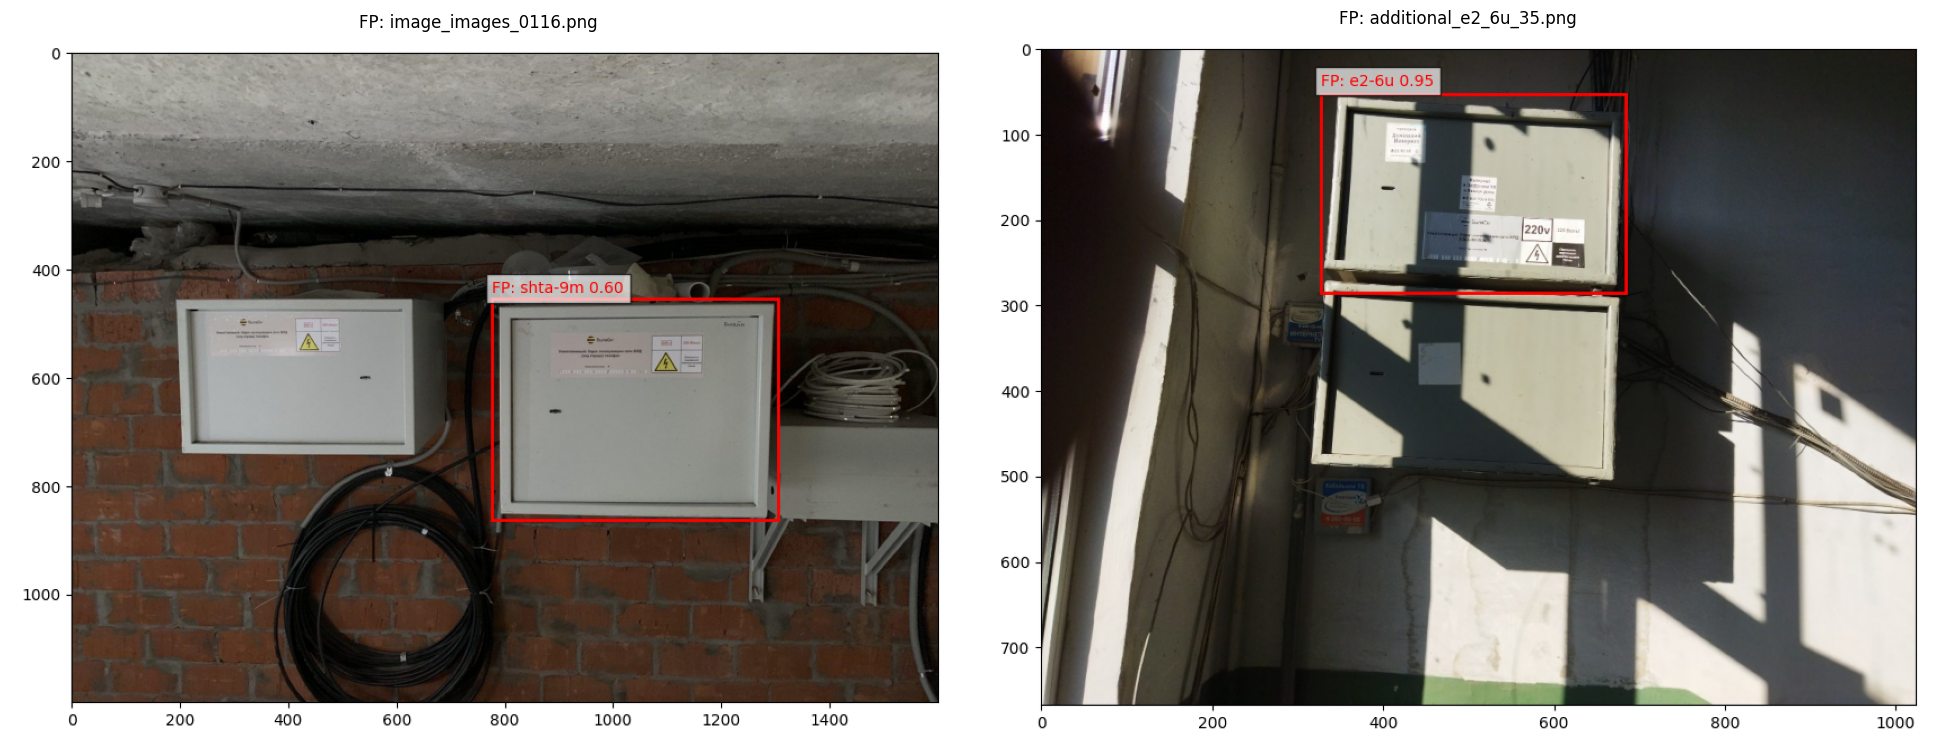

Showing 2/2 images from false_positives


In [26]:
# 6. Просмотр ошибок
view_images_from_folder("false_positives", num_samples=10, title_prefix="FP: ")

In [27]:
view_images_from_folder("false_negatives", num_samples=10, title_prefix="FN: ")

Output hidden; open in https://colab.research.google.com to view.

## F1 and val metrics

In [28]:
# Расчет F1-Score
df_class_report, overall_metrics = calculate_f1_score(comparison_df)

# Вывод результатов
print("\n=== Отчет по классам ===")
print(df_class_report)

print("\n=== Общие метрики ===")
for metric, value in overall_metrics.items():
    print(f"{metric}: {value:.4f}")


=== Отчет по классам ===
     Class   TP  FP  FN  Precision    Recall  F1-Score
0    e2-6u  120   0   1   1.000000  0.991736  0.995851
1  shta-7m  158   3   2   0.981366  0.987500  0.984424
2   shta-3  191   6   1   0.969543  0.994792  0.982005
3   shta-9  159   6   0   0.963636  1.000000  0.981481
4  shta-ps  125   1   1   0.992063  0.992063  0.992063
5  shta-9m  150   6   0   0.961538  1.000000  0.980392
6     sv-5  128   0   0   1.000000  1.000000  1.000000

=== Общие метрики ===
Micro Precision: 0.9791
Micro Recall: 0.9952
Micro F1-Score: 0.9871
Macro F1-Score: 0.9880


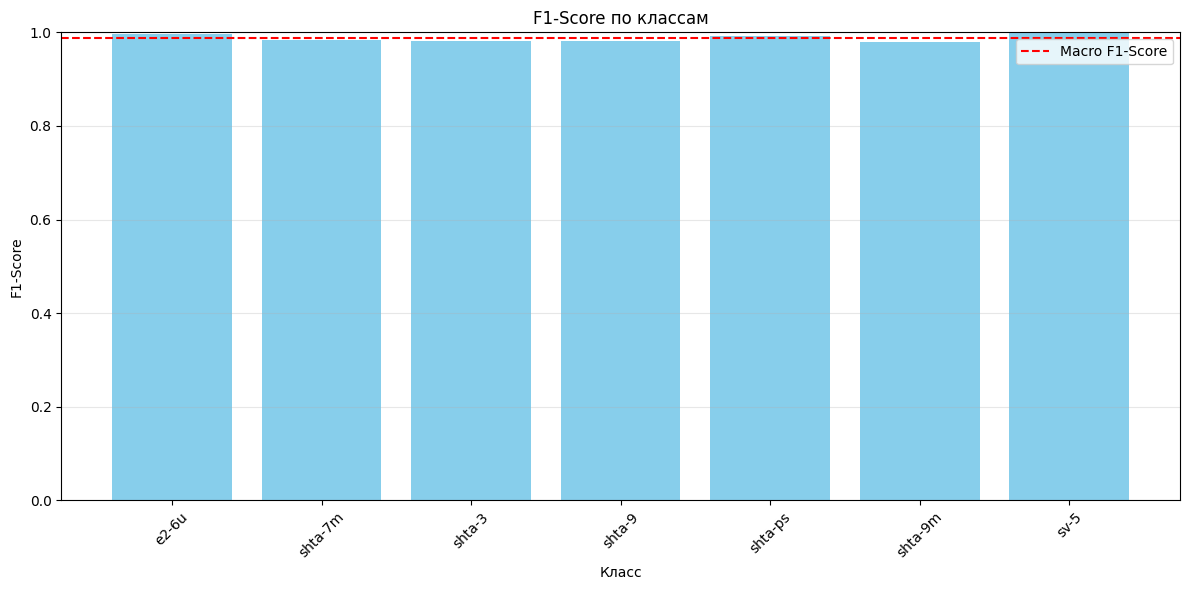

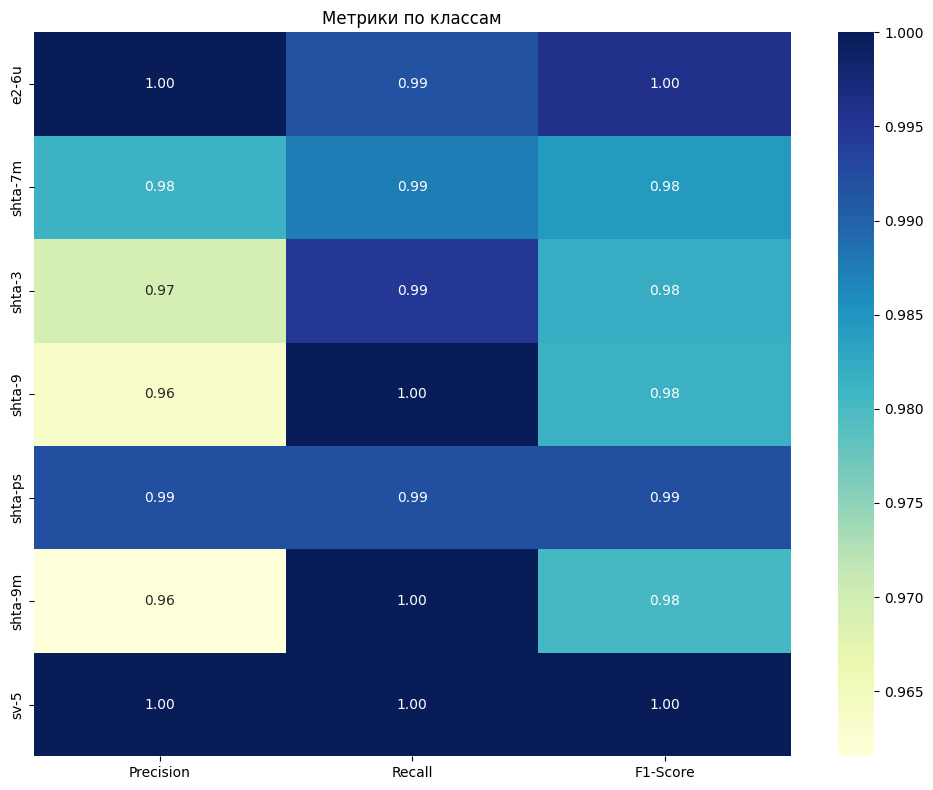

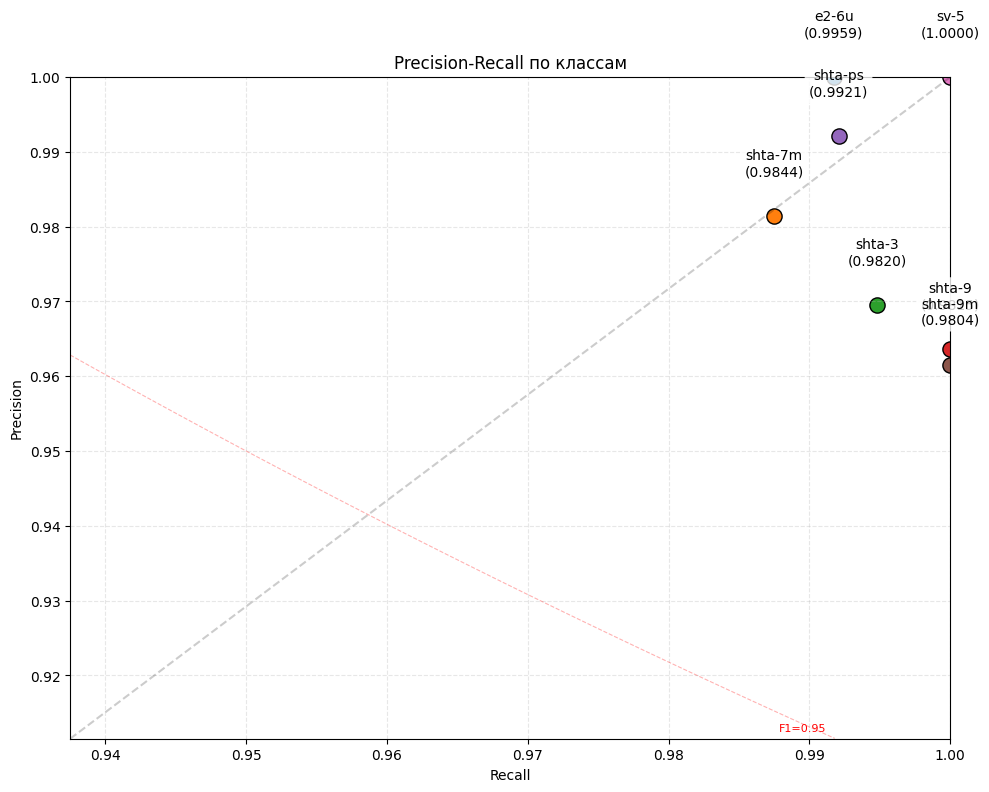

In [31]:
# Визуализация метрик
f1_plots = visualize_f1_metrics(df_class_report, overall_metrics)

## IOU metrics


=== Метрики IoU ===
Средний IoU: 0.9598
Медиана IoU: 0.9656
Минимальный IoU: 0.6088
Максимальный IoU: 0.9956

IoU по классам:
     Class  Mean IoU  Median IoU   Min IoU   Max IoU
0    e2-6u  0.962528    0.967820  0.841331  0.992560
1   shta-3  0.959523    0.967037  0.722697  0.993736
2  shta-7m  0.962476    0.967414  0.853468  0.991744
3   shta-9  0.960730    0.964816  0.821312  0.993279
4  shta-9m  0.958453    0.962762  0.778598  0.992042
5  shta-ps  0.957282    0.963156  0.844305  0.995617
6     sv-5  0.957612    0.966835  0.608756  0.990566

=== Визуализация метрик IoU ===



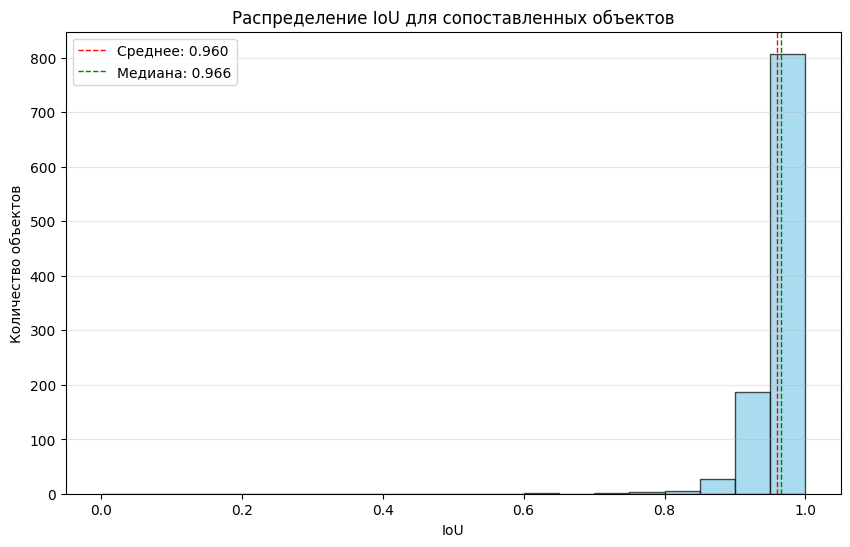

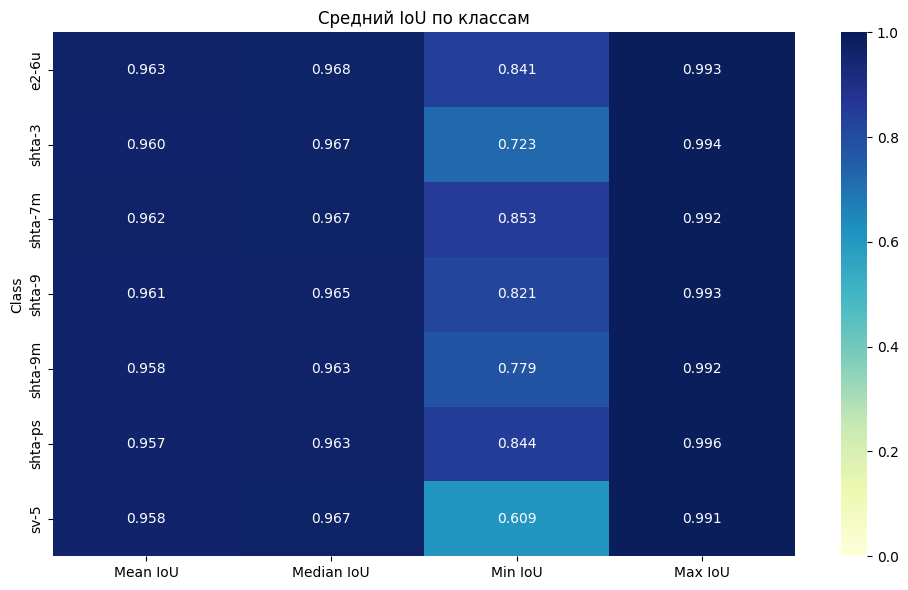

In [32]:
# 7. Расчет и визуализация метрик IoU
# from error_analysis import calculate_iou_metrics, visualize_iou_metrics

# Расчет метрик IoU
iou_metrics = calculate_iou_metrics(comparison_df)

# Вывод результатов
print("\n=== Метрики IoU ===")
print(f"Средний IoU: {iou_metrics['mean_iou']:.4f}")
print(f"Медиана IoU: {iou_metrics['median_iou']:.4f}")
print(f"Минимальный IoU: {iou_metrics['min_iou']:.4f}")
print(f"Максимальный IoU: {iou_metrics['max_iou']:.4f}")

print("\nIoU по классам:")
print(iou_metrics['iou_per_class'])

# Визуализация метрик IoU
print("\n=== Визуализация метрик IoU ===\n")
iou_plots = visualize_iou_metrics(iou_metrics)

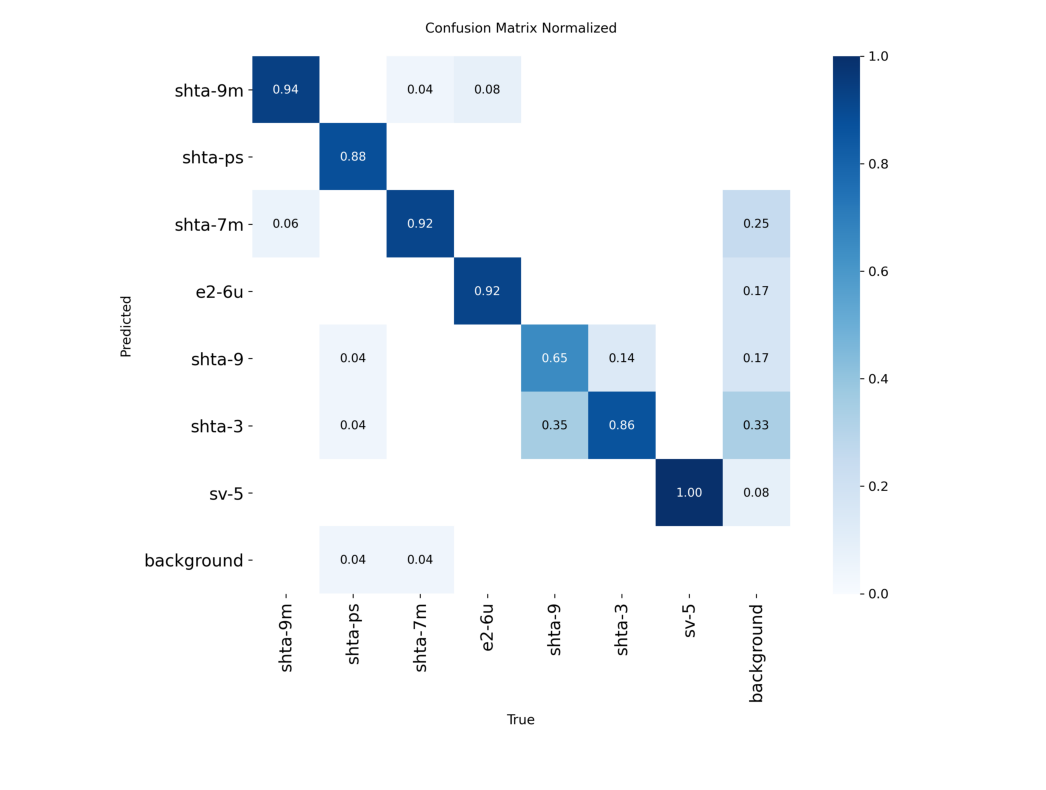

In [33]:
pic_name = '/content/runs/detect/yolo_test_evaluation2/confusion_matrix_normalized.png'
image=plt.imread(pic_name)
plt.figure(figsize=(15, 10))
_=plt.imshow(image)
_=plt.axis('off')

# Тестирование с аугментированными данными

## обучение

In [35]:
# 2. Обучение модели
model, results = train_yolo_model(
    data_yaml=os.path.join(DEFAULT_YOLO_DIR, 'dataset.yaml'),
    epochs=45,
    batch_size=8,
    model_size='n', # передаем параметр для определения какие веса модели загружать (n-nano / m-medium / l-large / xl-extra large)
    data_augmentation=True
)
model_path = save_model(model, AUGMENTED_SAVE_DIR)

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=45, erasing=0.9, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.5, hsv_s=0.8, hsv_v=0.8, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=yolo_object_detection2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=

train: Scanning /content/yolo_dataset/train/labels.cache... 654 images, 0 backgrounds, 0 corrupt: 100%|██████████| 654/654 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 454.2±48.7 MB/s, size: 123.0 KB)


val: Scanning /content/yolo_dataset/val/labels.cache... 140 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<?, ?it/s]


Plotting labels to runs/detect/yolo_object_detection2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolo_object_detection2
Starting training for 45 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/45      1.25G     0.6746      3.167      1.162         16        640: 100%|██████████| 82/82 [00:21<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]

                   all        140        157       0.41       0.25      0.373      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/45      1.39G     0.6706      2.257      1.131         11        640: 100%|██████████| 82/82 [00:21<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.54it/s]

                   all        140        157      0.584      0.613      0.681      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/45      1.39G     0.6691      1.925      1.114         16        640: 100%|██████████| 82/82 [00:18<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

                   all        140        157      0.579      0.748       0.72      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/45      1.39G     0.6806      1.842       1.12         16        640: 100%|██████████| 82/82 [00:18<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.70it/s]

                   all        140        157      0.694      0.804      0.804      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/45      1.39G     0.6398      1.669      1.093         17        640: 100%|██████████| 82/82 [00:19<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.52it/s]

                   all        140        157        0.5      0.755       0.73      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/45      1.39G     0.6343      1.573      1.083         19        640: 100%|██████████| 82/82 [00:19<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.91it/s]

                   all        140        157      0.657      0.788      0.804      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/45      1.39G     0.6381      1.454      1.071         15        640: 100%|██████████| 82/82 [00:18<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.42it/s]

                   all        140        157      0.848      0.771      0.876      0.724



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/45      1.39G     0.6088      1.372      1.067         20        640: 100%|██████████| 82/82 [00:18<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.87it/s]

                   all        140        157      0.736      0.664      0.802       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/45      1.39G     0.5848      1.347      1.049         12        640: 100%|██████████| 82/82 [00:19<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.00it/s]

                   all        140        157      0.748       0.68      0.819      0.681



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/45      1.39G     0.5655      1.261      1.042         18        640: 100%|██████████| 82/82 [00:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.45it/s]

                   all        140        157      0.774      0.838      0.894       0.77



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/45      1.39G     0.5336      1.155      1.016         26        640: 100%|██████████| 82/82 [00:19<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.10it/s]

                   all        140        157      0.868      0.869      0.924       0.79



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/45      1.39G     0.5484      1.134      1.032         15        640: 100%|██████████| 82/82 [00:18<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.96it/s]

                   all        140        157      0.794      0.835      0.881       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/45      1.39G     0.5475      1.089      1.032         22        640: 100%|██████████| 82/82 [00:19<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]

                   all        140        157      0.721      0.875      0.892       0.78



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/45      1.39G     0.5339       1.07      1.016         18        640: 100%|██████████| 82/82 [00:19<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.09it/s]

                   all        140        157      0.768      0.842      0.906      0.776



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/45      1.39G     0.5261      1.027       1.01         17        640: 100%|██████████| 82/82 [00:18<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.26it/s]

                   all        140        157      0.825      0.776       0.91      0.779



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/45      1.39G     0.5117      1.017      1.006         18        640: 100%|██████████| 82/82 [00:20<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.81it/s]

                   all        140        157      0.844      0.778      0.891      0.792



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/45      1.39G     0.5019     0.9759      1.004         19        640: 100%|██████████| 82/82 [00:19<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.00it/s]

                   all        140        157      0.837      0.883      0.918      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/45      1.39G     0.4879     0.8876     0.9815         21        640: 100%|██████████| 82/82 [00:19<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.50it/s]


                   all        140        157      0.943      0.821       0.94      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/45      1.39G     0.4875      0.871      0.986         19        640: 100%|██████████| 82/82 [00:18<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.05it/s]


                   all        140        157      0.846      0.839      0.934      0.836

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/45      1.39G     0.4802     0.8526     0.9861         19        640: 100%|██████████| 82/82 [00:20<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.96it/s]

                   all        140        157      0.883      0.857      0.941      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/45      1.39G     0.4834     0.8268     0.9875         18        640: 100%|██████████| 82/82 [00:18<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.98it/s]


                   all        140        157       0.88      0.874      0.922      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/45      1.39G     0.4681     0.8065     0.9749         18        640: 100%|██████████| 82/82 [00:18<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]

                   all        140        157      0.827      0.909      0.934      0.838



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/45      1.39G     0.4531      0.802     0.9737         17        640: 100%|██████████| 82/82 [00:19<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]

                   all        140        157      0.909      0.867      0.936      0.837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/45      1.39G     0.4752      0.809     0.9878         15        640: 100%|██████████| 82/82 [00:19<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.07it/s]

                   all        140        157      0.887      0.882      0.938      0.829



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/45      1.39G     0.4354     0.7549     0.9608         20        640: 100%|██████████| 82/82 [00:18<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.96it/s]

                   all        140        157      0.877       0.85      0.936      0.845



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/45      1.39G     0.4524     0.7595     0.9745         20        640: 100%|██████████| 82/82 [00:19<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.15it/s]

                   all        140        157      0.856      0.864      0.936      0.839



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/45      1.39G     0.4293     0.7166     0.9643         17        640: 100%|██████████| 82/82 [00:19<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.50it/s]

                   all        140        157      0.897      0.862      0.947      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/45      1.39G     0.4245      0.694     0.9525         19        640: 100%|██████████| 82/82 [00:19<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.37it/s]

                   all        140        157      0.906      0.886      0.954      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/45      1.39G     0.4211     0.6688     0.9635         14        640: 100%|██████████| 82/82 [00:19<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.31it/s]

                   all        140        157      0.892      0.864      0.957      0.857



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/45      1.39G     0.4132     0.6416      0.944         11        640: 100%|██████████| 82/82 [00:18<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.95it/s]

                   all        140        157      0.897      0.899      0.947      0.851



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/45      1.39G     0.4053     0.6358     0.9502         17        640: 100%|██████████| 82/82 [00:20<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.83it/s]

                   all        140        157      0.907      0.888      0.958      0.864



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/45      1.39G      0.398     0.6122     0.9426          9        640: 100%|██████████| 82/82 [00:18<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.78it/s]

                   all        140        157      0.866      0.912      0.957      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/45      1.39G     0.4075     0.6277     0.9462         11        640: 100%|██████████| 82/82 [00:18<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.76it/s]

                   all        140        157      0.913      0.892       0.96      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/45      1.39G     0.3995     0.6247     0.9429         17        640: 100%|██████████| 82/82 [00:20<00:00,  3.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.44it/s]

                   all        140        157      0.904      0.911      0.955      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/45      1.39G     0.3816     0.5893     0.9352         13        640: 100%|██████████| 82/82 [00:20<00:00,  4.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.66it/s]

                   all        140        157      0.898      0.947      0.962      0.891


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/45      1.39G      0.348     0.5652     0.9069          8        640: 100%|██████████| 82/82 [00:20<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.46it/s]

                   all        140        157      0.901      0.903      0.947      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/45      1.39G     0.3385     0.4797     0.8946          6        640: 100%|██████████| 82/82 [00:18<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.79it/s]

                   all        140        157      0.854      0.916      0.946      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/45      1.39G     0.3276     0.4579     0.8974          8        640: 100%|██████████| 82/82 [00:19<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.02it/s]

                   all        140        157      0.917      0.882      0.943      0.873



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/45      1.39G     0.3215     0.4534     0.8839          6        640: 100%|██████████| 82/82 [00:19<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.58it/s]

                   all        140        157      0.881      0.882      0.941      0.862



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/45      1.39G     0.3185     0.4331     0.8836          7        640: 100%|██████████| 82/82 [00:18<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  4.03it/s]

                   all        140        157      0.921      0.893      0.962       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/45      1.39G     0.3009     0.4085     0.8694          6        640: 100%|██████████| 82/82 [00:18<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.68it/s]

                   all        140        157      0.915      0.865      0.961      0.891



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/45      1.39G       0.29     0.3921     0.8614          6        640: 100%|██████████| 82/82 [00:19<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.89it/s]


                   all        140        157      0.924      0.894      0.959      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/45      1.39G     0.2877     0.3687      0.861          6        640: 100%|██████████| 82/82 [00:18<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.99it/s]

                   all        140        157      0.904       0.91      0.957      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/45      1.39G     0.2933     0.3661      0.878          6        640: 100%|██████████| 82/82 [00:19<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]

                   all        140        157      0.887      0.926      0.959      0.893



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/45      1.39G     0.2807      0.359     0.8664          7        640: 100%|██████████| 82/82 [00:19<00:00,  4.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:02<00:00,  3.51it/s]

                   all        140        157      0.918      0.906      0.959      0.891



45 epochs completed in 0.281 hours.
Optimizer stripped from runs/detect/yolo_object_detection2/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolo_object_detection2/weights/best.pt, 6.2MB

Validating runs/detect/yolo_object_detection2/weights/best.pt...
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.27it/s]


                   all        140        157      0.949      0.895      0.962      0.901
               shta-9m         16         16          1      0.862      0.955      0.876
               shta-ps         24         25          1      0.832      0.927      0.864
               shta-7m         24         24      0.917      0.926      0.969      0.902
                 e2-6u         25         25      0.999          1      0.995      0.945
                shta-9         19         20       0.91        0.9      0.962      0.907
                shta-3         22         22      0.851      0.864      0.955       0.91
                  sv-5         25         25      0.968       0.88      0.973      0.901
Speed: 0.2ms preprocess, 19.3ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/yolo_object_detection2
Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 

## оценка test / val

In [36]:
# 3.1 Оценка модели. датасет test
aug_test_results = evaluate_model(model, os.path.join(DEFAULT_YOLO_DIR, 'dataset.yaml'), 'test')

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,007,013 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2122.7±811.8 MB/s, size: 194.3 KB)


val: Scanning /content/yolo_dataset/test/labels.cache... 141 images, 0 backgrounds, 0 corrupt: 100%|██████████| 141/141 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:04<00:00,  3.66it/s]


                   all        141        155       0.94      0.955      0.983      0.928
               shta-9m         23         23          1      0.947      0.989      0.882
               shta-ps         13         13      0.944          1      0.995      0.948
               shta-7m         26         26      0.995          1      0.995      0.956
                 e2-6u         21         22          1      0.936      0.992      0.958
                shta-9         29         29      0.845          1      0.995      0.972
                shta-3         22         24      0.951      0.805      0.935      0.822
                  sv-5         18         18      0.847          1      0.979      0.957
Speed: 1.1ms preprocess, 20.9ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/yolo_test_evaluation3

=== YOLO Test Results ===
mAP50-95: 0.9278
mAP50: 0.9829
mAP75: 0.9658


In [37]:
# 3.2 Оценка модели. датасет val
aug_val_results = evaluate_model(model, os.path.join(DEFAULT_YOLO_DIR, 'dataset.yaml'), 'val')

Ultralytics 8.3.162 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3034.0±776.7 MB/s, size: 203.1 KB)


val: Scanning /content/yolo_dataset/val/labels.cache... 140 images, 0 backgrounds, 0 corrupt: 100%|██████████| 140/140 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 18/18 [00:05<00:00,  3.59it/s]


                   all        140        157      0.947      0.889      0.962        0.9
               shta-9m         16         16          1      0.861      0.953      0.873
               shta-ps         24         25          1      0.832      0.927      0.864
               shta-7m         24         24      0.917      0.926      0.969      0.909
                 e2-6u         25         25          1      0.962      0.995      0.938
                shta-9         19         20      0.911        0.9      0.965       0.91
                shta-3         22         22      0.854      0.864      0.954      0.899
                  sv-5         25         25      0.946       0.88      0.974      0.905
Speed: 2.3ms preprocess, 13.9ms inference, 0.0ms loss, 3.1ms postprocess per image
Results saved to runs/detect/yolo_test_evaluation4

=== YOLO Test Results ===
mAP50-95: 0.8997
mAP50: 0.9625
mAP75: 0.9484


## train metrics

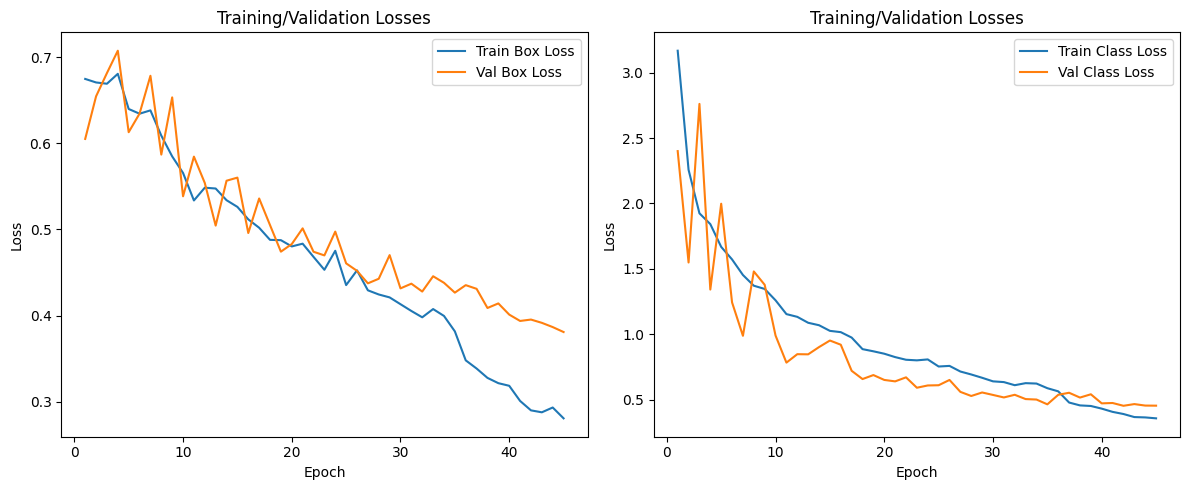

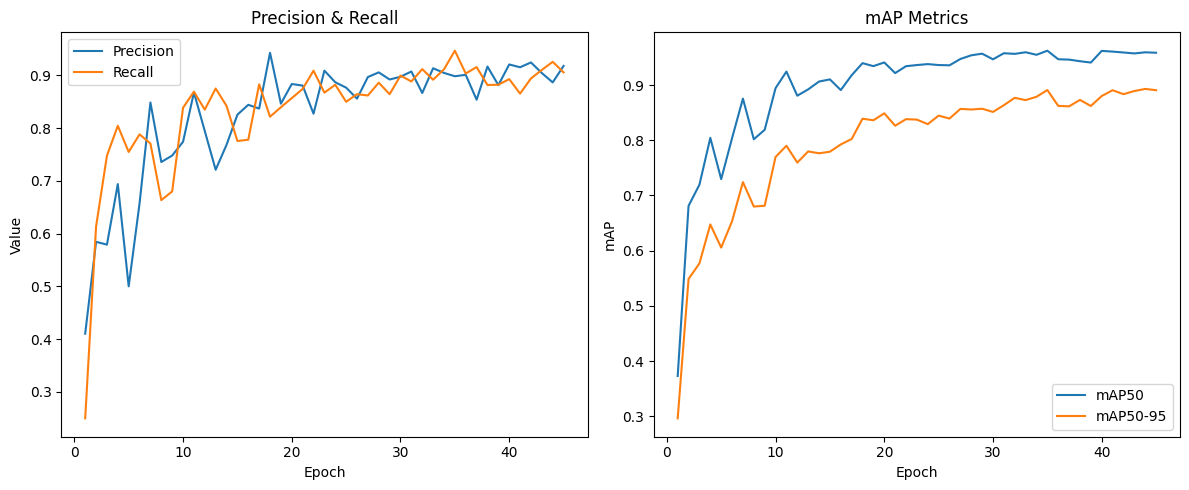

In [38]:
# 4. Анализ метрик
metrics_img_path = plot_training_metrics(experiment_name="yolo_object_detection2")

## image detection

In [39]:
pred_img_path = visualize_predictions(model, DEFAULT_YOLO_DIR, num_samples=5)

Output hidden; open in https://colab.research.google.com to view.

## full detection to df

In [40]:
detections_df = run_detection_on_dataset(model, DEFAULT_DATA_DIR)

Running detection:   0%|          | 0/935 [00:00<?, ?it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_58.jpg: 640x384 1 sv-5, 80.7ms
Speed: 2.0ms preprocess, 80.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


Running detection:   0%|          | 1/935 [00:00<01:42,  9.10it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_7.jpg: 640x480 1 shta-9, 20.6ms
Speed: 3.4ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0016.jpeg: 480x640 1 e2-6u, 20.6ms
Speed: 2.4ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0070.jpg: 480x640 1 shta-3, 21.7ms
Speed: 2.0ms preprocess, 21.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   0%|          | 4/935 [00:00<00:54, 17.03it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_28.jpeg: 480x640 1 e2-6u, 20.6ms
Speed: 2.3ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_49.jpeg: 480x640 1 e2-6u, 21.2ms
Speed: 2.3ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0113.jpg: 640x480 1 shta-9m, 20.6ms
Speed: 2.2ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   1%|          | 7/935 [00:00<00:43, 21.30it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_24.jpg: 640x384 1 sv-5, 20.6ms
Speed: 2.2ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0108.jpg: 640x480 1 shta-9m, 46.3ms
Speed: 6.9ms preprocess, 46.3ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_21.jpeg: 640x480 1 sv-5, 37.9ms
Speed: 4.0ms preprocess, 37.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   1%|          | 10/935 [00:00<01:33,  9.93it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0032.jpg: 640x480 1 sv-5, 38.9ms
Speed: 2.6ms preprocess, 38.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0201.jpg: 384x640 1 shta-3, 29.8ms
Speed: 2.9ms preprocess, 29.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running detection:   1%|▏         | 12/935 [00:01<01:23, 11.10it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0027.jpeg: 576x640 1 e2-6u, 117.2ms
Speed: 4.3ms preprocess, 117.2ms inference, 1.9ms postprocess per image at shape (1, 3, 576, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0233.jpg: 384x640 1 shta-3, 27.4ms
Speed: 3.2ms preprocess, 27.4ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Running detection:   1%|▏         | 14/935 [00:01<01:24, 10.92it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_78.jpg: 640x480 1 sv-5, 27.6ms
Speed: 4.9ms preprocess, 27.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_29.jpg: 640x384 1 sv-5, 26.7ms
Speed: 3.4ms preprocess, 26.7ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 384)


Running detection:   2%|▏         | 16/935 [00:01<01:23, 10.98it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_37.jpeg: 480x640 1 e2-6u, 26.9ms
Speed: 3.7ms preprocess, 26.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0120.jpg: 480x640 1 shta-3, 26.2ms
Speed: 5.4ms preprocess, 26.2ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_67.jpg: 640x480 1 sv-5, 26.9ms
Speed: 2.6ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   2%|▏         | 19/935 [00:01<01:11, 12.86it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0172.jpg: 640x480 1 shta-3, 24.6ms
Speed: 4.2ms preprocess, 24.6ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0005.jpeg: 384x640 1 e2-6u, 24.3ms
Speed: 2.9ms preprocess, 24.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_43.jpeg: 640x480 1 e2-6u, 23.8ms
Speed: 3.6ms preprocess, 23.8ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   2%|▏         | 22/935 [00:01<01:00, 15.06it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0030.jpg: 640x480 1 sv-5, 24.9ms
Speed: 2.6ms preprocess, 24.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_97.JPG: 480x640 2 shta-7ms, 28.7ms
Speed: 4.2ms preprocess, 28.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   3%|▎         | 24/935 [00:01<01:08, 13.31it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_29.JPG: 480x640 1 shta-ps, 24.1ms
Speed: 4.1ms preprocess, 24.1ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_63.jpg: 320x640 1 shta-7m, 76.9ms
Speed: 3.0ms preprocess, 76.9ms inference, 2.1ms postprocess per image at shape (1, 3, 320, 640)


Running detection:   3%|▎         | 26/935 [00:02<01:18, 11.59it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_26.jpg: 640x384 1 sv-5, 32.8ms
Speed: 3.5ms preprocess, 32.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0005.jpg: 512x640 1 shta-ps, 64.3ms
Speed: 4.7ms preprocess, 64.3ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)


Running detection:   3%|▎         | 28/935 [00:02<02:40,  5.66it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0167.jpg: 480x640 1 shta-3, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0005.jpg: 480x640 1 shta-3, 20.7ms
Speed: 1.9ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0192.jpg: 640x480 1 shta-9, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   3%|▎         | 31/935 [00:03<01:58,  7.65it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_3.jpg: 640x480 1 shta-9, 21.9ms
Speed: 2.6ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_37.jpeg: 640x480 1 shta-9m, 20.5ms
Speed: 1.9ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_56.jpg: 320x640 1 shta-7m, 21.0ms
Speed: 2.1ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


Running detection:   4%|▎         | 34/935 [00:03<01:29, 10.10it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_15.jpg: 640x480 1 shta-7m, 20.6ms
Speed: 2.0ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0032.jpg: 512x640 1 shta-9m, 1 shta-ps, 21.0ms
Speed: 2.2ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


Running detection:   4%|▍         | 36/935 [00:03<01:18, 11.41it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0157.jpg: 640x480 1 shta-3, 21.0ms
Speed: 2.4ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0194.jpg: 480x640 1 shta-3, 21.7ms
Speed: 3.3ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   4%|▍         | 38/935 [00:03<01:33,  9.57it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_41.jpeg: 480x640 1 shta-7m, 20.7ms
Speed: 2.4ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_21.jpg: 480x640 1 shta-7m, 24.2ms
Speed: 1.9ms preprocess, 24.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0122.jpg: 640x480 1 shta-9, 1 shta-3, 20.7ms
Speed: 2.0ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   4%|▍         | 41/935 [00:03<01:13, 12.19it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0045.jpg: 640x480 1 shta-7m, 20.6ms
Speed: 1.9ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0295.jpg: 640x448 1 shta-3, 91.7ms
Speed: 2.6ms preprocess, 91.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 448)


Running detection:   5%|▍         | 43/935 [00:03<01:16, 11.67it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_6.jpeg: 384x640 1 e2-6u, 20.5ms
Speed: 2.0ms preprocess, 20.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0030.jpg: 288x640 1 shta-ps, 20.7ms
Speed: 1.7ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0023.jpg: 480x640 1 shta-9, 23.0ms
Speed: 1.9ms preprocess, 23.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   5%|▍         | 46/935 [00:04<01:03, 13.90it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0023.jpg: 640x480 1 sv-5, 20.9ms
Speed: 1.9ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0252.jpg: 384x640 1 shta-7m, 20.8ms
Speed: 1.8ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_50.jpg: 640x480 1 shta-9, 20.4ms
Speed: 2.0ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   5%|▌         | 49/935 [00:04<00:55, 15.86it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0183.jpg: 512x640 1 shta-9m, 20.6ms
Speed: 2.7ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0264.jpg: 640x480 1 shta-3, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_11.jpg: 640x480 1 shta-9, 20.5ms
Speed: 2.6ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   6%|▌         | 52/935 [00:04<00:49, 17.69it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_8.jpeg: 480x640 1 e2-6u, 21.0ms
Speed: 2.2ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_96.jpg: 640x384 1 shta-7m, 21.5ms
Speed: 1.5ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0222.jpg: 480x640 1 shta-3, 22.7ms
Speed: 2.6ms preprocess, 22.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   6%|▌         | 55/935 [00:04<00:45, 19.33it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_10.jpg: 640x480 1 shta-7m, 20.9ms
Speed: 2.1ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_12.jpeg: 480x640 1 e2-6u, 20.5ms
Speed: 2.3ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_41.jpg: 640x480 1 shta-9, 20.3ms
Speed: 2.7ms preprocess, 20.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   6%|▌         | 58/935 [00:04<00:43, 20.26it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0128.jpg: 640x384 (no detections), 20.7ms
Speed: 1.9ms preprocess, 20.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_23.JPG: 480x640 1 shta-ps, 23.4ms
Speed: 3.0ms preprocess, 23.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0160.jpg: 384x640 1 shta-9m, 20.7ms
Speed: 2.0ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:   7%|▋         | 61/935 [00:04<00:45, 19.35it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_51.jpeg: 480x640 1 shta-7m, 20.7ms
Speed: 2.0ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_64.jpg: 320x640 1 shta-7m, 20.1ms
Speed: 1.7ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0011.jpeg: 480x640 1 e2-6u, 20.2ms
Speed: 2.2ms preprocess, 20.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   7%|▋         | 64/935 [00:04<00:41, 21.12it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_56.jpg: 640x480 1 shta-9, 22.5ms
Speed: 1.9ms preprocess, 22.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0213.jpg: 640x480 1 shta-3, 26.7ms
Speed: 2.4ms preprocess, 26.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0226.jpg: 640x480 1 shta-3, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   7%|▋         | 67/935 [00:05<00:40, 21.34it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0006.jpeg: 384x640 1 e2-6u, 20.1ms
Speed: 1.8ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0271.jpg: 384x640 1 shta-3, 20.4ms
Speed: 1.9ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0260.jpg: 480x640 1 shta-3, 20.1ms
Speed: 2.3ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   7%|▋         | 70/935 [00:05<00:37, 22.95it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0027.jpg: 640x288 1 shta-9, 73.8ms
Speed: 1.6ms preprocess, 73.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_32.jpg: 640x480 1 shta-9, 1 shta-3, 20.6ms
Speed: 2.7ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0131.jpg: 640x480 1 shta-7m, 20.1ms
Speed: 2.0ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   8%|▊         | 73/935 [00:05<00:44, 19.54it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_70.jpg: 480x640 1 e2-6u, 19.9ms
Speed: 1.9ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0071.jpg: 480x640 1 shta-3, 20.0ms
Speed: 1.9ms preprocess, 20.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_37.jpg: 384x640 1 shta-ps, 20.5ms
Speed: 2.2ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:   8%|▊         | 76/935 [00:05<00:42, 20.07it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_32.jpg: 640x384 1 sv-5, 20.6ms
Speed: 2.4ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_27.jpg: 640x480 1 shta-9m, 20.3ms
Speed: 1.9ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0016.jpg: 480x640 2 shta-9s, 20.5ms
Speed: 2.0ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   8%|▊         | 79/935 [00:05<00:46, 18.45it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0242.jpg: 640x480 1 shta-9m, 32.2ms
Speed: 4.4ms preprocess, 32.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0019.jpeg: 640x480 (no detections), 19.5ms
Speed: 2.3ms preprocess, 19.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:   9%|▊         | 81/935 [00:06<01:12, 11.83it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_35.jpeg: 640x480 1 shta-9m, 21.5ms
Speed: 2.1ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_57.jpeg: 480x640 1 e2-6u, 19.9ms
Speed: 2.3ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_49.jpg: 640x384 1 sv-5, 19.8ms
Speed: 2.2ms preprocess, 19.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:   9%|▉         | 84/935 [00:06<01:03, 13.50it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_33.jpeg: 640x480 1 shta-9m, 21.0ms
Speed: 1.9ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0134.jpg: 480x640 1 shta-7m, 20.4ms
Speed: 3.5ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:   9%|▉         | 86/935 [00:06<01:09, 12.22it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_32.jpeg: 640x480 1 shta-9m, 20.2ms
Speed: 1.9ms preprocess, 20.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_95.jpg: 480x640 1 shta-7m, 20.7ms
Speed: 1.9ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0147.jpg: 640x640 1 shta-3, 76.6ms
Speed: 3.3ms preprocess, 76.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


Running detection:  10%|▉         | 89/935 [00:06<01:03, 13.36it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_52.jpg: 640x480 1 shta-9, 20.1ms
Speed: 1.9ms preprocess, 20.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_12.jpg: 640x480 1 shta-7m, 20.4ms
Speed: 2.1ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  10%|▉         | 91/935 [00:06<00:58, 14.33it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_27.jpg: 640x384 1 sv-5, 20.2ms
Speed: 3.3ms preprocess, 20.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0012.jpg: 480x640 1 shta-7m, 20.2ms
Speed: 1.9ms preprocess, 20.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  10%|▉         | 93/935 [00:06<00:57, 14.54it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0257.jpg: 640x480 1 shta-9m, 21.6ms
Speed: 3.4ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_36.jpeg: 480x640 1 e2-6u, 22.6ms
Speed: 2.4ms preprocess, 22.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  10%|█         | 95/935 [00:07<01:23, 10.05it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0126.jpg: 640x480 1 shta-9m, 21.0ms
Speed: 3.8ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_49.jpeg: 480x640 1 shta-7m, 20.4ms
Speed: 1.9ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  10%|█         | 97/935 [00:07<01:15, 11.17it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0105.jpg: 480x640 1 shta-3, 21.1ms
Speed: 2.4ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_3.jpg: 480x640 1 shta-ps, 27.4ms
Speed: 2.4ms preprocess, 27.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_9.JPG: 640x480 1 shta-9m, 36.3ms
Speed: 3.5ms preprocess, 36.3ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  11%|█         | 100/935 [00:07<01:02, 13.39it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0231.jpg: 384x640 1 shta-3, 32.2ms
Speed: 3.2ms preprocess, 32.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_5.jpg: 640x480 1 shta-9, 35.1ms
Speed: 3.5ms preprocess, 35.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  11%|█         | 102/935 [00:07<00:57, 14.39it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0054.jpg: 640x480 1 shta-3, 26.6ms
Speed: 2.0ms preprocess, 26.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_68.jpg: 480x640 1 shta-ps, 42.4ms
Speed: 4.0ms preprocess, 42.4ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  11%|█         | 104/935 [00:07<01:01, 13.42it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0041.jpg: 640x480 1 shta-3, 40.1ms
Speed: 2.9ms preprocess, 40.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_4.jpeg: 640x480 1 sv-5, 35.2ms
Speed: 8.1ms preprocess, 35.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  11%|█▏        | 106/935 [00:07<01:02, 13.20it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0022.jpg: 288x640 1 shta-ps, 26.5ms
Speed: 2.6ms preprocess, 26.5ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_41.jpeg: 640x480 1 shta-9m, 2 sv-5s, 32.7ms
Speed: 2.6ms preprocess, 32.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  12%|█▏        | 108/935 [00:08<01:01, 13.42it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_24.jpeg: 480x640 1 e2-6u, 31.9ms
Speed: 3.7ms preprocess, 31.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_14.jpg: 480x640 1 shta-9m, 26.4ms
Speed: 6.5ms preprocess, 26.4ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  12%|█▏        | 110/935 [00:08<00:56, 14.69it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_10.jpeg: 640x480 1 sv-5, 26.1ms
Speed: 3.7ms preprocess, 26.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0116.jpg: 480x640 1 shta-9m, 2 shta-7ms, 26.9ms
Speed: 4.0ms preprocess, 26.9ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  12%|█▏        | 112/935 [00:08<00:52, 15.60it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_44.jpg: 480x640 1 shta-ps, 1 shta-9, 27.5ms
Speed: 2.7ms preprocess, 27.5ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0195.jpg: 384x640 1 shta-3, 26.6ms
Speed: 3.1ms preprocess, 26.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  12%|█▏        | 114/935 [00:08<00:51, 15.86it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0026.jpg: 640x640 1 sv-5, 29.6ms
Speed: 3.8ms preprocess, 29.6ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_5.jpeg: 480x640 1 e2-6u, 30.6ms
Speed: 2.6ms preprocess, 30.6ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_71.jpeg: 640x480 1 shta-7m, 24.4ms
Speed: 2.8ms preprocess, 24.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  13%|█▎        | 117/935 [00:08<00:46, 17.60it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0181.jpg: 640x384 1 shta-9, 1 shta-3, 24.5ms
Speed: 2.2ms preprocess, 24.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_17.jpeg: 480x640 1 e2-6u, 24.1ms
Speed: 3.6ms preprocess, 24.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0243.jpg: 640x480 1 shta-9m, 25.2ms
Speed: 4.4ms preprocess, 25.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  13%|█▎        | 120/935 [00:08<00:54, 15.08it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_7.jpeg: 640x480 1 sv-5, 23.8ms
Speed: 3.6ms preprocess, 23.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0300.jpg: 480x640 1 shta-3, 24.5ms
Speed: 2.5ms preprocess, 24.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  13%|█▎        | 122/935 [00:08<00:50, 16.00it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0016.jpg: 640x640 1 shta-3, 24.6ms
Speed: 3.5ms preprocess, 24.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_49.jpeg: 640x480 1 shta-9m, 29.9ms
Speed: 2.6ms preprocess, 29.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  13%|█▎        | 124/935 [00:09<00:50, 16.02it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0276.jpg: 640x480 1 shta-9m, 43.5ms
Speed: 8.5ms preprocess, 43.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_24.jpg: 640x480 1 shta-9m, 35.5ms
Speed: 4.4ms preprocess, 35.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  13%|█▎        | 126/935 [00:09<01:06, 12.26it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_65.jpg: 384x640 1 shta-ps, 39.7ms
Speed: 2.3ms preprocess, 39.7ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_41.jpg: 480x640 2 shta-9ms, 1 shta-ps, 1 shta-7m, 31.6ms
Speed: 2.8ms preprocess, 31.6ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  14%|█▎        | 128/935 [00:09<01:04, 12.53it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0037.jpg: 448x640 1 shta-ps, 123.8ms
Speed: 3.0ms preprocess, 123.8ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_53.jpeg: 640x480 1 shta-7m, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  14%|█▍        | 130/935 [00:09<01:11, 11.31it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0004.jpg: 480x640 1 shta-3, 41.2ms
Speed: 3.7ms preprocess, 41.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_85.jpg: 480x640 1 shta-9, 21.6ms
Speed: 2.8ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  14%|█▍        | 132/935 [00:09<01:20, 10.00it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0256.jpg: 480x640 1 e2-6u, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_47.jpeg: 640x480 1 shta-9m, 20.7ms
Speed: 1.9ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_91.jpg: 480x640 1 shta-7m, 20.6ms
Speed: 2.0ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  14%|█▍        | 135/935 [00:10<01:03, 12.58it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_34.jpeg: 640x480 2 shta-9ms, 20.8ms
Speed: 2.0ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_46.JPG: 640x480 1 shta-9m, 23.1ms
Speed: 2.0ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_20.jpg: 640x480 1 shta-9m, 21.2ms
Speed: 2.0ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  15%|█▍        | 138/935 [00:10<00:52, 15.24it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0138.jpg: 640x384 1 shta-7m, 38.4ms
Speed: 2.3ms preprocess, 38.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_7.jpg: 640x480 1 shta-7m, 21.0ms
Speed: 2.0ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0065.jpg: 480x640 1 shta-3, 21.0ms
Speed: 2.1ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  15%|█▌        | 141/935 [00:10<00:48, 16.41it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0031.jpg: 640x480 1 shta-ps, 1 shta-9, 21.3ms
Speed: 2.1ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0003.jpg: 640x384 1 shta-ps, 1 shta-9, 21.4ms
Speed: 1.8ms preprocess, 21.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_27.jpeg: 480x640 1 e2-6u, 21.6ms
Speed: 2.3ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  15%|█▌        | 144/935 [00:10<00:44, 17.80it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0039.jpg: 288x640 1 shta-ps, 20.4ms
Speed: 1.7ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0064.jpg: 640x480 1 shta-3, 20.6ms
Speed: 2.0ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  16%|█▌        | 146/935 [00:10<00:43, 18.16it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0280.jpg: 640x480 1 shta-9m, 20.8ms
Speed: 2.8ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0282.jpg: 640x480 1 shta-9m, 21.8ms
Speed: 3.3ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  16%|█▌        | 148/935 [00:10<01:06, 11.83it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_51.jpg: 640x480 1 shta-9, 20.8ms
Speed: 2.1ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_13.JPG: 480x640 1 shta-9m, 21.2ms
Speed: 2.4ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0179.jpg: 640x512 1 shta-9m, 1 shta-9, 49.5ms
Speed: 2.1ms preprocess, 49.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


Running detection:  16%|█▌        | 151/935 [00:11<00:58, 13.42it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0010.jpeg: 480x640 1 sv-5, 21.7ms
Speed: 2.3ms preprocess, 21.7ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_77.jpg: 640x480 1 shta-ps, 1 shta-9, 1 shta-3, 21.1ms
Speed: 2.0ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0008.jpg: 640x480 1 sv-5, 27.9ms
Speed: 2.0ms preprocess, 27.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  16%|█▋        | 154/935 [00:11<00:52, 14.93it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_66.jpg: 640x480 1 shta-9, 21.4ms
Speed: 2.0ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_38.jpg: 640x384 1 sv-5, 22.7ms
Speed: 2.4ms preprocess, 22.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  17%|█▋        | 156/935 [00:11<00:54, 14.40it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_32.JPG: 480x640 1 shta-7m, 21.6ms
Speed: 3.1ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0178.jpg: 320x640 1 shta-3, 20.7ms
Speed: 1.6ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


Running detection:  17%|█▋        | 158/935 [00:11<01:01, 12.65it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_67.jpg: 640x480 1 shta-ps, 21.6ms
Speed: 2.7ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0196.jpg: 480x640 1 shta-3, 21.5ms
Speed: 3.3ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  17%|█▋        | 160/935 [00:12<01:30,  8.55it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0299.jpg: 640x512 1 shta-3, 22.1ms
Speed: 3.2ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0142.jpg: 640x480 1 shta-9m, 23.1ms
Speed: 3.0ms preprocess, 23.1ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  17%|█▋        | 162/935 [00:12<01:28,  8.74it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0082.jpg: 512x640 1 shta-3, 22.8ms
Speed: 6.4ms preprocess, 22.8ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_13.jpeg: 480x640 1 e2-6u, 21.0ms
Speed: 2.3ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_47.jpeg: 480x640 1 shta-7m, 21.2ms
Speed: 2.0ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  18%|█▊        | 165/935 [00:12<01:08, 11.29it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0124.jpg: 640x384 1 shta-9, 22.0ms
Speed: 2.5ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0118.jpg: 640x384 1 shta-3, 22.0ms
Speed: 2.6ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  18%|█▊        | 167/935 [00:12<01:12, 10.66it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_16.jpg: 640x480 1 shta-9, 22.2ms
Speed: 2.8ms preprocess, 22.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0036.jpg: 384x640 2 shta-3s, 29.2ms
Speed: 2.2ms preprocess, 29.2ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_17.jpg: 640x480 1 shta-9, 26.0ms
Speed: 2.8ms preprocess, 26.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  18%|█▊        | 170/935 [00:12<01:00, 12.74it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_59.jpeg: 480x640 1 e2-6u, 36.5ms
Speed: 3.9ms preprocess, 36.5ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_42.jpg: 640x384 1 sv-5, 32.1ms
Speed: 3.5ms preprocess, 32.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  18%|█▊        | 172/935 [00:12<01:03, 11.94it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0002.jpg: 480x640 1 shta-9, 28.2ms
Speed: 4.7ms preprocess, 28.2ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_2.jpg: 640x384 1 sv-5, 27.7ms
Speed: 3.5ms preprocess, 27.7ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  19%|█▊        | 174/935 [00:13<01:58,  6.41it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_68.jpg: 640x480 1 sv-5, 27.8ms
Speed: 2.7ms preprocess, 27.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0265.jpg: 640x384 1 shta-9m, 26.2ms
Speed: 3.4ms preprocess, 26.2ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  19%|█▉        | 176/935 [00:13<01:38,  7.70it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_84.jpg: 640x480 1 sv-5, 24.5ms
Speed: 2.7ms preprocess, 24.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0089.jpg: 480x640 1 shta-3, 24.8ms
Speed: 2.7ms preprocess, 24.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  19%|█▉        | 178/935 [00:13<01:23,  9.02it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0007.jpeg: 640x480 1 sv-5, 26.3ms
Speed: 5.8ms preprocess, 26.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0145.jpg: 640x480 1 shta-9m, 33.4ms
Speed: 4.5ms preprocess, 33.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  19%|█▉        | 180/935 [00:14<01:43,  7.32it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_54.jpg: 640x480 1 shta-9, 1 shta-3, 29.5ms
Speed: 2.7ms preprocess, 29.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0058.jpg: 384x640 1 shta-7m, 40.4ms
Speed: 8.3ms preprocess, 40.4ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  19%|█▉        | 182/935 [00:14<01:27,  8.62it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_39.jpg: 640x480 1 shta-9, 1 shta-3, 26.9ms
Speed: 4.6ms preprocess, 26.9ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0072.jpg: 480x640 1 shta-3, 42.0ms
Speed: 3.2ms preprocess, 42.0ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  20%|█▉        | 184/935 [00:14<01:18,  9.56it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0169.jpg: 480x640 1 shta-3, 35.1ms
Speed: 3.5ms preprocess, 35.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_73.jpg: 640x480 1 sv-5, 33.5ms
Speed: 2.6ms preprocess, 33.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  20%|█▉        | 186/935 [00:14<01:10, 10.66it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0127.jpg: 544x640 1 shta-3, 83.0ms
Speed: 4.7ms preprocess, 83.0ms inference, 2.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0006.jpg: 480x640 1 shta-3, 38.3ms
Speed: 2.8ms preprocess, 38.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  20%|██        | 188/935 [00:15<01:17,  9.62it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0024.jpg: 480x640 1 shta-3, 20.8ms
Speed: 2.0ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_29.jpeg: 480x640 1 e2-6u, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  20%|██        | 190/935 [00:15<01:05, 11.35it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_33.jpg: 640x480 1 shta-ps, 22.4ms
Speed: 3.3ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0294.jpg: 480x640 1 shta-9m, 21.1ms
Speed: 2.9ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  21%|██        | 192/935 [00:15<01:01, 12.12it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0254.jpg: 512x640 1 sv-5, 21.6ms
Speed: 2.7ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_40.jpg: 640x384 1 sv-5, 21.0ms
Speed: 2.7ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  21%|██        | 194/935 [00:15<00:55, 13.31it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_8.JPG: 480x640 1 shta-9m, 20.7ms
Speed: 2.5ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0287.jpg: 480x640 1 shta-3, 20.7ms
Speed: 2.6ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_90.jpg: 480x640 1 shta-7m, 22.2ms
Speed: 1.9ms preprocess, 22.2ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  21%|██        | 197/935 [00:15<00:45, 16.18it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_66.jpeg: 384x640 1 e2-6u, 32.7ms
Speed: 2.9ms preprocess, 32.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0044.jpg: 640x480 1 shta-3, 21.8ms
Speed: 2.0ms preprocess, 21.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_1.jpg: 512x640 1 shta-9m, 1 shta-ps, 20.8ms
Speed: 2.0ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  21%|██▏       | 200/935 [00:15<00:41, 17.53it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_22.jpeg: 480x640 1 e2-6u, 20.7ms
Speed: 2.4ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_38.jpeg: 480x640 1 shta-7m, 26.8ms
Speed: 2.3ms preprocess, 26.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_67.jpeg: 384x640 1 e2-6u, 22.0ms
Speed: 2.0ms preprocess, 22.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  22%|██▏       | 203/935 [00:15<00:37, 19.54it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0230.jpg: 640x480 1 shta-3, 20.4ms
Speed: 1.9ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_9.jpeg: 480x640 1 e2-6u, 20.1ms
Speed: 2.3ms preprocess, 20.1ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0006.jpeg: 640x480 1 sv-5, 20.1ms
Speed: 2.4ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  22%|██▏       | 206/935 [00:15<00:34, 21.33it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_62.jpg: 640x480 1 shta-9, 19.7ms
Speed: 1.9ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_28.JPG: 480x640 1 shta-ps, 19.6ms
Speed: 2.5ms preprocess, 19.6ms inference, 1.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_18.jpg: 320x640 1 shta-7m, 19.9ms
Speed: 1.7ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


Running detection:  22%|██▏       | 209/935 [00:16<00:34, 21.29it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_48.jpeg: 640x480 1 shta-9m, 19.8ms
Speed: 1.9ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0267.jpg: 384x640 1 shta-3, 20.3ms
Speed: 1.9ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0061.jpg: 640x480 1 shta-3, 19.9ms
Speed: 1.9ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  23%|██▎       | 212/935 [00:16<00:34, 20.92it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0042.jpg: 640x480 1 shta-3, 19.7ms
Speed: 1.9ms preprocess, 19.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0004.jpeg: 480x640 1 e2-6u, 19.6ms
Speed: 2.3ms preprocess, 19.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0032.jpg: 640x480 1 shta-9, 2 shta-3s, 19.8ms
Speed: 1.9ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  23%|██▎       | 215/935 [00:16<00:35, 20.53it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_24.jpg: 640x480 1 shta-9, 2 shta-3s, 19.6ms
Speed: 2.6ms preprocess, 19.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_73.jpg: 640x640 1 shta-9, 21.5ms
Speed: 2.4ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_60.jpg: 480x640 1 shta-7m, 20.9ms
Speed: 1.9ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  23%|██▎       | 218/935 [00:16<00:36, 19.53it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0084.jpg: 640x480 1 shta-9, 1 shta-3, 20.0ms
Speed: 1.9ms preprocess, 20.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0026.jpg: 480x640 1 shta-ps, 22.4ms
Speed: 2.7ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  24%|██▎       | 220/935 [00:16<00:37, 19.29it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0176.jpg: 640x480 1 shta-9m, 1 shta-7m, 20.4ms
Speed: 3.0ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0278.jpg: 640x480 1 shta-9m, 20.5ms
Speed: 3.0ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  24%|██▎       | 222/935 [00:16<00:39, 18.11it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0081.jpg: 640x480 1 shta-3, 20.0ms
Speed: 1.9ms preprocess, 20.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_38.jpg: 640x480 1 shta-9, 20.5ms
Speed: 2.7ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0026.jpg: 640x384 1 sv-5, 19.9ms
Speed: 2.1ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  24%|██▍       | 225/935 [00:16<00:36, 19.34it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0296.jpg: 640x384 1 shta-3, 22.3ms
Speed: 2.2ms preprocess, 22.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_77.jpg: 640x480 1 sv-5, 20.0ms
Speed: 1.9ms preprocess, 20.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0091.jpg: 384x640 1 shta-3, 19.8ms
Speed: 2.0ms preprocess, 19.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  24%|██▍       | 228/935 [00:16<00:33, 21.15it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_31.JPG: 480x640 1 shta-9m, 19.5ms
Speed: 2.4ms preprocess, 19.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0024.jpg: 480x640 1 shta-ps, 20.8ms
Speed: 1.9ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0253.jpg: 640x480 1 shta-9m, 21.0ms
Speed: 3.1ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  25%|██▍       | 231/935 [00:17<00:42, 16.73it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_43.jpg: 480x640 2 shta-pss, 1 shta-9, 2 shta-3s, 22.1ms
Speed: 2.5ms preprocess, 22.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0203.jpg: 384x640 1 shta-3, 20.4ms
Speed: 2.0ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  25%|██▍       | 233/935 [00:17<00:40, 17.17it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_30.JPG: 480x640 1 shta-ps, 21.1ms
Speed: 2.7ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_34.jpeg: 480x640 1 e2-6u, 20.2ms
Speed: 2.3ms preprocess, 20.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0158.jpg: 640x480 1 shta-9m, 21.2ms
Speed: 2.9ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  25%|██▌       | 236/935 [00:17<00:41, 16.65it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0034.jpg: 480x640 1 shta-9m, 1 shta-ps, 27.2ms
Speed: 2.0ms preprocess, 27.2ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_74.jpg: 640x480 1 sv-5, 20.1ms
Speed: 2.0ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  25%|██▌       | 238/935 [00:17<00:41, 16.66it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_4.jpg: 640x640 1 shta-ps, 22.8ms
Speed: 4.1ms preprocess, 22.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_75.jpg: 640x480 1 shta-9, 20.7ms
Speed: 2.0ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  26%|██▌       | 240/935 [00:17<00:42, 16.50it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0038.jpg: 640x480 1 shta-3, 20.9ms
Speed: 2.0ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0019.jpg: 480x640 1 shta-ps, 1 shta-9, 20.8ms
Speed: 1.9ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0291.jpg: 640x480 1 shta-9m, 21.2ms
Speed: 3.0ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  26%|██▌       | 243/935 [00:17<00:43, 15.81it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0168.jpg: 480x640 1 shta-3, 20.9ms
Speed: 2.3ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_51.jpeg: 640x480 1 shta-9m, 20.4ms
Speed: 2.2ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0206.jpg: 384x640 1 shta-3, 20.8ms
Speed: 1.9ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  26%|██▋       | 246/935 [00:18<00:37, 18.32it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_18.jpg: 384x640 1 shta-9m, 20.4ms
Speed: 1.7ms preprocess, 20.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0207.jpg: 640x480 1 shta-7m, 22.7ms
Speed: 2.0ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0027.jpg: 640x480 1 shta-3, 20.5ms
Speed: 2.0ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  27%|██▋       | 249/935 [00:18<00:36, 18.64it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0223.jpg: 640x480 1 shta-3, 22.0ms
Speed: 1.9ms preprocess, 22.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0162.jpg: 640x480 1 shta-7m, 20.5ms
Speed: 2.3ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0029.jpg: 288x640 1 shta-ps, 1 shta-9, 20.4ms
Speed: 1.6ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


Running detection:  27%|██▋       | 252/935 [00:18<00:34, 19.95it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0244.jpg: 384x640 1 shta-3, 20.3ms
Speed: 2.0ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0191.jpg: 384x640 1 shta-3, 20.4ms
Speed: 2.0ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_10.jpg: 640x480 1 shta-9, 1 shta-3, 21.3ms
Speed: 2.8ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  27%|██▋       | 255/935 [00:18<00:31, 21.27it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_87.jpg: 640x480 1 shta-9, 20.3ms
Speed: 2.0ms preprocess, 20.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_17.jpg: 640x480 1 shta-9m, 20.4ms
Speed: 2.2ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0030.jpg: 512x640 1 sv-5, 21.9ms
Speed: 2.7ms preprocess, 21.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  28%|██▊       | 258/935 [00:18<00:34, 19.83it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0197.jpg: 384x640 1 shta-3, 25.6ms
Speed: 2.4ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_25.jpg: 640x384 1 sv-5, 22.0ms
Speed: 2.4ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_44.jpeg: 480x640 1 shta-9m, 20.5ms
Speed: 2.1ms preprocess, 20.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  28%|██▊       | 261/935 [00:18<00:35, 18.94it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0001.jpg: 640x512 2 shta-pss, 1 shta-9, 20.1ms
Speed: 2.1ms preprocess, 20.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0022.jpg: 640x480 1 sv-5, 20.3ms
Speed: 2.0ms preprocess, 20.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  28%|██▊       | 263/935 [00:18<00:35, 18.78it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_38.jpg: 640x320 1 shta-ps, 1 shta-9, 50.5ms
Speed: 1.5ms preprocess, 50.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_1.jpg: 640x480 1 shta-3, 20.6ms
Speed: 2.7ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  28%|██▊       | 265/935 [00:19<00:37, 17.98it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_27.JPG: 480x640 1 shta-ps, 21.3ms
Speed: 2.7ms preprocess, 21.3ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_25.jpg: 640x480 1 shta-9, 19.9ms
Speed: 2.6ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  29%|██▊       | 267/935 [00:19<00:40, 16.68it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0029.jpg: 480x640 1 shta-9, 21.0ms
Speed: 1.9ms preprocess, 21.0ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_63.jpg: 640x480 1 shta-9, 19.9ms
Speed: 2.0ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  29%|██▉       | 269/935 [00:19<00:39, 16.73it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_56.jpeg: 480x640 2 e2-6us, 20.2ms
Speed: 2.4ms preprocess, 20.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_20.jpg: 480x640 1 shta-7m, 20.3ms
Speed: 1.9ms preprocess, 20.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_47.jpg: 640x480 1 shta-ps, 1 shta-9, 20.0ms
Speed: 2.0ms preprocess, 20.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  29%|██▉       | 272/935 [00:19<00:35, 18.58it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0015.jpg: 640x512 1 shta-9, 1 shta-3, 19.9ms
Speed: 2.0ms preprocess, 19.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_45.jpeg: 640x480 1 shta-9m, 19.9ms
Speed: 2.0ms preprocess, 19.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  29%|██▉       | 274/935 [00:19<00:34, 18.92it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_19.jpeg: 384x640 1 e2-6u, 20.1ms
Speed: 1.9ms preprocess, 20.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_50.jpg: 480x640 1 shta-ps, 33.3ms
Speed: 4.5ms preprocess, 33.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  30%|██▉       | 276/935 [00:19<00:35, 18.69it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_16.jpg: 320x640 1 shta-7m, 24.0ms
Speed: 2.1ms preprocess, 24.0ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_35.jpg: 480x640 1 shta-7m, 21.0ms
Speed: 1.9ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0227.jpg: 480x640 1 shta-9m, 21.0ms
Speed: 2.5ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  30%|██▉       | 279/935 [00:19<00:33, 19.61it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0290.jpg: 640x480 1 shta-3, 24.1ms
Speed: 2.8ms preprocess, 24.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_33.jpeg: 480x640 1 e2-6u, 20.5ms
Speed: 2.3ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0063.jpg: 640x480 1 shta-3, 20.1ms
Speed: 2.0ms preprocess, 20.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  30%|███       | 282/935 [00:19<00:30, 21.50it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_26.jpg: 640x480 1 shta-9, 20.4ms
Speed: 2.7ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0002.jpeg: 480x640 1 shta-7m, 1 e2-6u, 20.7ms
Speed: 2.4ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0020.jpg: 480x640 1 shta-9, 1 shta-3, 20.3ms
Speed: 2.5ms preprocess, 20.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  30%|███       | 285/935 [00:20<00:30, 20.98it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0028.jpg: 640x480 1 sv-5, 20.3ms
Speed: 1.9ms preprocess, 20.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_33.jpg: 384x640 1 shta-7m, 23.6ms
Speed: 1.8ms preprocess, 23.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0007.jpg: 480x640 1 shta-9, 1 shta-3, 22.8ms
Speed: 2.0ms preprocess, 22.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  31%|███       | 288/935 [00:20<00:33, 19.56it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_2.jpeg: 480x640 1 e2-6u, 22.4ms
Speed: 3.4ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_19.jpg: 320x640 1 shta-7m, 19.9ms
Speed: 1.7ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0020.jpeg: 480x640 1 e2-6u, 19.7ms
Speed: 2.3ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  31%|███       | 291/935 [00:20<00:30, 20.79it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0040.jpg: 480x640 1 shta-ps, 19.7ms
Speed: 2.5ms preprocess, 19.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_19.jpeg: 640x480 1 sv-5, 20.6ms
Speed: 2.5ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_39.jpg: 640x384 1 sv-5, 21.1ms
Speed: 2.4ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  31%|███▏      | 294/935 [00:20<00:34, 18.65it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_5.jpeg: 640x480 1 sv-5, 20.3ms
Speed: 2.4ms preprocess, 20.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_35.jpg: 640x384 1 sv-5, 35.0ms
Speed: 3.4ms preprocess, 35.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  32%|███▏      | 296/935 [00:20<00:36, 17.62it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0027.jpg: 480x640 1 shta-9m, 1 shta-ps, 20.4ms
Speed: 2.0ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0210.jpg: 384x640 1 shta-7m, 20.6ms
Speed: 2.3ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_64.jpg: 640x480 1 shta-ps, 20.5ms
Speed: 2.7ms preprocess, 20.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  32%|███▏      | 299/935 [00:20<00:35, 18.02it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_14.jpg: 640x480 1 shta-9, 2 shta-3s, 20.3ms
Speed: 2.7ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0056.jpg: 640x480 1 shta-3, 19.7ms
Speed: 2.0ms preprocess, 19.7ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  32%|███▏      | 301/935 [00:20<00:34, 18.33it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_2.jpeg: 320x640 1 e2-6u, 20.7ms
Speed: 2.6ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_20.jpeg: 640x480 1 sv-5, 19.7ms
Speed: 2.3ms preprocess, 19.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0234.jpg: 640x384 1 shta-9, 20.3ms
Speed: 2.1ms preprocess, 20.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  33%|███▎      | 304/935 [00:21<00:31, 19.73it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0171.jpg: 640x640 1 shta-7m, 20.9ms
Speed: 3.4ms preprocess, 20.9ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_40.jpeg: 480x640 1 shta-7m, 19.9ms
Speed: 2.6ms preprocess, 19.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  33%|███▎      | 306/935 [00:21<00:32, 19.42it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0035.jpg: 640x480 1 shta-9, 20.1ms
Speed: 2.0ms preprocess, 20.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0101.jpg: 640x480 1 shta-9m, 21.1ms
Speed: 3.3ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  33%|███▎      | 308/935 [00:21<00:42, 14.65it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0001.jpeg: 480x640 1 e2-6u, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0019.jpg: 640x480 1 sv-5, 20.4ms
Speed: 2.1ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0014.jpeg: 480x640 1 sv-5, 20.2ms
Speed: 2.8ms preprocess, 20.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  33%|███▎      | 311/935 [00:21<00:37, 16.73it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_36.jpg: 416x640 1 shta-7m, 52.5ms
Speed: 2.9ms preprocess, 52.5ms inference, 1.4ms postprocess per image at shape (1, 3, 416, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_46.jpg: 640x384 1 sv-5, 35.0ms
Speed: 5.0ms preprocess, 35.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  33%|███▎      | 313/935 [00:21<00:40, 15.21it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_45.jpg: 640x480 1 shta-9, 21.5ms
Speed: 2.0ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0037.jpg: 640x480 1 shta-3, 22.4ms
Speed: 2.0ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0019.jpg: 640x288 1 shta-9, 20.7ms
Speed: 1.2ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 288)


Running detection:  34%|███▍      | 316/935 [00:21<00:36, 16.81it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0033.jpg: 480x640 2 shta-9s, 1 shta-3, 21.2ms
Speed: 1.9ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0218.jpg: 480x640 1 shta-3, 20.7ms
Speed: 2.3ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  34%|███▍      | 318/935 [00:22<00:35, 17.30it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_52.jpeg: 480x640 1 e2-6u, 23.6ms
Speed: 2.8ms preprocess, 23.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_23.jpg: 640x480 1 shta-9, 24.2ms
Speed: 2.9ms preprocess, 24.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_4.jpg: 640x480 1 shta-7m, 25.6ms
Speed: 3.1ms preprocess, 25.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  34%|███▍      | 321/935 [00:22<00:33, 18.37it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0020.jpg: 640x480 1 shta-ps, 21.1ms
Speed: 2.2ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_39.jpg: 512x640 1 shta-ps, 20.6ms
Speed: 2.0ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  35%|███▍      | 323/935 [00:22<00:34, 17.50it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0283.jpg: 480x640 1 shta-3, 21.3ms
Speed: 3.1ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_60.jpeg: 640x480 1 shta-9m, 20.4ms
Speed: 1.9ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0018.jpeg: 640x480 1 sv-5, 20.8ms
Speed: 3.4ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  35%|███▍      | 326/935 [00:22<00:31, 19.52it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_56.jpeg: 640x480 1 shta-9m, 21.4ms
Speed: 2.0ms preprocess, 21.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_79.jpg: 480x640 1 shta-9, 1 shta-3, 22.6ms
Speed: 2.8ms preprocess, 22.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  35%|███▌      | 328/935 [00:22<00:37, 16.36it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_68.jpg: 640x480 1 shta-9, 21.7ms
Speed: 1.9ms preprocess, 21.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_52.JPG: 512x640 1 shta-ps, 1 shta-3, 23.8ms
Speed: 3.2ms preprocess, 23.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_22.jpg: 640x480 1 shta-9, 1 shta-3, 21.8ms
Speed: 2.4ms preprocess, 21.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  35%|███▌      | 331/935 [00:22<00:33, 18.08it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_57.jpg: 640x384 1 sv-5, 34.0ms
Speed: 1.6ms preprocess, 34.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0182.jpg: 384x640 1 shta-7m, 20.8ms
Speed: 3.2ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  36%|███▌      | 333/935 [00:22<00:32, 18.37it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_33.jpg: 640x384 1 sv-5, 20.8ms
Speed: 2.3ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_23.jpg: 480x640 1 shta-7m, 21.0ms
Speed: 2.0ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  36%|███▌      | 335/935 [00:22<00:33, 17.83it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_40.jpg: 640x480 1 shta-9, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_8.JPG: 480x640 1 shta-ps, 21.0ms
Speed: 2.9ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  36%|███▌      | 337/935 [00:23<00:36, 16.37it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_48.jpeg: 480x640 1 shta-7m, 20.5ms
Speed: 2.0ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_69.jpeg: 480x640 2 shta-7ms, 21.1ms
Speed: 2.2ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_37.jpg: 640x384 1 sv-5, 21.4ms
Speed: 2.4ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  36%|███▋      | 340/935 [00:23<00:36, 16.47it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0247.jpg: 640x480 1 shta-9m, 22.4ms
Speed: 2.4ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0010.jpg: 640x480 1 shta-ps, 20.7ms
Speed: 1.9ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  37%|███▋      | 342/935 [00:23<00:34, 17.13it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_17.jpg: 640x480 1 shta-7m, 20.4ms
Speed: 2.0ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_8.jpeg: 480x640 1 sv-5, 21.1ms
Speed: 2.4ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_40.jpg: 480x640 1 shta-ps, 1 shta-9, 1 shta-3, 20.7ms
Speed: 1.9ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  37%|███▋      | 345/935 [00:23<00:32, 17.97it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_28.jpg: 640x480 1 shta-9, 20.7ms
Speed: 2.6ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_40.jpeg: 640x480 1 shta-9m, 1 sv-5, 20.2ms
Speed: 2.0ms preprocess, 20.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  37%|███▋      | 347/935 [00:23<00:31, 18.38it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_9.JPG: 480x640 1 shta-ps, 24.4ms
Speed: 3.1ms preprocess, 24.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_99.jpg: 640x480 1 shta-7m, 20.3ms
Speed: 2.0ms preprocess, 20.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  37%|███▋      | 349/935 [00:23<00:34, 16.98it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_78.jpeg: 480x640 1 shta-7m, 21.4ms
Speed: 2.7ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_33.jpg: 640x480 1 shta-9, 20.6ms
Speed: 2.6ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  38%|███▊      | 351/935 [00:23<00:34, 16.77it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0009.jpg: 640x480 1 shta-ps, 30.1ms
Speed: 4.6ms preprocess, 30.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0248.jpg: 640x480 1 shta-9m, 21.3ms
Speed: 3.0ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  38%|███▊      | 353/935 [00:24<01:08,  8.50it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_19.jpg: 640x480 1 shta-9, 22.0ms
Speed: 4.3ms preprocess, 22.0ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_17.JPG: 480x640 1 shta-ps, 21.6ms
Speed: 2.9ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  38%|███▊      | 355/935 [00:24<01:01,  9.38it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_68.jpeg: 480x640 2 shta-7ms, 1 sv-5, 22.0ms
Speed: 2.7ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0043.jpg: 640x480 1 shta-3, 21.6ms
Speed: 2.0ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  38%|███▊      | 357/935 [00:24<00:53, 10.90it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_27.jpg: 480x640 1 shta-7m, 22.7ms
Speed: 2.0ms preprocess, 22.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_85.jpeg: 384x640 1 shta-7m, 20.6ms
Speed: 2.3ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0013.jpg: 480x640 2 shta-3s, 32.9ms
Speed: 2.5ms preprocess, 32.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  39%|███▊      | 360/935 [00:24<00:44, 12.91it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_60.jpeg: 480x640 1 e2-6u, 21.5ms
Speed: 3.9ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0144.jpg: 640x480 1 shta-9m, 35.4ms
Speed: 4.4ms preprocess, 35.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  39%|███▊      | 362/935 [00:25<00:56, 10.22it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_34.jpg: 640x480 1 shta-9, 32.2ms
Speed: 4.2ms preprocess, 32.2ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0102.jpg: 288x640 1 shta-3, 25.4ms
Speed: 2.8ms preprocess, 25.4ms inference, 1.7ms postprocess per image at shape (1, 3, 288, 640)


Running detection:  39%|███▉      | 364/935 [00:25<00:49, 11.53it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_15.jpg: 480x640 1 shta-9m, 38.4ms
Speed: 2.6ms preprocess, 38.4ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_44.jpeg: 640x480 1 e2-6u, 36.5ms
Speed: 3.8ms preprocess, 36.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  39%|███▉      | 366/935 [00:25<00:44, 12.65it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_19.JPG: 480x640 1 shta-ps, 37.7ms
Speed: 4.2ms preprocess, 37.7ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_4.jpeg: 480x640 1 e2-6u, 29.3ms
Speed: 3.8ms preprocess, 29.3ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  39%|███▉      | 368/935 [00:25<00:47, 11.87it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_87.jpg: 480x640 1 shta-7m, 27.2ms
Speed: 2.6ms preprocess, 27.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_61.jpg: 640x480 1 shta-9m, 31.4ms
Speed: 2.7ms preprocess, 31.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  40%|███▉      | 370/935 [00:25<00:44, 12.78it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0250.jpg: 384x640 1 shta-7m, 28.8ms
Speed: 3.0ms preprocess, 28.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0029.jpg: 640x480 1 sv-5, 25.2ms
Speed: 2.7ms preprocess, 25.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  40%|███▉      | 372/935 [00:25<00:41, 13.64it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_5.jpeg: 480x640 1 e2-6u, 37.9ms
Speed: 3.6ms preprocess, 37.9ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_26.jpg: 480x640 1 shta-7m, 26.8ms
Speed: 2.6ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  40%|████      | 374/935 [00:25<00:38, 14.47it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_15.jpg: 640x480 1 shta-9, 26.3ms
Speed: 4.2ms preprocess, 26.3ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_46.jpeg: 480x640 1 shta-7m, 26.9ms
Speed: 2.7ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  40%|████      | 376/935 [00:26<00:35, 15.64it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0024.jpeg: 480x640 1 e2-6u, 26.0ms
Speed: 3.7ms preprocess, 26.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0225.jpg: 640x480 1 shta-3, 26.0ms
Speed: 2.6ms preprocess, 26.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0209.jpg: 640x480 1 shta-3, 29.7ms
Speed: 2.5ms preprocess, 29.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  41%|████      | 379/935 [00:26<00:32, 17.10it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_39.jpeg: 480x640 1 shta-7m, 28.0ms
Speed: 3.7ms preprocess, 28.0ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0067.jpg: 480x640 1 shta-3, 27.5ms
Speed: 2.8ms preprocess, 27.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  41%|████      | 381/935 [00:26<00:32, 17.01it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_18.JPG: 480x640 1 shta-ps, 24.3ms
Speed: 4.2ms preprocess, 24.3ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0208.jpg: 384x640 1 shta-7m, 24.8ms
Speed: 3.6ms preprocess, 24.8ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  41%|████      | 383/935 [00:26<00:36, 15.16it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0013.jpeg: 480x640 1 e2-6u, 24.6ms
Speed: 3.7ms preprocess, 24.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_38.jpeg: 480x640 1 e2-6u, 28.1ms
Speed: 3.7ms preprocess, 28.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  41%|████      | 385/935 [00:26<00:33, 16.20it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0046.jpg: 640x480 1 shta-3, 25.5ms
Speed: 2.6ms preprocess, 25.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0268.jpg: 384x640 1 shta-3, 24.7ms
Speed: 3.0ms preprocess, 24.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_3.jpeg: 480x640 1 e2-6u, 31.5ms
Speed: 3.6ms preprocess, 31.5ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  41%|████▏     | 388/935 [00:26<00:31, 17.52it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0262.jpg: 480x640 1 shta-3, 26.0ms
Speed: 3.7ms preprocess, 26.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0130.jpg: 640x480 1 shta-7m, 34.7ms
Speed: 2.5ms preprocess, 34.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  42%|████▏     | 390/935 [00:26<00:32, 16.54it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_61.jpg: 640x480 1 shta-9, 1 shta-3, 41.8ms
Speed: 2.7ms preprocess, 41.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0125.jpg: 384x640 1 shta-3, 34.7ms
Speed: 3.1ms preprocess, 34.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  42%|████▏     | 392/935 [00:27<00:35, 15.46it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0027.jpg: 480x640 1 sv-5, 27.0ms
Speed: 4.5ms preprocess, 27.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_21.jpeg: 640x480 1 e2-6u, 31.5ms
Speed: 3.7ms preprocess, 31.5ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_9.jpg: 480x640 1 shta-9, 36.2ms
Speed: 4.2ms preprocess, 36.2ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  42%|████▏     | 395/935 [00:27<00:33, 15.99it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0044.jpg: 480x640 1 shta-9m, 1 shta-ps, 33.0ms
Speed: 2.6ms preprocess, 33.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_35.jpg: 640x480 1 shta-9, 39.8ms
Speed: 4.8ms preprocess, 39.8ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  42%|████▏     | 397/935 [00:27<00:37, 14.42it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_13.jpg: 640x480 1 shta-7m, 38.0ms
Speed: 2.7ms preprocess, 38.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_66.JPG: 480x640 1 shta-ps, 36.9ms
Speed: 3.9ms preprocess, 36.9ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  43%|████▎     | 399/935 [00:27<00:38, 13.89it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_50.jpeg: 480x640 1 e2-6u, 43.0ms
Speed: 3.8ms preprocess, 43.0ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0075.jpg: 640x480 1 shta-3, 21.0ms
Speed: 2.1ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  43%|████▎     | 401/935 [00:27<00:36, 14.78it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0014.jpg: 480x640 1 shta-ps, 1 shta-7m, 22.4ms
Speed: 1.9ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_1.jpg: 640x384 1 sv-5, 21.3ms
Speed: 2.4ms preprocess, 21.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  43%|████▎     | 403/935 [00:27<00:34, 15.59it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_21.jpeg: 480x640 2 e2-6us, 21.2ms
Speed: 2.3ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0155.jpg: 640x480 1 shta-9m, 1 shta-7m, 20.8ms
Speed: 2.8ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  43%|████▎     | 405/935 [00:27<00:34, 15.57it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0088.jpg: 640x480 1 shta-3, 20.9ms
Speed: 2.7ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_62.jpg: 640x480 1 sv-5, 31.2ms
Speed: 2.6ms preprocess, 31.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  44%|████▎     | 407/935 [00:28<00:32, 16.11it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0137.jpg: 640x480 1 shta-7m, 21.6ms
Speed: 3.2ms preprocess, 21.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_28.jpg: 480x640 1 shta-7m, 20.8ms
Speed: 2.0ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  44%|████▎     | 409/935 [00:28<00:38, 13.59it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_54.jpeg: 480x640 1 e2-6u, 20.6ms
Speed: 2.3ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0236.jpg: 384x640 2 shta-3s, 22.5ms
Speed: 1.9ms preprocess, 22.5ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_52.jpg: 384x640 1 sv-5, 22.2ms
Speed: 2.6ms preprocess, 22.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  44%|████▍     | 412/935 [00:28<00:35, 14.79it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_9.jpeg: 480x640 1 sv-5, 24.2ms
Speed: 3.6ms preprocess, 24.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_70.jpg: 640x480 1 shta-9, 21.2ms
Speed: 1.9ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_18.jpg: 640x480 1 shta-9, 20.8ms
Speed: 2.7ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  44%|████▍     | 415/935 [00:28<00:30, 16.78it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_44.jpg: 640x384 1 sv-5, 21.5ms
Speed: 2.3ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0014.jpg: 384x640 1 shta-3, 23.6ms
Speed: 2.3ms preprocess, 23.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  45%|████▍     | 417/935 [00:28<00:31, 16.30it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0151.jpg: 640x480 1 shta-9m, 22.0ms
Speed: 3.0ms preprocess, 22.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_68.jpeg: 384x640 1 e2-6u, 21.4ms
Speed: 2.0ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  45%|████▍     | 419/935 [00:28<00:35, 14.68it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_5.jpg: 640x480 1 shta-9m, 21.2ms
Speed: 2.7ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_60.jpg: 640x480 1 shta-9, 20.9ms
Speed: 2.0ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  45%|████▌     | 421/935 [00:28<00:33, 15.40it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_64.jpg: 480x640 2 shta-9ms, 1 sv-5, 21.8ms
Speed: 2.0ms preprocess, 21.8ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0270.jpg: 384x640 1 shta-3, 33.3ms
Speed: 3.0ms preprocess, 33.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  45%|████▌     | 423/935 [00:29<00:32, 16.00it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0066.jpg: 512x640 1 shta-3, 20.9ms
Speed: 2.1ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_61.jpg: 480x640 1 shta-7m, 21.1ms
Speed: 2.0ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  45%|████▌     | 425/935 [00:29<00:31, 16.32it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0043.jpg: 288x640 1 shta-9m, 3 shta-pss, 20.7ms
Speed: 1.7ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_36.jpg: 640x384 1 sv-5, 23.8ms
Speed: 2.9ms preprocess, 23.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  46%|████▌     | 427/935 [00:29<00:32, 15.54it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_13.JPG: 480x640 1 shta-ps, 21.3ms
Speed: 2.8ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_28.jpg: 640x384 1 sv-5, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  46%|████▌     | 429/935 [00:29<00:36, 13.84it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0036.jpg: 288x640 1 shta-ps, 20.1ms
Speed: 1.6ms preprocess, 20.1ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_61.jpg: 640x480 1 sv-5, 20.6ms
Speed: 2.0ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_36.jpg: 640x480 1 shta-9, 20.5ms
Speed: 2.6ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  46%|████▌     | 432/935 [00:29<00:31, 15.79it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0259.jpg: 640x480 1 shta-9m, 22.0ms
Speed: 3.0ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_53.jpg: 384x640 1 sv-5, 20.8ms
Speed: 2.3ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  46%|████▋     | 434/935 [00:29<00:36, 13.80it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0069.jpg: 384x640 1 shta-3, 78.2ms
Speed: 4.0ms preprocess, 78.2ms inference, 9.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0288.jpg: 640x480 1 shta-9m, 21.4ms
Speed: 3.1ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  47%|████▋     | 436/935 [00:30<00:48, 10.22it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_36.JPG: 640x480 1 shta-9m, 22.7ms
Speed: 2.7ms preprocess, 22.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0129.jpg: 640x384 1 shta-7m, 24.6ms
Speed: 2.3ms preprocess, 24.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  47%|████▋     | 438/935 [00:30<00:42, 11.59it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_12.JPG: 480x640 1 shta-9m, 27.5ms
Speed: 1.9ms preprocess, 27.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_60.jpg: 480x640 1 shta-ps, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0095.jpg: 384x640 1 shta-9m, 1 shta-7m, 20.6ms
Speed: 1.6ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  47%|████▋     | 441/935 [00:30<00:34, 14.22it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0228.jpg: 640x480 1 shta-3, 21.5ms
Speed: 2.7ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_22.jpeg: 480x640 1 e2-6u, 23.6ms
Speed: 3.2ms preprocess, 23.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0135.jpg: 480x640 1 shta-7m, 50.2ms
Speed: 9.6ms preprocess, 50.2ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  47%|████▋     | 444/935 [00:30<00:40, 12.18it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_46.jpg: 480x640 1 shta-ps, 21.7ms
Speed: 2.0ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0010.jpg: 480x640 1 shta-ps, 1 shta-9, 21.0ms
Speed: 1.9ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  48%|████▊     | 446/935 [00:30<00:37, 12.93it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_50.jpeg: 640x480 1 shta-9m, 23.2ms
Speed: 2.2ms preprocess, 23.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_25.jpg: 640x480 1 shta-9m, 20.8ms
Speed: 2.0ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_64.jpeg: 640x320 1 e2-6u, 23.0ms
Speed: 2.4ms preprocess, 23.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Running detection:  48%|████▊     | 449/935 [00:30<00:31, 15.50it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0016.jpeg: 640x480 1 sv-5, 21.2ms
Speed: 3.8ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_24.jpg: 480x640 1 shta-7m, 21.0ms
Speed: 2.0ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_80.jpg: 640x480 1 sv-5, 22.3ms
Speed: 1.9ms preprocess, 22.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  48%|████▊     | 452/935 [00:31<00:29, 16.64it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0006.jpg: 512x640 1 shta-ps, 24.2ms
Speed: 3.5ms preprocess, 24.2ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0153.jpg: 640x480 1 shta-9m, 21.1ms
Speed: 3.0ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  49%|████▊     | 454/935 [00:31<00:50,  9.59it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0190.jpg: 480x640 1 shta-7m, 20.8ms
Speed: 2.3ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0286.jpg: 480x640 1 shta-9m, 21.5ms
Speed: 2.8ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  49%|████▉     | 456/935 [00:31<00:46, 10.34it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_11.jpeg: 480x640 1 e2-6u, 22.5ms
Speed: 4.1ms preprocess, 22.5ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_63.jpeg: 480x640 1 e2-6u, 20.9ms
Speed: 2.3ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_76.jpg: 640x480 1 sv-5, 22.8ms
Speed: 2.6ms preprocess, 22.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  49%|████▉     | 459/935 [00:31<00:36, 12.87it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0152.jpg: 640x480 1 shta-9m, 21.3ms
Speed: 3.0ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_41.jpeg: 640x320 2 e2-6us, 1 sv-5, 23.7ms
Speed: 2.4ms preprocess, 23.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 320)


Running detection:  49%|████▉     | 461/935 [00:32<00:37, 12.57it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_77.jpeg: 640x480 1 shta-7m, 21.2ms
Speed: 2.1ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_61.jpeg: 480x640 1 e2-6u, 20.6ms
Speed: 2.5ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_59.jpg: 480x640 1 shta-7m, 32.2ms
Speed: 2.9ms preprocess, 32.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  50%|████▉     | 464/935 [00:32<00:32, 14.48it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_26.jpeg: 480x640 1 e2-6u, 21.1ms
Speed: 3.9ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_27.jpg: 640x480 1 shta-9, 20.8ms
Speed: 2.6ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_13.jpg: 640x480 1 shta-9, 21.0ms
Speed: 2.6ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  50%|████▉     | 467/935 [00:32<00:29, 16.02it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_84.jpg: 640x480 1 shta-9, 1 shta-3, 22.3ms
Speed: 2.8ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0033.jpg: 640x480 1 sv-5, 20.7ms
Speed: 1.9ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  50%|█████     | 469/935 [00:32<00:32, 14.22it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_58.jpg: 640x480 1 shta-9, 24.1ms
Speed: 2.2ms preprocess, 24.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_30.jpg: 480x640 1 shta-9m, 21.1ms
Speed: 1.9ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  50%|█████     | 471/935 [00:32<00:31, 14.93it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_76.jpg: 640x480 1 shta-9, 2 shta-3s, 22.8ms
Speed: 2.2ms preprocess, 22.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0200.jpg: 640x512 1 shta-9, 21.6ms
Speed: 2.8ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


Running detection:  51%|█████     | 473/935 [00:32<00:29, 15.54it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0025.jpg: 640x480 1 sv-5, 20.7ms
Speed: 1.9ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0136.jpg: 640x640 1 shta-3, 22.3ms
Speed: 3.1ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


Running detection:  51%|█████     | 475/935 [00:32<00:28, 16.38it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0170.jpg: 480x640 1 shta-3, 25.4ms
Speed: 3.7ms preprocess, 25.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0100.jpg: 640x480 1 shta-9m, 21.4ms
Speed: 2.9ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  51%|█████     | 477/935 [00:33<00:31, 14.62it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_3.JPG: 480x640 2 shta-7ms, 21.0ms
Speed: 2.9ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_13.jpeg: 640x384 1 sv-5, 22.0ms
Speed: 3.0ms preprocess, 22.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  51%|█████     | 479/935 [00:33<00:31, 14.28it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_29.jpg: 640x480 1 shta-7m, 21.5ms
Speed: 3.0ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0019.jpeg: 384x640 1 e2-6u, 22.2ms
Speed: 3.1ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  51%|█████▏    | 481/935 [00:33<00:29, 15.45it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0154.jpg: 640x480 1 shta-9m, 1 e2-6u, 22.4ms
Speed: 3.2ms preprocess, 22.4ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0150.jpg: 640x480 2 shta-9ms, 21.3ms
Speed: 3.0ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  52%|█████▏    | 483/935 [00:33<00:41, 10.85it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_26.JPG: 480x640 1 shta-ps, 22.0ms
Speed: 2.8ms preprocess, 22.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_1.jpg: 640x480 1 shta-9m, 1 shta-3, 20.9ms
Speed: 2.5ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  52%|█████▏    | 485/935 [00:33<00:39, 11.48it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_58.jpeg: 640x480 1 shta-9m, 21.8ms
Speed: 2.7ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_75.jpg: 640x480 1 sv-5, 20.7ms
Speed: 2.0ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  52%|█████▏    | 487/935 [00:33<00:34, 13.10it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_59.jpg: 640x384 1 shta-ps, 21.1ms
Speed: 2.2ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0187.jpg: 288x640 1 shta-7m, 22.4ms
Speed: 2.2ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_12.jpeg: 320x640 1 e2-6u, 21.1ms
Speed: 2.6ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


Running detection:  52%|█████▏    | 490/935 [00:34<00:28, 15.68it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0166.jpg: 640x480 1 shta-9m, 20.7ms
Speed: 4.1ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_25.JPG: 480x640 1 shta-ps, 20.9ms
Speed: 2.7ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  53%|█████▎    | 492/935 [00:34<00:29, 15.24it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0274.jpg: 640x480 1 shta-9m, 21.5ms
Speed: 3.3ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_10.jpeg: 480x640 1 e2-6u, 21.7ms
Speed: 3.7ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  53%|█████▎    | 494/935 [00:34<00:37, 11.65it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0017.jpeg: 640x480 1 sv-5, 21.9ms
Speed: 3.6ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_42.jpg: 640x480 1 shta-9, 20.8ms
Speed: 2.7ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_66.jpg: 640x480 1 sv-5, 20.9ms
Speed: 2.0ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  53%|█████▎    | 497/935 [00:34<00:31, 13.70it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_2.jpg: 480x640 1 shta-ps, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_44.jpeg: 480x640 1 shta-7m, 22.7ms
Speed: 2.1ms preprocess, 22.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  53%|█████▎    | 499/935 [00:34<00:29, 14.57it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_34.jpg: 640x384 1 sv-5, 22.2ms
Speed: 2.4ms preprocess, 22.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_13.jpeg: 480x640 1 e2-6u, 20.7ms
Speed: 2.8ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  54%|█████▎    | 501/935 [00:34<00:29, 14.54it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_34.jpg: 480x640 1 shta-7m, 20.7ms
Speed: 1.9ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0031.jpg: 512x640 2 shta-9s, 1 shta-3, 20.7ms
Speed: 2.1ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  54%|█████▍    | 503/935 [00:34<00:27, 15.58it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0021.jpg: 640x480 1 shta-9, 1 shta-3, 21.2ms
Speed: 2.1ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0273.jpg: 384x640 1 shta-3, 22.7ms
Speed: 3.3ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  54%|█████▍    | 505/935 [00:35<00:26, 16.25it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0093.jpg: 480x640 1 shta-3, 21.7ms
Speed: 2.2ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0062.jpg: 640x480 1 shta-3, 20.9ms
Speed: 2.6ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  54%|█████▍    | 507/935 [00:35<00:25, 17.06it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0038.jpg: 288x640 1 shta-ps, 20.1ms
Speed: 1.6ms preprocess, 20.1ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_6.jpeg: 480x640 1 e2-6u, 21.5ms
Speed: 3.7ms preprocess, 21.5ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_88.jpg: 480x640 1 shta-9, 1 shta-3, 22.2ms
Speed: 2.0ms preprocess, 22.2ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  55%|█████▍    | 510/935 [00:35<00:23, 18.14it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0077.jpg: 640x480 1 shta-3, 31.5ms
Speed: 6.5ms preprocess, 31.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0004.jpg: 480x640 1 shta-9, 1 shta-3, 21.4ms
Speed: 1.9ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  55%|█████▍    | 512/935 [00:35<00:24, 17.50it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0042.jpg: 480x640 1 shta-ps, 20.9ms
Speed: 1.9ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_58.jpeg: 480x640 1 e2-6u, 21.6ms
Speed: 3.7ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  55%|█████▍    | 514/935 [00:35<00:23, 17.65it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_44.jpg: 640x480 2 shta-9s, 1 shta-3, 20.8ms
Speed: 2.0ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_6.jpg: 480x640 1 shta-ps, 21.2ms
Speed: 2.3ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  55%|█████▌    | 516/935 [00:35<00:23, 17.74it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0041.jpg: 640x288 1 shta-ps, 26.1ms
Speed: 2.2ms preprocess, 26.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0021.jpg: 480x640 1 shta-ps, 1 sv-5, 21.6ms
Speed: 2.4ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  55%|█████▌    | 518/935 [00:35<00:23, 17.93it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_31.jpeg: 480x640 1 e2-6u, 25.1ms
Speed: 3.4ms preprocess, 25.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_70.jpg: 640x480 1 sv-5, 21.6ms
Speed: 2.0ms preprocess, 21.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  56%|█████▌    | 520/935 [00:35<00:22, 18.35it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_84.jpeg: 640x480 1 shta-7m, 21.7ms
Speed: 2.6ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_82.jpeg: 640x480 1 shta-7m, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  56%|█████▌    | 522/935 [00:35<00:23, 17.94it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0240.jpg: 640x480 1 shta-9m, 21.2ms
Speed: 3.2ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_66.jpg: 320x640 1 shta-7m, 22.1ms
Speed: 2.1ms preprocess, 22.1ms inference, 1.5ms postprocess per image at shape (1, 3, 320, 640)


Running detection:  56%|█████▌    | 524/935 [00:36<00:38, 10.70it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_79.jpg: 640x480 1 shta-3, 1 sv-5, 31.9ms
Speed: 4.0ms preprocess, 31.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_1.jpeg: 480x640 1 e2-6u, 21.1ms
Speed: 3.4ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  56%|█████▋    | 526/935 [00:36<00:33, 12.17it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_54.jpg: 640x480 1 shta-ps, 21.7ms
Speed: 2.7ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0049.jpg: 640x480 1 shta-3, 20.9ms
Speed: 1.9ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  56%|█████▋    | 528/935 [00:36<00:31, 13.10it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_72.jpg: 480x640 2 e2-6us, 23.0ms
Speed: 2.5ms preprocess, 23.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0074.jpg: 640x480 1 shta-3, 21.9ms
Speed: 2.2ms preprocess, 21.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_20.jpg: 640x480 1 shta-9, 22.7ms
Speed: 3.6ms preprocess, 22.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  57%|█████▋    | 531/935 [00:36<00:26, 15.30it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_19.jpeg: 480x640 1 e2-6u, 23.1ms
Speed: 2.8ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0216.jpg: 384x640 1 shta-3, 20.2ms
Speed: 2.0ms preprocess, 20.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_6.jpg: 640x480 1 shta-9m, 20.7ms
Speed: 2.5ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  57%|█████▋    | 534/935 [00:36<00:23, 17.36it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0020.jpg: 480x640 1 sv-5, 20.8ms
Speed: 2.0ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_67.jpg: 320x640 1 shta-7m, 21.0ms
Speed: 2.2ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)


Running detection:  57%|█████▋    | 536/935 [00:37<00:26, 15.27it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_17.jpeg: 640x512 1 sv-5, 22.2ms
Speed: 3.9ms preprocess, 22.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0011.jpg: 640x512 2 shta-9s, 1 shta-3, 21.2ms
Speed: 2.1ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


Running detection:  58%|█████▊    | 538/935 [00:37<00:25, 15.87it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0011.jpeg: 640x480 1 sv-5, 22.8ms
Speed: 3.2ms preprocess, 22.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_52.jpeg: 480x640 1 shta-ps, 1 shta-7m, 20.6ms
Speed: 2.0ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_49.jpg: 480x640 1 shta-ps, 20.9ms
Speed: 1.9ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  58%|█████▊    | 541/935 [00:37<00:22, 17.19it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0080.jpg: 384x640 1 shta-3, 23.6ms
Speed: 3.0ms preprocess, 23.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0017.jpg: 640x640 1 shta-3, 28.1ms
Speed: 2.6ms preprocess, 28.1ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


Running detection:  58%|█████▊    | 543/935 [00:37<00:23, 16.97it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_15.jpeg: 640x384 1 sv-5, 31.3ms
Speed: 3.0ms preprocess, 31.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_3.jpeg: 480x640 1 e2-6u, 21.5ms
Speed: 2.5ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0079.jpg: 640x480 1 shta-3, 21.0ms
Speed: 2.1ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  58%|█████▊    | 546/935 [00:37<00:21, 18.33it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_67.jpg: 480x640 1 shta-9, 20.9ms
Speed: 2.0ms preprocess, 20.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_54.jpg: 384x640 1 sv-5, 37.7ms
Speed: 3.5ms preprocess, 37.7ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  59%|█████▊    | 548/935 [00:37<00:25, 15.38it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_82.jpg: 640x288 1 sv-5, 34.8ms
Speed: 1.8ms preprocess, 34.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_55.jpg: 640x480 1 shta-9, 29.6ms
Speed: 2.6ms preprocess, 29.6ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  59%|█████▉    | 550/935 [00:37<00:24, 15.78it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_40.jpeg: 480x640 1 e2-6u, 32.3ms
Speed: 3.7ms preprocess, 32.3ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0098.jpg: 640x480 1 shta-9m, 32.3ms
Speed: 4.2ms preprocess, 32.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  59%|█████▉    | 552/935 [00:38<00:34, 10.95it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0177.jpg: 320x640 1 shta-7m, 30.9ms
Speed: 2.7ms preprocess, 30.9ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0057.jpg: 512x640 1 shta-3, 26.1ms
Speed: 2.7ms preprocess, 26.1ms inference, 1.7ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  59%|█████▉    | 554/935 [00:38<00:32, 11.82it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_35.jpeg: 480x640 1 e2-6u, 30.0ms
Speed: 3.7ms preprocess, 30.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0018.jpg: 480x640 1 sv-5, 26.9ms
Speed: 2.6ms preprocess, 26.9ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  59%|█████▉    | 556/935 [00:38<00:29, 12.88it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_48.jpg: 640x384 1 sv-5, 28.0ms
Speed: 3.6ms preprocess, 28.0ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0298.jpg: 640x544 1 shta-3, 119.4ms
Speed: 5.0ms preprocess, 119.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 544)


Running detection:  60%|█████▉    | 558/935 [00:38<00:39,  9.60it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0026.jpeg: 320x640 1 e2-6u, 28.4ms
Speed: 2.7ms preprocess, 28.4ms inference, 1.7ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0034.jpg: 640x480 1 shta-ps, 3 shta-9s, 2 shta-3s, 25.6ms
Speed: 2.8ms preprocess, 25.6ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  60%|█████▉    | 560/935 [00:38<00:35, 10.69it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0141.jpg: 384x640 1 shta-9m, 28.2ms
Speed: 2.5ms preprocess, 28.2ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0012.jpeg: 480x640 1 e2-6u, 27.1ms
Speed: 3.8ms preprocess, 27.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_50.jpeg: 480x640 1 shta-7m, 25.6ms
Speed: 2.7ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  60%|██████    | 563/935 [00:39<00:27, 13.39it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0012.jpg: 384x640 1 shta-ps, 1 shta-9, 25.8ms
Speed: 2.3ms preprocess, 25.8ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_15.JPG: 480x640 1 shta-ps, 25.2ms
Speed: 4.2ms preprocess, 25.2ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  60%|██████    | 565/935 [00:39<00:30, 12.19it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0015.jpg: 480x640 1 shta-3, 26.7ms
Speed: 2.7ms preprocess, 26.7ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0263.jpg: 640x480 1 shta-9m, 27.5ms
Speed: 5.0ms preprocess, 27.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  61%|██████    | 567/935 [00:39<00:32, 11.33it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_25.jpeg: 480x640 1 e2-6u, 30.9ms
Speed: 3.9ms preprocess, 30.9ms inference, 2.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_50.jpg: 384x640 1 sv-5, 42.8ms
Speed: 3.6ms preprocess, 42.8ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  61%|██████    | 569/935 [00:39<00:34, 10.61it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_93.jpg: 480x640 1 shta-7m, 29.1ms
Speed: 2.7ms preprocess, 29.1ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0097.jpg: 480x640 3 shta-7ms, 35.7ms
Speed: 2.7ms preprocess, 35.7ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  61%|██████    | 571/935 [00:39<00:32, 11.19it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0232.jpg: 640x640 1 shta-7m, 1 shta-3, 32.9ms
Speed: 5.1ms preprocess, 32.9ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_10.JPG: 480x640 1 shta-9m, 27.3ms
Speed: 3.6ms preprocess, 27.3ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  61%|██████▏   | 573/935 [00:40<00:30, 11.80it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0229.jpg: 384x640 1 shta-3, 36.6ms
Speed: 3.3ms preprocess, 36.6ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0015.jpg: 288x640 1 shta-ps, 2 shta-9s, 35.8ms
Speed: 1.7ms preprocess, 35.8ms inference, 2.3ms postprocess per image at shape (1, 3, 288, 640)


Running detection:  61%|██████▏   | 575/935 [00:40<00:28, 12.74it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_59.jpeg: 640x480 1 shta-9m, 42.0ms
Speed: 7.6ms preprocess, 42.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_8.jpg: 640x480 1 shta-7m, 38.2ms
Speed: 2.6ms preprocess, 38.2ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  62%|██████▏   | 577/935 [00:40<00:28, 12.72it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0013.jpeg: 640x480 1 sv-5, 36.1ms
Speed: 3.8ms preprocess, 36.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0202.jpg: 480x640 1 shta-7m, 20.6ms
Speed: 2.7ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  62%|██████▏   | 579/935 [00:40<00:26, 13.60it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_65.jpg: 640x480 1 sv-5, 22.7ms
Speed: 2.4ms preprocess, 22.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_55.jpeg: 480x640 1 e2-6u, 24.1ms
Speed: 3.7ms preprocess, 24.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  62%|██████▏   | 581/935 [00:40<00:23, 14.82it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_56.jpg: 384x640 1 sv-5, 20.8ms
Speed: 2.4ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0009.jpg: 640x480 1 sv-5, 32.0ms
Speed: 2.0ms preprocess, 32.0ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  62%|██████▏   | 583/935 [00:40<00:24, 14.25it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_55.jpeg: 640x480 1 shta-9m, 26.8ms
Speed: 2.8ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0109.jpg: 640x480 1 shta-9m, 21.5ms
Speed: 2.9ms preprocess, 21.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  63%|██████▎   | 585/935 [00:40<00:25, 13.47it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0018.jpg: 640x288 1 shta-9, 20.5ms
Speed: 1.3ms preprocess, 20.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_58.jpg: 480x640 1 shta-7m, 20.6ms
Speed: 2.0ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  63%|██████▎   | 587/935 [00:40<00:23, 14.62it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0022.jpg: 480x640 2 shta-9s, 2 shta-3s, 20.5ms
Speed: 1.9ms preprocess, 20.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_28.jpg: 640x480 1 shta-9m, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  63%|██████▎   | 589/935 [00:41<00:22, 15.52it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_16.jpeg: 384x640 1 e2-6u, 24.0ms
Speed: 3.1ms preprocess, 24.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0163.jpg: 640x480 1 shta-7m, 21.5ms
Speed: 3.6ms preprocess, 21.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0073.jpg: 480x640 1 shta-3, 20.7ms
Speed: 2.0ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  63%|██████▎   | 592/935 [00:41<00:19, 17.42it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_85.jpg: 640x480 1 sv-5, 20.7ms
Speed: 1.9ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_12.jpg: 640x480 1 shta-9, 20.6ms
Speed: 2.6ms preprocess, 20.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  64%|██████▎   | 594/935 [00:41<00:19, 17.73it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_7.jpg: 480x640 1 shta-ps, 22.2ms
Speed: 2.1ms preprocess, 22.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_82.jpg: 640x480 1 shta-ps, 1 shta-9, 20.7ms
Speed: 2.0ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  64%|██████▎   | 596/935 [00:41<00:19, 17.20it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0028.jpg: 480x640 1 shta-ps, 21.3ms
Speed: 2.2ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_34.jpg: 480x640 1 shta-ps, 21.5ms
Speed: 2.8ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  64%|██████▍   | 598/935 [00:41<00:20, 16.21it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_7.jpeg: 640x480 1 e2-6u, 24.1ms
Speed: 3.0ms preprocess, 24.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0035.jpg: 640x480 1 shta-9, 20.4ms
Speed: 2.0ms preprocess, 20.4ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  64%|██████▍   | 600/935 [00:41<00:19, 16.82it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0132.jpg: 640x480 1 shta-7m, 20.7ms
Speed: 2.0ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0003.jpeg: 480x640 1 shta-7m, 1 e2-6u, 23.3ms
Speed: 2.9ms preprocess, 23.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  64%|██████▍   | 602/935 [00:41<00:20, 16.48it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_62.jpg: 480x640 1 shta-ps, 20.9ms
Speed: 2.1ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_42.jpg: 480x640 1 shta-ps, 1 shta-9, 1 shta-3, 20.6ms
Speed: 2.0ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  65%|██████▍   | 604/935 [00:41<00:19, 16.66it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_21.jpg: 640x480 1 shta-9, 20.4ms
Speed: 2.6ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_65.jpeg: 480x640 1 e2-6u, 22.0ms
Speed: 4.6ms preprocess, 22.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_23.jpeg: 640x480 1 sv-5, 21.0ms
Speed: 3.7ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  65%|██████▍   | 607/935 [00:42<00:18, 18.18it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_80.jpg: 480x640 1 shta-9, 21.7ms
Speed: 2.9ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_72.jpg: 640x480 1 sv-5, 20.6ms
Speed: 2.0ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  65%|██████▌   | 609/935 [00:42<00:21, 15.02it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_39.jpeg: 480x640 1 e2-6u, 24.3ms
Speed: 3.9ms preprocess, 24.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_22.JPG: 480x640 1 shta-ps, 20.9ms
Speed: 2.7ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  65%|██████▌   | 611/935 [00:42<00:22, 14.54it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0059.jpg: 640x480 1 shta-3, 20.8ms
Speed: 1.9ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0034.jpg: 288x640 1 shta-ps, 20.7ms
Speed: 1.7ms preprocess, 20.7ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)


Running detection:  66%|██████▌   | 613/935 [00:42<00:21, 15.17it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0040.jpg: 640x480 1 shta-7m, 20.9ms
Speed: 2.0ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0017.jpg: 480x640 1 shta-ps, 1 shta-9, 2 shta-3s, 20.8ms
Speed: 2.0ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  66%|██████▌   | 615/935 [00:42<00:21, 15.14it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0117.jpg: 640x384 1 shta-9, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0086.jpg: 640x480 1 shta-3, 35.6ms
Speed: 2.8ms preprocess, 35.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  66%|██████▌   | 617/935 [00:42<00:20, 15.40it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0009.jpg: 480x640 1 shta-ps, 1 shta-9, 1 shta-3, 21.0ms
Speed: 2.0ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0193.jpg: 384x640 1 shta-3, 23.1ms
Speed: 3.6ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  66%|██████▌   | 619/935 [00:42<00:19, 16.06it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_42.jpeg: 640x480 1 shta-9m, 24.7ms
Speed: 3.5ms preprocess, 24.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_65.JPG: 640x480 1 shta-7m, 21.0ms
Speed: 2.8ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_15.jpeg: 384x640 1 e2-6u, 22.2ms
Speed: 3.0ms preprocess, 22.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  67%|██████▋   | 622/935 [00:43<00:17, 17.89it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0017.jpeg: 480x640 1 e2-6u, 22.7ms
Speed: 3.8ms preprocess, 22.7ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0285.jpg: 640x480 1 shta-9m, 21.7ms
Speed: 2.7ms preprocess, 21.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_55.jpg: 640x384 1 sv-5, 21.0ms
Speed: 2.3ms preprocess, 21.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  67%|██████▋   | 625/935 [00:43<00:17, 17.76it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0214.jpg: 384x640 1 shta-7m, 1 shta-3, 24.2ms
Speed: 2.8ms preprocess, 24.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0022.jpeg: 480x640 1 e2-6u, 20.8ms
Speed: 3.6ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0013.jpg: 640x512 1 shta-ps, 1 shta-9, 20.7ms
Speed: 2.0ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 512)


Running detection:  67%|██████▋   | 628/935 [00:43<00:16, 18.56it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_31.jpg: 640x384 1 sv-5, 21.0ms
Speed: 2.4ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_76.jpeg: 640x480 2 shta-7ms, 20.7ms
Speed: 2.3ms preprocess, 20.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  67%|██████▋   | 630/935 [00:43<00:17, 17.78it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0211.jpg: 640x480 1 shta-3, 23.2ms
Speed: 2.6ms preprocess, 23.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0204.jpg: 480x640 1 shta-7m, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  68%|██████▊   | 632/935 [00:43<00:16, 17.97it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_56.jpg: 384x640 1 shta-ps, 21.6ms
Speed: 2.1ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_72.jpeg: 640x480 1 shta-7m, 23.8ms
Speed: 2.7ms preprocess, 23.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  68%|██████▊   | 634/935 [00:43<00:16, 18.37it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_55.jpg: 480x640 1 shta-7m, 22.4ms
Speed: 2.0ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0289.jpg: 384x640 1 shta-3, 37.5ms
Speed: 3.2ms preprocess, 37.5ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  68%|██████▊   | 636/935 [00:43<00:16, 17.86it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0106.jpg: 640x480 1 shta-3, 25.6ms
Speed: 4.2ms preprocess, 25.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_11.jpeg: 480x640 1 e2-6u, 22.7ms
Speed: 3.9ms preprocess, 22.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  68%|██████▊   | 638/935 [00:43<00:16, 18.17it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_10.JPG: 480x640 1 shta-ps, 21.1ms
Speed: 2.8ms preprocess, 21.1ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_2.jpg: 640x480 1 shta-9m, 21.2ms
Speed: 4.0ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  68%|██████▊   | 640/935 [00:44<00:17, 16.43it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_11.JPG: 480x640 1 shta-ps, 21.0ms
Speed: 2.8ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0001.jpg: 544x640 1 shta-3, 21.9ms
Speed: 3.3ms preprocess, 21.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)


Running detection:  69%|██████▊   | 642/935 [00:44<00:21, 13.44it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_31.JPG: 480x640 1 shta-7m, 21.5ms
Speed: 2.9ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0159.jpg: 640x480 1 shta-9m, 23.1ms
Speed: 2.8ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  69%|██████▉   | 644/935 [00:44<00:25, 11.52it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0014.jpeg: 480x640 1 e2-6u, 20.8ms
Speed: 2.4ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0198.jpg: 640x384 1 shta-9, 1 shta-3, 21.2ms
Speed: 2.2ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  69%|██████▉   | 646/935 [00:44<00:22, 12.65it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0119.jpg: 480x640 1 shta-3, 21.8ms
Speed: 2.7ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_64.jpg: 640x480 1 shta-9, 21.7ms
Speed: 2.0ms preprocess, 21.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  69%|██████▉   | 648/935 [00:44<00:20, 13.91it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0217.jpg: 640x480 1 shta-3, 23.5ms
Speed: 2.5ms preprocess, 23.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_48.jpg: 480x640 1 shta-9m, 1 shta-ps, 31.5ms
Speed: 1.9ms preprocess, 31.5ms inference, 2.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  70%|██████▉   | 650/935 [00:44<00:19, 14.54it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0025.jpg: 640x288 1 shta-ps, 1 shta-9, 19.9ms
Speed: 1.6ms preprocess, 19.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_18.jpeg: 384x640 1 shta-9m, 1 e2-6u, 22.2ms
Speed: 3.0ms preprocess, 22.2ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_7.jpeg: 384x640 1 e2-6u, 22.5ms
Speed: 2.9ms preprocess, 22.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  70%|██████▉   | 653/935 [00:45<00:16, 16.78it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0156.jpg: 640x480 1 shta-9m, 21.1ms
Speed: 3.0ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0021.jpeg: 640x480 1 sv-5, 21.2ms
Speed: 3.7ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  70%|███████   | 655/935 [00:45<00:18, 15.45it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_16.jpeg: 640x384 1 sv-5, 22.7ms
Speed: 3.0ms preprocess, 22.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0277.jpg: 640x480 1 shta-9m, 24.4ms
Speed: 3.6ms preprocess, 24.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0275.jpg: 384x640 1 shta-7m, 23.5ms
Speed: 2.9ms preprocess, 23.5ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  70%|███████   | 658/935 [00:45<00:15, 17.88it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_46.jpeg: 480x640 1 e2-6u, 23.1ms
Speed: 2.4ms preprocess, 23.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_21.jpg: 480x640 1 shta-9m, 27.8ms
Speed: 2.5ms preprocess, 27.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_30.JPG: 480x640 1 shta-7m, 21.6ms
Speed: 3.1ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  71%|███████   | 661/935 [00:45<00:18, 14.64it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0028.jpg: 512x640 1 shta-9m, 1 shta-ps, 21.1ms
Speed: 2.1ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0047.jpg: 384x640 1 shta-7m, 24.6ms
Speed: 3.3ms preprocess, 24.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  71%|███████   | 663/935 [00:45<00:17, 15.22it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0094.jpg: 640x480 1 shta-9, 1 shta-3, 21.6ms
Speed: 2.8ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_37.jpg: 640x480 1 shta-9, 21.5ms
Speed: 2.6ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  71%|███████   | 665/935 [00:45<00:16, 15.94it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0001.jpg: 512x640 1 shta-9, 1 shta-3, 21.7ms
Speed: 3.6ms preprocess, 21.7ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0051.jpg: 480x640 1 shta-3, 21.5ms
Speed: 2.0ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  71%|███████▏  | 667/935 [00:46<00:29,  9.23it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0087.jpg: 640x480 1 shta-3, 20.8ms
Speed: 2.0ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_47.jpeg: 480x640 2 e2-6us, 21.4ms
Speed: 3.7ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_46.jpg: 480x640 1 shta-9, 22.9ms
Speed: 2.0ms preprocess, 22.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  72%|███████▏  | 670/935 [00:46<00:22, 11.59it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0052.jpg: 640x480 1 shta-3, 21.2ms
Speed: 1.9ms preprocess, 21.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0241.jpg: 384x640 1 shta-3, 23.9ms
Speed: 2.9ms preprocess, 23.9ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  72%|███████▏  | 672/935 [00:46<00:20, 12.90it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_32.jpg: 480x640 1 shta-ps, 21.1ms
Speed: 2.7ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_86.jpg: 640x480 1 shta-9, 20.9ms
Speed: 1.9ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  72%|███████▏  | 674/935 [00:46<00:19, 13.29it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0284.jpg: 640x480 1 shta-9m, 22.7ms
Speed: 3.2ms preprocess, 22.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0090.jpg: 512x640 1 shta-3, 21.0ms
Speed: 2.0ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  72%|███████▏  | 676/935 [00:46<00:20, 12.58it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0189.jpg: 480x640 1 e2-6u, 23.0ms
Speed: 3.7ms preprocess, 23.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0010.jpg: 480x640 1 shta-9, 2 shta-3s, 20.5ms
Speed: 1.9ms preprocess, 20.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0011.jpg: 480x640 1 shta-3, 28.0ms
Speed: 2.6ms preprocess, 28.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  73%|███████▎  | 679/935 [00:46<00:18, 14.14it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_3.jpg: 640x384 1 sv-5, 22.4ms
Speed: 3.3ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_70.jpeg: 640x480 1 shta-7m, 21.8ms
Speed: 2.8ms preprocess, 21.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0111.jpg: 480x640 1 shta-3, 21.3ms
Speed: 3.0ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  73%|███████▎  | 682/935 [00:47<00:19, 12.97it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0020.jpeg: 640x480 1 sv-5, 24.0ms
Speed: 3.7ms preprocess, 24.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_57.jpg: 480x640 1 shta-7m, 20.8ms
Speed: 2.0ms preprocess, 20.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  73%|███████▎  | 684/935 [00:47<00:17, 14.19it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0021.jpeg: 480x640 1 e2-6u, 25.6ms
Speed: 3.8ms preprocess, 25.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_11.JPG: 640x480 1 shta-9m, 20.8ms
Speed: 2.3ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_1.jpeg: 384x640 1 e2-6u, 23.0ms
Speed: 3.0ms preprocess, 23.0ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  73%|███████▎  | 687/935 [00:47<00:15, 16.13it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0007.jpg: 640x480 1 shta-9, 23.9ms
Speed: 2.0ms preprocess, 23.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_7.jpg: 640x480 1 shta-9m, 21.5ms
Speed: 3.1ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  74%|███████▎  | 689/935 [00:47<00:15, 16.25it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_100.jpg: 480x640 1 shta-7m, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_55.jpg: 640x384 1 shta-ps, 22.7ms
Speed: 2.2ms preprocess, 22.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  74%|███████▍  | 691/935 [00:47<00:14, 16.61it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0021.jpg: 480x640 1 shta-ps, 21.2ms
Speed: 2.0ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_14.jpg: 640x480 1 shta-7m, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  74%|███████▍  | 693/935 [00:47<00:14, 16.32it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_47.jpg: 640x384 1 sv-5, 22.1ms
Speed: 2.4ms preprocess, 22.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0001.jpeg: 512x640 1 sv-5, 35.1ms
Speed: 4.0ms preprocess, 35.1ms inference, 2.4ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  74%|███████▍  | 695/935 [00:47<00:15, 15.36it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_59.jpg: 640x480 1 sv-5, 21.1ms
Speed: 2.1ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_25.jpg: 480x640 1 shta-7m, 20.8ms
Speed: 2.4ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  75%|███████▍  | 697/935 [00:48<00:15, 15.73it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_86.jpg: 640x480 1 sv-5, 20.9ms
Speed: 1.9ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0003.jpeg: 512x640 1 sv-5, 22.5ms
Speed: 3.8ms preprocess, 22.5ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_41.jpg: 640x384 1 sv-5, 20.8ms
Speed: 2.5ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  75%|███████▍  | 700/935 [00:48<00:14, 16.10it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0107.jpg: 640x480 1 shta-9m, 21.9ms
Speed: 3.2ms preprocess, 21.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0281.jpg: 448x640 1 shta-3, 20.4ms
Speed: 2.8ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)


Running detection:  75%|███████▌  | 702/935 [00:48<00:28,  8.28it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_43.jpg: 640x480 1 shta-9, 20.7ms
Speed: 2.5ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_72.jpg: 480x640 2 shta-9s, 1 shta-3, 21.9ms
Speed: 2.9ms preprocess, 21.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  75%|███████▌  | 704/935 [00:49<00:28,  8.25it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_20.jpeg: 480x640 1 e2-6u, 23.1ms
Speed: 3.8ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_26.jpg: 640x480 1 shta-9m, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_57.jpeg: 640x480 1 shta-9m, 22.1ms
Speed: 2.7ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  76%|███████▌  | 707/935 [00:49<00:21, 10.80it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0221.jpg: 640x480 1 shta-3, 24.0ms
Speed: 2.4ms preprocess, 24.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_57.jpg: 640x480 1 shta-ps, 21.0ms
Speed: 2.7ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  76%|███████▌  | 709/935 [00:49<00:18, 12.13it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0016.jpg: 288x640 1 shta-ps, 2 shta-9s, 3 shta-3s, 21.3ms
Speed: 1.9ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_48.jpg: 480x640 1 shta-9, 21.3ms
Speed: 2.0ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  76%|███████▌  | 711/935 [00:49<00:16, 13.25it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_71.jpg: 384x640 1 e2-6u, 21.1ms
Speed: 2.2ms preprocess, 21.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_11.jpeg: 640x480 1 sv-5, 23.7ms
Speed: 3.6ms preprocess, 23.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  76%|███████▋  | 713/935 [00:49<00:15, 14.38it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_6.jpg: 640x480 1 shta-9, 22.8ms
Speed: 4.2ms preprocess, 22.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_18.jpeg: 640x480 1 sv-5, 21.3ms
Speed: 4.0ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_51.jpg: 384x640 1 sv-5, 22.4ms
Speed: 2.4ms preprocess, 22.4ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  77%|███████▋  | 716/935 [00:49<00:14, 15.06it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0025.jpg: 384x640 1 shta-7m, 24.8ms
Speed: 3.2ms preprocess, 24.8ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_42.jpeg: 480x640 1 shta-7m, 21.7ms
Speed: 3.8ms preprocess, 21.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0022.jpg: 640x480 1 sv-5, 20.8ms
Speed: 1.9ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  77%|███████▋  | 719/935 [00:49<00:13, 16.49it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0050.jpg: 640x480 1 shta-7m, 1 shta-3, 21.1ms
Speed: 2.2ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_30.jpg: 640x480 1 shta-9, 1 shta-3, 21.6ms
Speed: 2.6ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  77%|███████▋  | 721/935 [00:50<00:12, 16.70it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_19.jpg: 320x640 1 shta-9m, 35.0ms
Speed: 4.7ms preprocess, 35.0ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0121.jpg: 640x480 1 shta-9, 1 shta-3, 21.3ms
Speed: 3.2ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  77%|███████▋  | 723/935 [00:50<00:14, 14.31it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0008.jpeg: 384x640 1 e2-6u, 23.3ms
Speed: 3.1ms preprocess, 23.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0186.jpg: 480x640 1 shta-7m, 21.2ms
Speed: 2.5ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  78%|███████▊  | 725/935 [00:50<00:13, 15.33it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0115.jpg: 640x480 1 shta-9, 1 shta-3, 38.1ms
Speed: 3.8ms preprocess, 38.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_81.jpg: 480x640 2 shta-9s, 1 shta-3, 31.8ms
Speed: 6.3ms preprocess, 31.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  78%|███████▊  | 727/935 [00:50<00:17, 11.76it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0005.jpeg: 640x480 1 sv-5, 33.5ms
Speed: 4.8ms preprocess, 33.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_35.jpg: 480x640 1 shta-ps, 40.0ms
Speed: 4.1ms preprocess, 40.0ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  78%|███████▊  | 729/935 [00:50<00:17, 11.71it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_60.jpg: 640x480 1 sv-5, 40.5ms
Speed: 2.9ms preprocess, 40.5ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_45.jpg: 384x640 1 shta-9m, 1 shta-ps, 1 shta-9, 1 shta-3, 30.2ms
Speed: 2.3ms preprocess, 30.2ms inference, 2.2ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  78%|███████▊  | 731/935 [00:50<00:17, 11.57it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_101.jpg: 480x640 1 shta-7m, 30.3ms
Speed: 2.6ms preprocess, 30.3ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_52.jpeg: 640x480 2 shta-9ms, 32.8ms
Speed: 7.4ms preprocess, 32.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  78%|███████▊  | 733/935 [00:51<00:16, 12.33it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_31.jpg: 640x480 1 shta-9, 32.4ms
Speed: 4.1ms preprocess, 32.4ms inference, 4.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_23.jpg: 640x480 1 shta-9m, 32.9ms
Speed: 2.5ms preprocess, 32.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  79%|███████▊  | 735/935 [00:51<00:15, 13.08it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0029.jpg: 480x640 1 shta-ps, 26.8ms
Speed: 2.5ms preprocess, 26.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_12.JPG: 480x640 1 shta-ps, 26.8ms
Speed: 4.2ms preprocess, 26.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  79%|███████▉  | 737/935 [00:51<00:16, 12.04it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_53.jpg: 640x480 1 shta-9, 26.8ms
Speed: 2.6ms preprocess, 26.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0076.jpg: 640x480 1 shta-3, 26.2ms
Speed: 2.7ms preprocess, 26.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  79%|███████▉  | 739/935 [00:51<00:14, 13.17it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0099.jpg: 640x480 1 shta-9m, 27.0ms
Speed: 4.5ms preprocess, 27.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0025.jpeg: 480x640 1 e2-6u, 30.0ms
Speed: 3.6ms preprocess, 30.0ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  79%|███████▉  | 741/935 [00:51<00:16, 11.53it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_2.jpg: 640x480 2 shta-9s, 27.8ms
Speed: 3.8ms preprocess, 27.8ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_45.jpg: 640x384 1 sv-5, 24.5ms
Speed: 3.5ms preprocess, 24.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  79%|███████▉  | 743/935 [00:51<00:16, 11.93it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_14.JPG: 480x640 1 shta-ps, 24.8ms
Speed: 4.1ms preprocess, 24.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_22.jpeg: 640x480 1 sv-5, 26.2ms
Speed: 3.6ms preprocess, 26.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  80%|███████▉  | 745/935 [00:52<00:15, 11.88it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_5.jpg: 480x640 1 shta-ps, 25.8ms
Speed: 2.7ms preprocess, 25.8ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_12.jpeg: 640x384 1 sv-5, 26.1ms
Speed: 2.9ms preprocess, 26.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  80%|███████▉  | 747/935 [00:52<00:14, 13.31it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0003.jpg: 480x640 1 shta-9, 35.5ms
Speed: 4.6ms preprocess, 35.5ms inference, 2.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0269.jpg: 640x480 1 shta-9m, 33.2ms
Speed: 4.4ms preprocess, 33.2ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  80%|████████  | 749/935 [00:52<00:27,  6.71it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0184.jpg: 640x480 1 shta-3, 44.1ms
Speed: 4.2ms preprocess, 44.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0238.jpg: 384x640 1 shta-3, 34.9ms
Speed: 2.9ms preprocess, 34.9ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  80%|████████  | 751/935 [00:52<00:22,  8.07it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0035.jpg: 288x640 1 shta-ps, 36.2ms
Speed: 3.2ms preprocess, 36.2ms inference, 2.1ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_9.jpg: 640x480 1 shta-7m, 38.1ms
Speed: 2.6ms preprocess, 38.1ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  81%|████████  | 753/935 [00:53<00:20,  9.09it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0012.jpeg: 480x640 1 sv-5, 26.8ms
Speed: 4.5ms preprocess, 26.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_6.jpeg: 640x320 1 sv-5, 24.9ms
Speed: 2.9ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 320)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0146.jpg: 640x480 1 shta-9m, 21.8ms
Speed: 3.2ms preprocess, 21.8ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  81%|████████  | 756/935 [00:53<00:21,  8.48it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0219.jpg: 640x480 1 shta-3, 23.2ms
Speed: 2.6ms preprocess, 23.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_69.jpeg: 384x640 1 e2-6u, 22.6ms
Speed: 3.6ms preprocess, 22.6ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0292.jpg: 640x480 1 shta-9m, 21.6ms
Speed: 3.0ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  81%|████████  | 759/935 [00:53<00:17, 10.13it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_58.JPG: 480x640 1 shta-ps, 22.6ms
Speed: 3.3ms preprocess, 22.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_22.jpg: 480x640 1 shta-7m, 21.6ms
Speed: 2.0ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  81%|████████▏ | 761/935 [00:53<00:15, 11.31it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0078.jpg: 640x480 1 shta-3, 22.9ms
Speed: 2.6ms preprocess, 22.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_36.jpg: 480x640 1 shta-ps, 21.5ms
Speed: 2.0ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  82%|████████▏ | 763/935 [00:53<00:13, 12.60it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0258.jpg: 480x640 1 shta-3, 25.9ms
Speed: 2.8ms preprocess, 25.9ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_69.jpg: 640x480 1 sv-5, 21.2ms
Speed: 2.1ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  82%|████████▏ | 765/935 [00:54<00:12, 13.89it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0015.jpeg: 480x640 1 e2-6u, 24.6ms
Speed: 3.8ms preprocess, 24.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0173.jpg: 640x480 1 shta-9, 21.7ms
Speed: 2.0ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  82%|████████▏ | 767/935 [00:54<00:11, 14.97it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0133.jpg: 640x480 1 shta-9m, 1 shta-7m, 20.9ms
Speed: 1.9ms preprocess, 20.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0104.jpg: 640x480 1 shta-9m, 22.2ms
Speed: 3.6ms preprocess, 22.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  82%|████████▏ | 769/935 [00:54<00:13, 12.32it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0246.jpg: 384x640 1 shta-3, 34.2ms
Speed: 6.7ms preprocess, 34.2ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_63.jpg: 640x480 1 sv-5, 30.0ms
Speed: 2.7ms preprocess, 30.0ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  82%|████████▏ | 771/935 [00:54<00:12, 12.91it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_8.jpg: 640x480 1 shta-9, 28.7ms
Speed: 4.2ms preprocess, 28.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0255.jpg: 640x480 1 shta-9m, 21.3ms
Speed: 3.2ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  83%|████████▎ | 773/935 [00:54<00:15, 10.76it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_53.jpeg: 480x640 1 e2-6u, 25.1ms
Speed: 2.9ms preprocess, 25.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0005.jpg: 640x480 1 shta-7m, 1 shta-9, 20.7ms
Speed: 1.9ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  83%|████████▎ | 775/935 [00:54<00:12, 12.37it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0165.jpg: 480x640 1 shta-3, 25.8ms
Speed: 3.7ms preprocess, 25.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_83.jpg: 640x480 1 shta-9, 21.5ms
Speed: 3.0ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  83%|████████▎ | 777/935 [00:55<00:13, 12.03it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_2.jpg: 320x640 1 shta-7m, 21.2ms
Speed: 2.2ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0185.jpg: 288x640 1 shta-7m, 21.9ms
Speed: 2.5ms preprocess, 21.9ms inference, 1.3ms postprocess per image at shape (1, 3, 288, 640)


Running detection:  83%|████████▎ | 779/935 [00:55<00:12, 12.61it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0251.jpg: 640x480 1 shta-9m, 28.5ms
Speed: 3.1ms preprocess, 28.5ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0164.jpg: 640x480 1 shta-7m, 30.6ms
Speed: 3.8ms preprocess, 30.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  84%|████████▎ | 781/935 [00:55<00:13, 11.13it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_16.jpeg: 480x640 1 e2-6u, 24.0ms
Speed: 3.9ms preprocess, 24.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_17.jpeg: 480x640 1 e2-6u, 22.3ms
Speed: 3.7ms preprocess, 22.3ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0140.jpg: 640x384 1 shta-7m, 25.8ms
Speed: 2.5ms preprocess, 25.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  84%|████████▍ | 784/935 [00:55<00:10, 14.13it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0007.jpg: 640x480 2 shta-3s, 21.0ms
Speed: 2.0ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0025.jpg: 640x480 1 shta-ps, 21.0ms
Speed: 1.9ms preprocess, 21.0ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  84%|████████▍ | 786/935 [00:55<00:10, 14.43it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0023.jpg: 288x640 1 shta-ps, 1 shta-9, 27.0ms
Speed: 1.8ms preprocess, 27.0ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0039.jpg: 512x640 1 shta-3, 20.6ms
Speed: 2.1ms preprocess, 20.6ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  84%|████████▍ | 788/935 [00:55<00:09, 14.94it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0139.jpg: 640x384 1 shta-7m, 27.8ms
Speed: 2.3ms preprocess, 27.8ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_83.jpg: 640x288 1 sv-5, 20.4ms
Speed: 1.6ms preprocess, 20.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_22.jpg: 640x480 1 shta-9m, 23.1ms
Speed: 2.5ms preprocess, 23.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  85%|████████▍ | 791/935 [00:55<00:08, 17.30it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_6.jpg: 640x480 1 shta-7m, 20.7ms
Speed: 2.1ms preprocess, 20.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0110.jpg: 640x480 1 shta-9m, 21.5ms
Speed: 3.1ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  85%|████████▍ | 793/935 [00:56<00:09, 15.00it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0112.jpg: 480x640 1 shta-7m, 27.4ms
Speed: 3.8ms preprocess, 27.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0161.jpg: 640x480 1 shta-3, 22.4ms
Speed: 3.3ms preprocess, 22.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_14.jpeg: 640x384 1 sv-5, 23.7ms
Speed: 3.0ms preprocess, 23.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  85%|████████▌ | 796/935 [00:56<00:08, 17.22it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_23.jpeg: 480x640 1 e2-6u, 23.6ms
Speed: 4.6ms preprocess, 23.6ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_73.jpeg: 640x480 1 shta-7m, 23.1ms
Speed: 2.7ms preprocess, 23.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_5.jpg: 640x480 1 shta-7m, 23.2ms
Speed: 2.2ms preprocess, 23.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  85%|████████▌ | 799/935 [00:56<00:07, 18.76it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0004.jpg: 512x640 1 shta-ps, 23.2ms
Speed: 3.6ms preprocess, 23.2ms inference, 1.6ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0008.jpg: 480x640 1 shta-9m, 1 shta-ps, 21.1ms
Speed: 2.3ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  86%|████████▌ | 801/935 [00:56<00:12, 10.31it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_21.JPG: 480x640 1 shta-ps, 21.6ms
Speed: 2.8ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_1.jpeg: 640x480 1 shta-7m, 21.7ms
Speed: 2.8ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  86%|████████▌ | 803/935 [00:57<00:12, 10.50it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0023.jpg: 640x480 1 shta-ps, 20.9ms
Speed: 2.9ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_75.jpeg: 640x480 1 shta-7m, 22.3ms
Speed: 2.5ms preprocess, 22.3ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  86%|████████▌ | 805/935 [00:57<00:10, 11.91it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_57.jpg: 640x480 1 shta-9, 23.1ms
Speed: 2.6ms preprocess, 23.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_74.jpg: 640x480 1 shta-9, 20.8ms
Speed: 2.9ms preprocess, 20.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  86%|████████▋ | 807/935 [00:57<00:11, 11.26it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_16.jpg: 640x480 1 shta-9m, 21.0ms
Speed: 2.0ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0007.jpeg: 384x640 1 e2-6u, 24.9ms
Speed: 3.0ms preprocess, 24.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  87%|████████▋ | 809/935 [00:57<00:09, 12.63it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0148.jpg: 640x480 1 shta-9m, 22.3ms
Speed: 3.2ms preprocess, 22.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0068.jpg: 480x640 1 shta-3, 24.4ms
Speed: 2.2ms preprocess, 24.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  87%|████████▋ | 811/935 [00:57<00:10, 11.82it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0235.jpg: 640x480 1 shta-9m, 1 shta-7m, 28.1ms
Speed: 3.7ms preprocess, 28.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0010.jpeg: 480x640 1 e2-6u, 25.5ms
Speed: 3.5ms preprocess, 25.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0060.jpg: 480x640 1 shta-3, 20.8ms
Speed: 2.0ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  87%|████████▋ | 814/935 [00:57<00:08, 14.03it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0030.jpg: 640x288 1 shta-9, 1 shta-3, 21.4ms
Speed: 2.8ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_80.jpeg: 640x480 1 shta-7m, 20.4ms
Speed: 2.7ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  87%|████████▋ | 816/935 [00:57<00:08, 14.58it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0245.jpg: 640x480 1 shta-9m, 21.5ms
Speed: 3.0ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_69.jpg: 640x480 1 shta-9, 21.4ms
Speed: 2.0ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  87%|████████▋ | 818/935 [00:58<00:09, 12.77it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_65.jpg: 640x480 1 shta-9, 21.3ms
Speed: 2.0ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_89.jpg: 640x480 1 shta-7m, 20.4ms
Speed: 1.9ms preprocess, 20.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  88%|████████▊ | 820/935 [00:58<00:08, 13.67it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_43.jpeg: 640x480 1 shta-9m, 28.5ms
Speed: 3.5ms preprocess, 28.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_43.jpeg: 480x640 1 shta-7m, 23.1ms
Speed: 2.8ms preprocess, 23.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0023.jpeg: 384x640 1 e2-6u, 25.3ms
Speed: 3.2ms preprocess, 25.3ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  88%|████████▊ | 823/935 [00:58<00:06, 16.15it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_16.JPG: 480x640 1 shta-ps, 26.8ms
Speed: 2.9ms preprocess, 26.8ms inference, 2.2ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0239.jpg: 384x640 1 shta-3, 30.6ms
Speed: 3.1ms preprocess, 30.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  88%|████████▊ | 825/935 [00:58<00:07, 14.71it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_94.jpg: 480x640 1 shta-7m, 1 shta-3, 25.0ms
Speed: 2.7ms preprocess, 25.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0009.jpeg: 384x640 1 e2-6u, 23.7ms
Speed: 3.0ms preprocess, 23.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_63.jpg: 640x480 1 shta-9m, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  89%|████████▊ | 828/935 [00:58<00:06, 16.17it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_8.jpeg: 480x640 1 e2-6u, 26.4ms
Speed: 3.7ms preprocess, 26.4ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0012.jpg: 640x512 1 shta-ps, 1 shta-9, 20.8ms
Speed: 2.1ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 512)


Running detection:  89%|████████▉ | 830/935 [00:58<00:06, 16.53it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_54.jpeg: 640x480 1 shta-9m, 24.8ms
Speed: 2.4ms preprocess, 24.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0004.jpeg: 512x640 1 sv-5, 22.0ms
Speed: 3.9ms preprocess, 22.0ms inference, 1.3ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0174.jpg: 640x480 1 shta-9m, 1 shta-7m, 22.5ms
Speed: 2.8ms preprocess, 22.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  89%|████████▉ | 833/935 [00:58<00:05, 18.23it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_49.jpg: 640x480 1 shta-9, 20.8ms
Speed: 2.7ms preprocess, 20.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0205.jpg: 640x480 1 shta-7m, 22.1ms
Speed: 3.9ms preprocess, 22.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_79.jpeg: 640x480 1 shta-7m, 21.4ms
Speed: 2.6ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  89%|████████▉ | 836/935 [00:59<00:05, 18.37it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0002.jpg: 480x640 1 shta-ps, 1 shta-9, 21.2ms
Speed: 2.0ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_4.jpeg: 320x640 1 e2-6u, 23.6ms
Speed: 2.7ms preprocess, 23.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)


Running detection:  90%|████████▉ | 838/935 [00:59<00:05, 18.69it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0002.jpg: 640x480 1 shta-9m, 1 sv-5, 24.7ms
Speed: 4.3ms preprocess, 24.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0006.jpg: 480x640 1 shta-ps, 1 shta-9, 1 shta-3, 21.2ms
Speed: 1.9ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  90%|████████▉ | 840/935 [00:59<00:05, 18.39it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0048.jpg: 480x640 1 shta-3, 21.8ms
Speed: 2.1ms preprocess, 21.8ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0009.jpeg: 640x480 1 sv-5, 24.6ms
Speed: 3.4ms preprocess, 24.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  90%|█████████ | 842/935 [00:59<00:05, 18.03it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_43.jpg: 640x384 1 sv-5, 21.3ms
Speed: 2.4ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0014.jpg: 640x384 1 shta-9, 2 shta-3s, 24.6ms
Speed: 2.4ms preprocess, 24.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  90%|█████████ | 844/935 [00:59<00:05, 16.00it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_20.JPG: 480x640 1 shta-ps, 24.5ms
Speed: 2.9ms preprocess, 24.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_3.jpg: 640x480 1 shta-9m, 1 shta-3, 23.7ms
Speed: 4.1ms preprocess, 23.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  90%|█████████ | 846/935 [00:59<00:05, 15.03it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0123.jpg: 640x384 1 shta-3, 21.3ms
Speed: 2.5ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0293.jpg: 480x640 1 shta-9m, 21.5ms
Speed: 2.8ms preprocess, 21.5ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  91%|█████████ | 848/935 [00:59<00:06, 13.32it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_4.jpg: 640x480 1 shta-9m, 2 shta-7ms, 23.8ms
Speed: 4.3ms preprocess, 23.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_10.jpeg: 640x480 1 e2-6u, 21.7ms
Speed: 3.8ms preprocess, 21.7ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  91%|█████████ | 850/935 [01:00<00:05, 14.71it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_64.jpg: 640x480 1 sv-5, 21.2ms
Speed: 2.6ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_47.jpg: 640x480 1 shta-ps, 21.1ms
Speed: 1.9ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  91%|█████████ | 852/935 [01:00<00:05, 15.24it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0002.jpeg: 512x640 1 sv-5, 22.4ms
Speed: 7.6ms preprocess, 22.4ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0028.jpg: 512x640 1 shta-ps, 2 shta-7ms, 1 shta-3, 20.8ms
Speed: 2.1ms preprocess, 20.8ms inference, 1.4ms postprocess per image at shape (1, 3, 512, 640)


Running detection:  91%|█████████▏| 854/935 [01:00<00:05, 15.75it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0011.jpg: 512x640 1 shta-9m, 1 shta-ps, 1 shta-7m, 21.1ms
Speed: 2.0ms preprocess, 21.1ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_61.jpg: 640x480 1 shta-ps, 21.3ms
Speed: 3.1ms preprocess, 21.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  92%|█████████▏| 856/935 [01:00<00:05, 15.55it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0053.jpg: 480x640 1 shta-3, 21.4ms
Speed: 2.0ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0033.jpg: 640x480 1 shta-ps, 21.6ms
Speed: 2.1ms preprocess, 21.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  92%|█████████▏| 858/935 [01:00<00:05, 15.28it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_14.jpeg: 480x640 1 e2-6u, 42.0ms
Speed: 4.5ms preprocess, 42.0ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_53.jpeg: 640x480 1 shta-9m, 25.6ms
Speed: 3.0ms preprocess, 25.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  92%|█████████▏| 860/935 [01:00<00:04, 16.04it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0024.jpg: 640x480 1 sv-5, 21.5ms
Speed: 2.2ms preprocess, 21.5ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0149.jpg: 640x480 1 shta-9m, 21.5ms
Speed: 3.1ms preprocess, 21.5ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  92%|█████████▏| 862/935 [01:00<00:05, 14.03it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_45.jpeg: 480x640 1 e2-6u, 25.4ms
Speed: 5.0ms preprocess, 25.4ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/add_step2_e2_6u_15.jpeg: 480x640 1 e2-6u, 22.2ms
Speed: 3.7ms preprocess, 22.2ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_30.jpg: 640x384 1 sv-5, 21.4ms
Speed: 2.5ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)


Running detection:  93%|█████████▎| 865/935 [01:01<00:04, 14.58it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_92.jpg: 480x640 1 shta-7m, 22.6ms
Speed: 2.9ms preprocess, 22.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_78.jpg: 640x480 1 shta-9, 21.6ms
Speed: 2.0ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  93%|█████████▎| 867/935 [01:01<00:04, 14.81it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0249.jpg: 384x640 1 shta-3, 25.6ms
Speed: 3.5ms preprocess, 25.6ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0279.jpg: 480x640 1 shta-7m, 1 shta-3, 25.6ms
Speed: 3.7ms preprocess, 25.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_62.jpg: 640x480 1 shta-9m, 21.1ms
Speed: 2.0ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  93%|█████████▎| 870/935 [01:01<00:03, 16.46it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_63.jpg: 640x640 1 shta-ps, 1 shta-9, 22.5ms
Speed: 2.7ms preprocess, 22.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_11.jpg: 640x480 1 shta-7m, 20.5ms
Speed: 2.0ms preprocess, 20.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  93%|█████████▎| 872/935 [01:01<00:03, 16.18it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0013.jpg: 384x640 2 shta-9s, 1 shta-3, 21.1ms
Speed: 1.9ms preprocess, 21.1ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0055.jpg: 480x640 1 shta-3, 21.6ms
Speed: 2.1ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  93%|█████████▎| 874/935 [01:01<00:03, 16.18it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0083.jpg: 640x480 1 shta-3, 30.8ms
Speed: 3.0ms preprocess, 30.8ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_89.jpg: 640x480 1 shta-9, 27.2ms
Speed: 4.4ms preprocess, 27.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  94%|█████████▎| 876/935 [01:01<00:03, 16.25it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0092.jpg: 480x640 1 shta-7m, 21.4ms
Speed: 2.4ms preprocess, 21.4ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_62.jpeg: 480x640 1 e2-6u, 24.1ms
Speed: 3.8ms preprocess, 24.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  94%|█████████▍| 878/935 [01:01<00:03, 16.80it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_29.jpg: 640x480 1 shta-9m, 26.1ms
Speed: 2.4ms preprocess, 26.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0018.jpg: 640x512 1 shta-9m, 1 shta-ps, 1 shta-7m, 21.2ms
Speed: 2.1ms preprocess, 21.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 512)


Running detection:  94%|█████████▍| 880/935 [01:01<00:03, 16.97it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0175.jpg: 320x640 1 shta-7m, 26.6ms
Speed: 2.6ms preprocess, 26.6ms inference, 1.3ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0237.jpg: 640x480 1 shta-9m, 25.9ms
Speed: 3.7ms preprocess, 25.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_98.jpg: 480x640 1 shta-7m, 23.1ms
Speed: 2.7ms preprocess, 23.1ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  94%|█████████▍| 883/935 [01:02<00:02, 18.68it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0297.jpg: 640x384 1 shta-3, 27.4ms
Speed: 2.3ms preprocess, 27.4ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_53.jpg: 480x640 1 shta-ps, 21.2ms
Speed: 2.0ms preprocess, 21.2ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_71.jpg: 640x480 1 shta-9, 21.0ms
Speed: 1.9ms preprocess, 21.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  95%|█████████▍| 886/935 [01:02<00:02, 18.45it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0224.jpg: 480x640 1 shta-3, 26.0ms
Speed: 3.8ms preprocess, 26.0ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0188.jpg: 480x640 1 shta-7m, 21.3ms
Speed: 2.6ms preprocess, 21.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  95%|█████████▍| 888/935 [01:02<00:02, 18.45it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_37.jpeg: 480x640 1 shta-7m, 25.5ms
Speed: 3.8ms preprocess, 25.5ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_32.jpeg: 480x640 1 e2-6u, 23.3ms
Speed: 3.7ms preprocess, 23.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_e2_6u_0018.jpeg: 480x640 1 e2-6u, 26.0ms
Speed: 3.8ms preprocess, 26.0ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  95%|█████████▌| 891/935 [01:02<00:02, 19.27it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_59.jpg: 640x480 1 shta-9, 21.9ms
Speed: 3.1ms preprocess, 21.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0008.jpg: 640x480 1 shta-9, 21.4ms
Speed: 2.0ms preprocess, 21.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  96%|█████████▌| 893/935 [01:02<00:02, 18.10it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_29.jpg: 640x480 1 shta-9, 24.0ms
Speed: 4.3ms preprocess, 24.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0143.jpg: 480x640 1 shta-9m, 23.6ms
Speed: 3.0ms preprocess, 23.6ms inference, 1.5ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  96%|█████████▌| 895/935 [01:02<00:02, 15.46it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0003.jpg: 448x640 1 shta-9, 26.3ms
Speed: 3.1ms preprocess, 26.3ms inference, 1.4ms postprocess per image at shape (1, 3, 448, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_51.jpeg: 480x640 1 e2-6u, 26.9ms
Speed: 3.8ms preprocess, 26.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_86.jpg: 480x640 1 shta-7m, 20.9ms
Speed: 2.1ms preprocess, 20.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  96%|█████████▌| 898/935 [01:02<00:02, 16.60it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_31.JPG: 480x640 1 shta-ps, 21.7ms
Speed: 4.1ms preprocess, 21.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_62.jpg: 480x640 1 shta-7m, 21.6ms
Speed: 2.0ms preprocess, 21.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  96%|█████████▋| 900/935 [01:03<00:02, 16.96it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0212.jpg: 384x640 1 shta-7m, 25.9ms
Speed: 3.1ms preprocess, 25.9ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_45.jpeg: 480x640 1 shta-7m, 26.7ms
Speed: 3.7ms preprocess, 26.7ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0261.jpg: 640x480 1 shta-9m, 37.4ms
Speed: 4.3ms preprocess, 37.4ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  97%|█████████▋| 903/935 [01:03<00:02, 15.46it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0024.jpg: 640x288 1 shta-9, 34.3ms
Speed: 2.8ms preprocess, 34.3ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_30.jpeg: 480x640 1 e2-6u, 26.9ms
Speed: 3.9ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  97%|█████████▋| 905/935 [01:03<00:01, 15.10it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0015.jpeg: 480x640 1 sv-5, 35.1ms
Speed: 4.7ms preprocess, 35.1ms inference, 1.9ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0180.jpg: 416x640 1 shta-7m, 34.3ms
Speed: 3.3ms preprocess, 34.3ms inference, 2.1ms postprocess per image at shape (1, 3, 416, 640)


Running detection:  97%|█████████▋| 907/935 [01:03<00:01, 15.62it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_24.JPG: 480x640 1 shta-ps, 40.4ms
Speed: 5.5ms preprocess, 40.4ms inference, 3.7ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_9.jpeg: 640x512 1 e2-6u, 52.3ms
Speed: 6.5ms preprocess, 52.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 512)


Running detection:  97%|█████████▋| 909/935 [01:03<00:02, 12.30it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_74.jpeg: 640x480 1 shta-7m, 36.3ms
Speed: 4.2ms preprocess, 36.3ms inference, 5.2ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0272.jpg: 640x480 1 shta-9m, 27.3ms
Speed: 4.6ms preprocess, 27.3ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  97%|█████████▋| 911/935 [01:04<00:02,  9.70it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0103.jpg: 640x480 1 shta-9m, 51.0ms
Speed: 7.4ms preprocess, 51.0ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_20.jpeg: 384x640 1 e2-6u, 75.9ms
Speed: 3.0ms preprocess, 75.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


Running detection:  98%|█████████▊| 913/935 [01:04<00:02,  7.90it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0031.jpg: 640x288 1 shta-9, 28.2ms
Speed: 2.6ms preprocess, 28.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 288)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_83.jpeg: 640x480 1 shta-7m, 28.1ms
Speed: 4.2ms preprocess, 28.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  98%|█████████▊| 915/935 [01:04<00:02,  9.21it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_sv_5_0008.jpeg: 480x640 1 sv-5, 29.1ms
Speed: 3.6ms preprocess, 29.1ms inference, 2.1ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_71.jpg: 640x480 1 sv-5, 27.1ms
Speed: 2.9ms preprocess, 27.1ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  98%|█████████▊| 917/935 [01:04<00:01, 10.50it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_88.jpg: 480x640 1 shta-7m, 37.1ms
Speed: 2.8ms preprocess, 37.1ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_81.jpeg: 480x640 1 shta-7m, 34.8ms
Speed: 5.3ms preprocess, 34.8ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  98%|█████████▊| 919/935 [01:04<00:01, 10.89it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_39.jpeg: 640x480 1 shta-9m, 25.4ms
Speed: 2.6ms preprocess, 25.4ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_9_0026.jpg: 288x640 1 shta-9, 27.0ms
Speed: 2.5ms preprocess, 27.0ms inference, 1.6ms postprocess per image at shape (1, 3, 288, 640)


Running detection:  99%|█████████▊| 921/935 [01:04<00:01, 12.41it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_shta_ps_0017.jpg: 480x640 1 shta-ps, 26.9ms
Speed: 2.5ms preprocess, 26.9ms inference, 1.6ms postprocess per image at shape (1, 3, 480, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_ps_51.jpg: 480x640 1 shta-ps, 26.9ms
Speed: 4.1ms preprocess, 26.9ms inference, 1.7ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  99%|█████████▊| 923/935 [01:05<00:00, 12.73it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9m_38.jpeg: 640x480 1 shta-9m, 26.9ms
Speed: 2.5ms preprocess, 26.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_e2_6u_42.jpeg: 320x640 1 e2-6u, 26.8ms
Speed: 2.2ms preprocess, 26.8ms inference, 1.6ms postprocess per image at shape (1, 3, 320, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0220.jpg: 480x640 1 shta-3, 26.8ms
Speed: 3.8ms preprocess, 26.8ms inference, 1.8ms postprocess per image at shape (1, 3, 480, 640)


Running detection:  99%|█████████▉| 926/935 [01:05<00:00, 15.23it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0215.jpg: 640x480 1 shta-3, 25.2ms
Speed: 2.5ms preprocess, 25.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0085.jpg: 640x480 1 shta-3, 26.1ms
Speed: 2.5ms preprocess, 26.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_9_4.jpg: 640x480 1 shta-9, 25.6ms
Speed: 4.0ms preprocess, 25.6ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 480)


Running detection:  99%|█████████▉| 929/935 [01:05<00:00, 16.48it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0199.jpg: 384x640 1 shta-3, 29.2ms
Speed: 3.3ms preprocess, 29.2ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0266.jpg: 640x480 1 shta-9m, 31.4ms
Speed: 4.5ms preprocess, 31.4ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Running detection: 100%|█████████▉| 931/935 [01:05<00:00, 14.06it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0096.jpg: 640x512 1 shta-ps, 1 shta-9, 34.3ms
Speed: 6.0ms preprocess, 34.3ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 512)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_shta_7m_54.jpeg: 640x480 1 shta-7m, 26.6ms
Speed: 2.6ms preprocess, 26.6ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 480)


Running detection: 100%|█████████▉| 933/935 [01:05<00:00, 13.20it/s]


image 1/1 /content/object_foto_dataset/boxes_dataset/image_images_0114.jpg: 384x640 1 shta-3, 29.9ms
Speed: 4.2ms preprocess, 29.9ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /content/object_foto_dataset/boxes_dataset/additional_sv5_81.jpg: 640x480 1 sv-5, 36.3ms
Speed: 2.7ms preprocess, 36.3ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Running detection: 100%|██████████| 935/935 [01:05<00:00, 14.18it/s]


## comparison df

In [41]:
comparison_df = compare_detections_with_gt(detections_df, df_annotations)

In [42]:
comparison_df.head(3)

,image_file,true_class,true_xmin,true_ymin,true_xmax,true_ymax,iou,matched,pred_class,confidence,pred_xmin,pred_ymin,pred_xmax,pred_ymax,class_match
0,add_step2_e2_6u_1.jpeg,e2-6u,131,237,792,667,0.957286,True,e2-6u,0.969835,118.553909,230.934494,793.538757,670.814636,True
1,add_step2_e2_6u_10.jpeg,e2-6u,67,198,765,686,0.972685,True,e2-6u,0.967319,57.347927,202.307892,765.913208,684.070984,True
2,add_step2_e2_6u_11.jpeg,e2-6u,30,108,994,717,0.937446,True,e2-6u,0.975485,40.213234,127.199417,985.325623,709.513123,True


In [43]:
comparison_df.to_excel('comparison_df_aug.xlsx', index=False)

In [ ]:
# !rm -rf '/content/false_positives'
# !rm -rf '/content/false_negatives'

## FP / FN

In [49]:
fp_images, fn_images = visualize_errors(comparison_df, DEFAULT_DATA_DIR, "_aug")

In [50]:
# Анализ результатов
print("\n" + "="*50)
print(f"Ложные срабатывания (False Positives): {sum(len(v) for v in fp_images.values())}")
print(f"Затронуто изображений: {len(fp_images)}")
print(f"Топ классов FP:")
fp_classes = [det['class'] for dets in fp_images.values() for det in dets]
print(pd.Series(fp_classes).value_counts())

print("\n" + "="*50)
print(f"Пропущенные объекты (False Negatives): {sum(len(v) for v in fn_images.values())}")
print(f"Затронуто изображений: {len(fn_images)}")
print(f"Топ классов FN:")
fn_classes = [ann['class'] for anns in fn_images.values() for ann in anns]
print(pd.Series(fn_classes).value_counts())


Ложные срабатывания (False Positives): 3
Затронуто изображений: 3
Топ классов FP:
e2-6u      1
shta-9m    1
shta-9     1
Name: count, dtype: int64

Пропущенные объекты (False Negatives): 6
Затронуто изображений: 6
Топ классов FN:
sv-5       2
e2-6u      1
shta-ps    1
shta-7m    1
shta-3     1
Name: count, dtype: int64


In [51]:
# 6. Просмотр ошибок
view_images_from_folder("false_positives_aug", num_samples=10, title_prefix="FP: ")

Output hidden; open in https://colab.research.google.com to view.

In [52]:
view_images_from_folder("false_negatives_aug", num_samples=10, title_prefix="FN: ")

Output hidden; open in https://colab.research.google.com to view.

## F1 and val metrics

In [53]:
# Расчет F1-Score
df_class_report, overall_metrics = calculate_f1_score(comparison_df)

# Вывод результатов
print("\n=== Отчет по классам ===")
print(df_class_report)

print("\n=== Общие метрики ===")
for metric, value in overall_metrics.items():
    print(f"{metric}: {value:.4f}")


=== Отчет по классам ===
     Class   TP  FP  FN  Precision    Recall  F1-Score
0    e2-6u  120   0   1   1.000000  0.991736  0.995851
1  shta-7m  159   5   1   0.969512  0.993750  0.981481
2   shta-3  191   6   1   0.969543  0.994792  0.982005
3   shta-9  159   8   0   0.952096  1.000000  0.975460
4  shta-ps  125   3   1   0.976562  0.992063  0.984252
5  shta-9m  150   4   0   0.974026  1.000000  0.986842
6     sv-5  126   2   2   0.984375  0.984375  0.984375

=== Общие метрики ===
Micro Precision: 0.9735
Micro Recall: 0.9942
Micro F1-Score: 0.9838
Macro F1-Score: 0.9843


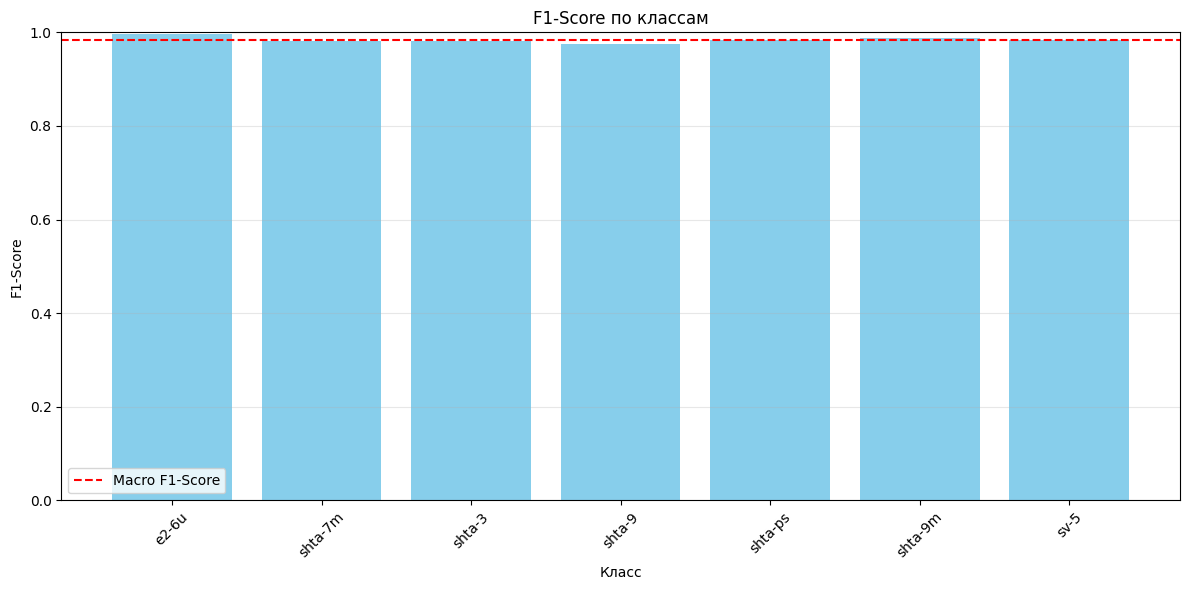

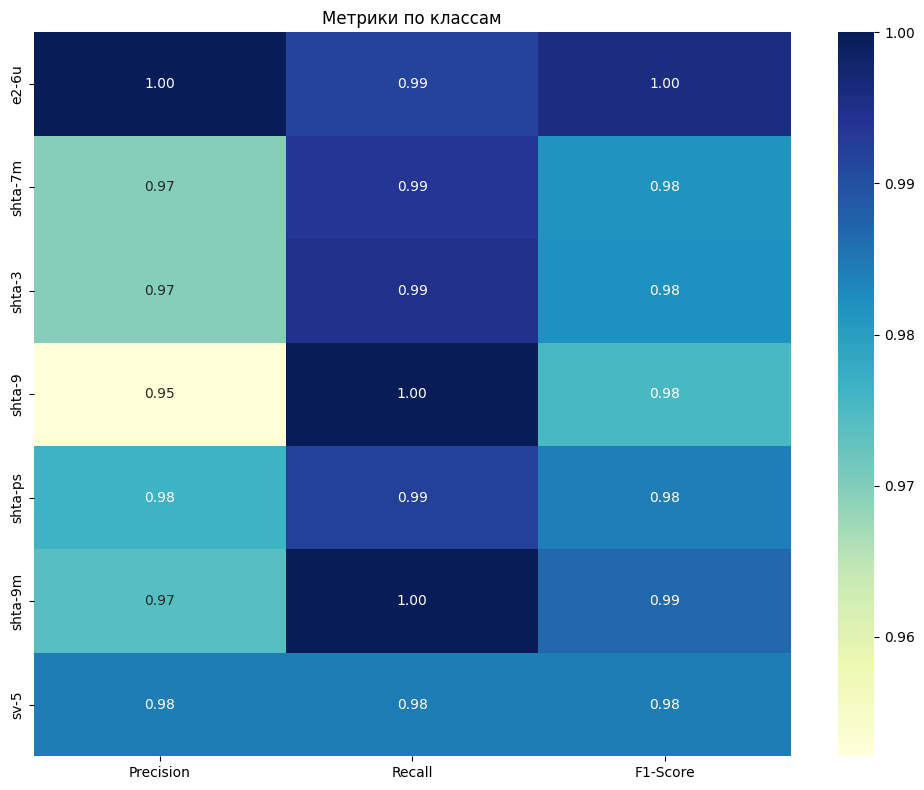

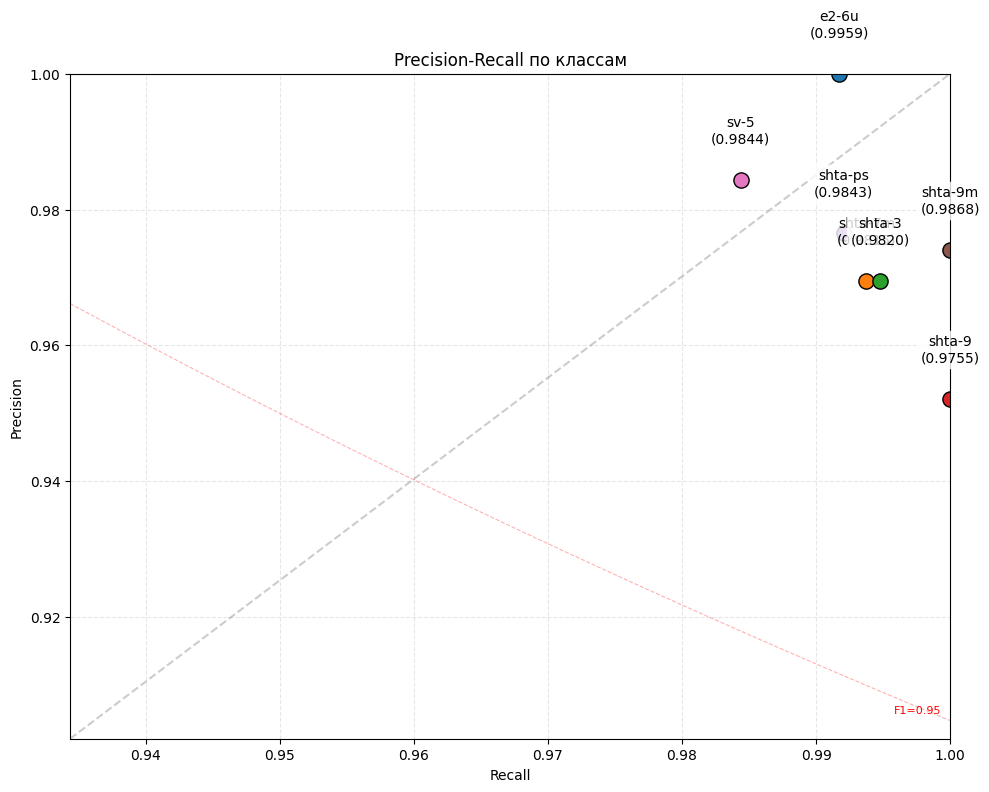

In [54]:
# Визуализация метрик
f1_plots = visualize_f1_metrics(df_class_report, overall_metrics)

## IOU metrics


=== Метрики IoU ===
Средний IoU: 0.9598
Медиана IoU: 0.9675
Минимальный IoU: 0.6386
Максимальный IoU: 0.9980

IoU по классам:
     Class  Mean IoU  Median IoU   Min IoU   Max IoU
0    e2-6u  0.965901    0.969056  0.899296  0.997976
1   shta-3  0.958611    0.968752  0.765104  0.993223
2  shta-7m  0.958518    0.967300  0.638596  0.990634
3   shta-9  0.962875    0.968120  0.829110  0.990501
4  shta-9m  0.954631    0.962294  0.678254  0.994407
5  shta-ps  0.955724    0.964425  0.807953  0.997012
6     sv-5  0.963944    0.971507  0.763373  0.992532

=== Визуализация метрик IoU ===



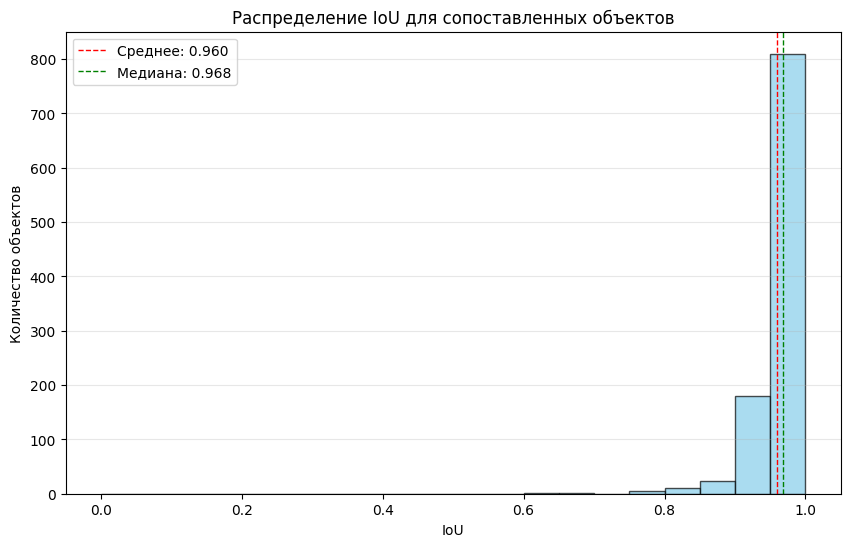

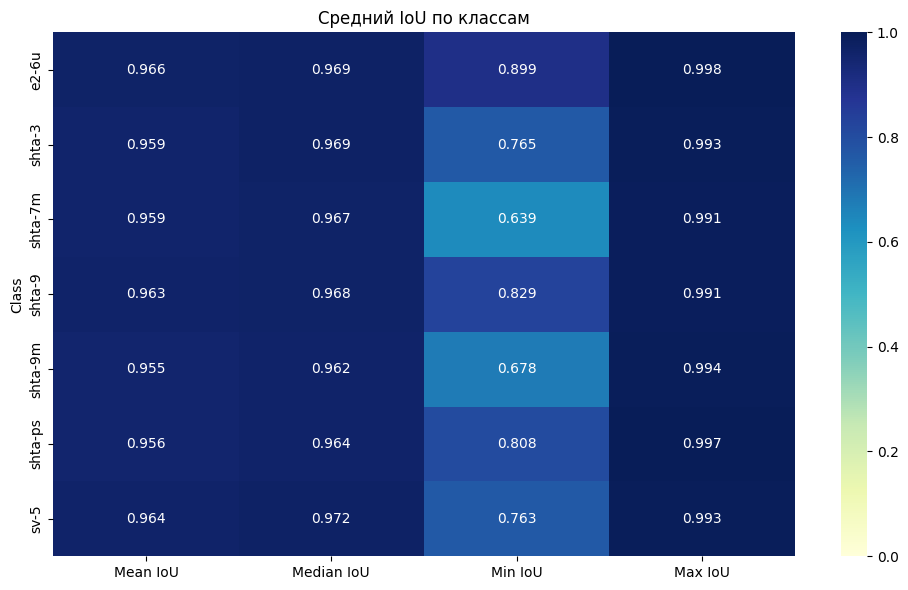

In [55]:
# 7. Расчет и визуализация метрик IoU
# from error_analysis import calculate_iou_metrics, visualize_iou_metrics

# Расчет метрик IoU
iou_metrics = calculate_iou_metrics(comparison_df)

# Вывод результатов
print("\n=== Метрики IoU ===")
print(f"Средний IoU: {iou_metrics['mean_iou']:.4f}")
print(f"Медиана IoU: {iou_metrics['median_iou']:.4f}")
print(f"Минимальный IoU: {iou_metrics['min_iou']:.4f}")
print(f"Максимальный IoU: {iou_metrics['max_iou']:.4f}")

print("\nIoU по классам:")
print(iou_metrics['iou_per_class'])

# Визуализация метрик IoU
print("\n=== Визуализация метрик IoU ===\n")
iou_plots = visualize_iou_metrics(iou_metrics)

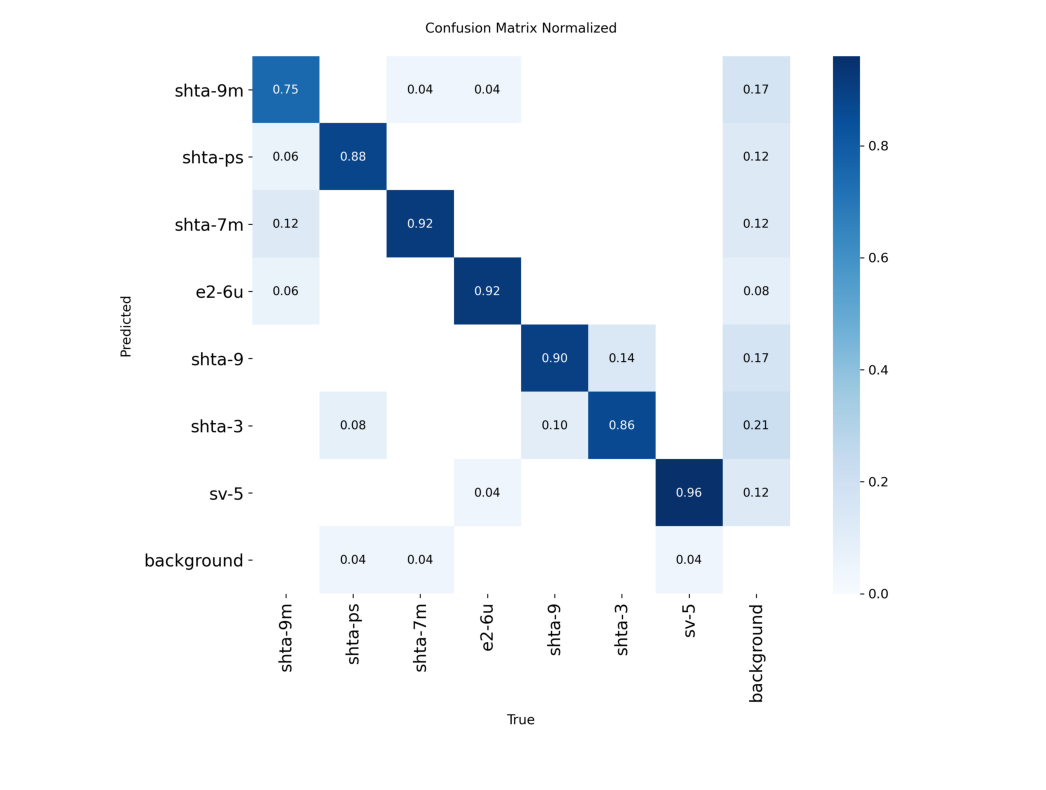

In [56]:
pic_name = '/content/runs/detect/yolo_test_evaluation4/confusion_matrix_normalized.png'
image=plt.imread(pic_name)
plt.figure(figsize=(15, 10))
_=plt.imshow(image)
_=plt.axis('off')
